# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit+rpe+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3426.91it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit', 'rpe', 'cpe']

In [14]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.031034   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.032092   
2     MS002_lacas3-lacas4   MS002    acc   14                    -0.005977   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.013302   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.032526   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                    -0.032592   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.009988   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.025259   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.031310   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.032446   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.035142                  -0.071897   
1                                  -0.048650                   0.015760   
2                                  -0.003449                   0.048940   
3                                  -0.017968                   0.024874   
4                                  -0.028049                  -0.001730   
...                                      ...                        ...   
1183                                0.004393                   0.136639   
1184                               -0.017665                   0.039503   
1185                               -0.034147                  -0.037779   
1186                                0.028939                   0.023659   
1187                                0.024423                  -0.072648   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                     0.141211              -0.041192              -0.010996   
1                    -0.027349               0.046756               0.009386   
2                    -0.092906               0.062963              -0.004206   
3                    -0.061029               0.036638              -0.017527   
4                    -0.020265               0.066837              -0.026760   
...                        ...                    ...                    ...   
1183                 -0.184628               0.107654               0.007956   
1184                  0.008181               0.016336              -0.052819   
1185                  0.129664              -0.077469              -0.063487   
1186                 -0.052238               0.045843               0.025955   
1187                  0.114992              -0.073566              -0.014832   

      ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  \
0     ...        -1.000467        1.472269    -0.660836    -0.440898   
1     ...         0.206328       -0.262810     0.673687     0.317152   
2     ...         0.772804       -1.100038     1.135360    -0.173739   
3     ...         0.306753       -0.573736     0.521743    -0.708218   
4     ...        -0.004768       -0.227659     1.049220    -0.979887   
...   ...              ...             ...          ...          ...   
1183  ...         1.475886       -1.275593     1.012330     0.263163   
1184  ...         0.354237        0.067044     0.109369    -1.312975   
1185  ...        -0.271877        0.570237    -0.487169    -1.216922   
1186  ...         0.333645       -0.503845     0.608838     1.107567   
1187  ...        -1.201025        1.212858    -1.059780    -0.657535   

      P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0              0.103893                      0.101696         0.317084   
1              0.024827                      0.024834         0.836535   
2              0.853894                      0.854619         0.439638   
3              0.421938                      0.4201

### Save results as pickle file

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_combomodel-Profit_rpe_cpe_regression_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Results

In [16]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  \
12        MS002_laims1-laims2   MS002   ains   14   
64      MS002_raims12-raims13   MS002  dlpfc   14   
84        MS003_laimm1-laimm2   MS003   ains    8   
86        MS003_laimm3-laimm4   MS003   ains    8   
100       MS003_racas2-racas3   MS003    acc    8   
...                       ...     ...    ...  ...   
1091  MS050_rainss11-rainss12   MS050  dlpfc    9   
1103      MS050_rmoif6-rmoif7   MS050    ofc    9   
1104      MS050_rmoif7-rmoif8   MS050    ofc    9   
1105      MS050_rmoif8-rmoif9   MS050  vlpfc    9   
1168          DA039_rfp3-rfp4   DA039    ofc   22   

      Original_Estimate_Intercept  Original_Estimate_GambleChoice[T.safe]  \
12                       0.035583                               -0.028705   
64                      -0.028437                               -0.005439   
84                       0.075311                               -0.021022   
86                       0.069892                               -0.005217   
100                      0.021107                                0.000867   
...                           ...                                     ...   
1091                     0.016561                                0.039419   
1103                     0.135175                                0.048432   
1104                     0.115761                                0.103956   
1105                     0.080892                                0.040119   
1168                    -0.029767                               -0.003408   

      Original_Estimate_TrialEV  Original_Estimate_Profit  \
12                    -0.018107                  0.020552   
64                     0.010990                  0.028464   
84                    -0.058628                  0.136282   
86                     0.087960                 -0.161900   
100                    0.084854                 -0.114931   
...                         ...                       ...   
1091                  -0.032671                  0.003964   
1103                   0.136807                 -0.259853   
1104                   0.224950                 -0.377405   
1105                   0.144200                 -0.306649   
1168                  -0.022788                  0.042997   

      Original_Estimate_rpe  Original_Estimate_cpe  ...  Z_Score_TrialEV  \
12                 0.074553              -0.053362  ...        -0.254336   
64                 0.016766              -0.059752  ...         0.131163   
84                -0.187712               0.161440  ...        -0.532211   
86                 0.042053               0.193462  ...         0.799828   
100                0.067308               0.105590  ...         0.996659   
...                     ...                    ...  ...              ...   
1091              -0.064330               0.073287  ...        -0.346940   
1103               0.100315               0.124288  ...         1.083020   
1104               0.196726               0.158575  ...         1.525180   
1105               0.208008               0.136220  ...         1.037757   
1168              -0.004623              -0.020456  ...        -0.912953   

      Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
12          0.207296     1.152190    -2.203453           0.173932   
64          0.284331     0.236285    -2.255488           0.845013   
84          0.742781    -1.391727     3.099633           0.488785   
86         -0.891017     0.361880     3.344215           0.904255   
100        -0.809001     0.646957     2.452619           0.890435   
...              ...          ...          ...                ...   
1091        0.045289    -0.531766     2.051296           0.144373   
1103       -1.245712     0.689194     2.710943           0.133551   
1104       -1.508447     1.064432     3.197146           0.005468   
1105       -1.324002     1.223161     2.839689           0.240407   
1168        1.106674    -0.184413    -2.026220  

In [17]:
sig_data.roi.value_counts()



roi
ofc      19
dmpfc    14
acc      12
amy       7
ains      6
dlpfc     6
vlpfc     5
hpc       5
pins      2
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['ains', 'dlpfc', 'acc', 'vlpfc', 'amy', 'ofc', 'dmpfc', 'pins',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [30]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031034   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032092   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.005977   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.013302   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.032526   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035142                  -0.071897   
1                               -0.048650                   0.015760   
2                               -0.003449                   0.048940   
3                               -0.017968                   0.024874   
4                               -0.028049                  -0.001730   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.141211              -0.041192              -0.010996   
1                 -0.027349               0.046756               0.009386   
2                 -0.092906               0.062963              -0.004206   
3                 -0.061029               0.036638              -0.017527   
4                 -0.020265               0.066837              -0.026760   

   ...  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0  ...    -0.660836    -0.440898           0.103893   
1  ...     0.673687     0.317152           0.024827   
2  ...     1.135360    -0.173739           0.853894   
3  ...     0.521743    -0.708218           0.421938   
4  ...     1.049220    -0.979887           0.208895   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_rpe  \
0                      0.101696         0.317084        0.140948     0.508718   
1                      0.024834         0.836535        0.792697     0.500510   
2                      0.854619         0.439638        0.271316     0.256224   
3                      0.420153         0.759032        0.566146     0.601849   
4                      0.206623         0.996195        0.819911     0.294077   

   P_Value_cpe  cpe_sig  bdi_split  
0     0.659287        0          0  
1     0.751128        0          0  
2     0.862071        0          0  
3     0.478810        0          0  
4     0.327142        0          0  

[5 rows x 36 columns]

In [31]:
cpe_var = 'Z_Score_cpe'

In [32]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [33]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc   -0.107599
vlpfc    0.363403
dmpfc    0.190581
ofc      0.160174
ains     0.417386
pins    -0.076126
acc      0.187552
amy      0.110139
hpc     -0.110585
Name: Z_Score_cpe, dtype: float64

In [34]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [35]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     12  0.062176              2    2.482538    0.013903   
1  dmpfc      225     14  0.062222              4    2.728698    0.006863   
2    amy      113      7  0.061947              1    1.041398    0.299933   
3   ains       71      6  0.084507              1    3.129773    0.002551   
4  vlpfc       82      5  0.060976              3    3.592797    0.000560   
5    hpc      135      5  0.037037              0   -1.298623    0.196304   
6    ofc      202     19  0.094059             10    2.013247    0.045422   
7   pins       60      2  0.033333              1   -0.528825    0.598911   
8  dlpfc      107      6  0.056075              1   -1.076220    0.284272   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.036265            1.0    0.062176      0.2603  
1      0.038006            1.0    0.062222      0.2380  
2      0.029432            1.0    0.061947      0.3362  
3      0.037443            1.0    0.084507      0.1440  
4      0.024331            1.0    0.060976      0.3912  
5      0.014705            1.0    0.037037      0.8101  
6      0.062472            1.0    0.094059      0.0065  
7      0.005955            1.0    0.033333      0.8084  
8      0.024699            1.0    0.056075      0.4468

In [36]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
6  ofc      202     19  0.094059             10    2.013247    0.045422   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
6      0.062472            1.0    0.094059      0.0065

In [37]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-cpe_coeff_barplot_{epoch_len}.pdf'


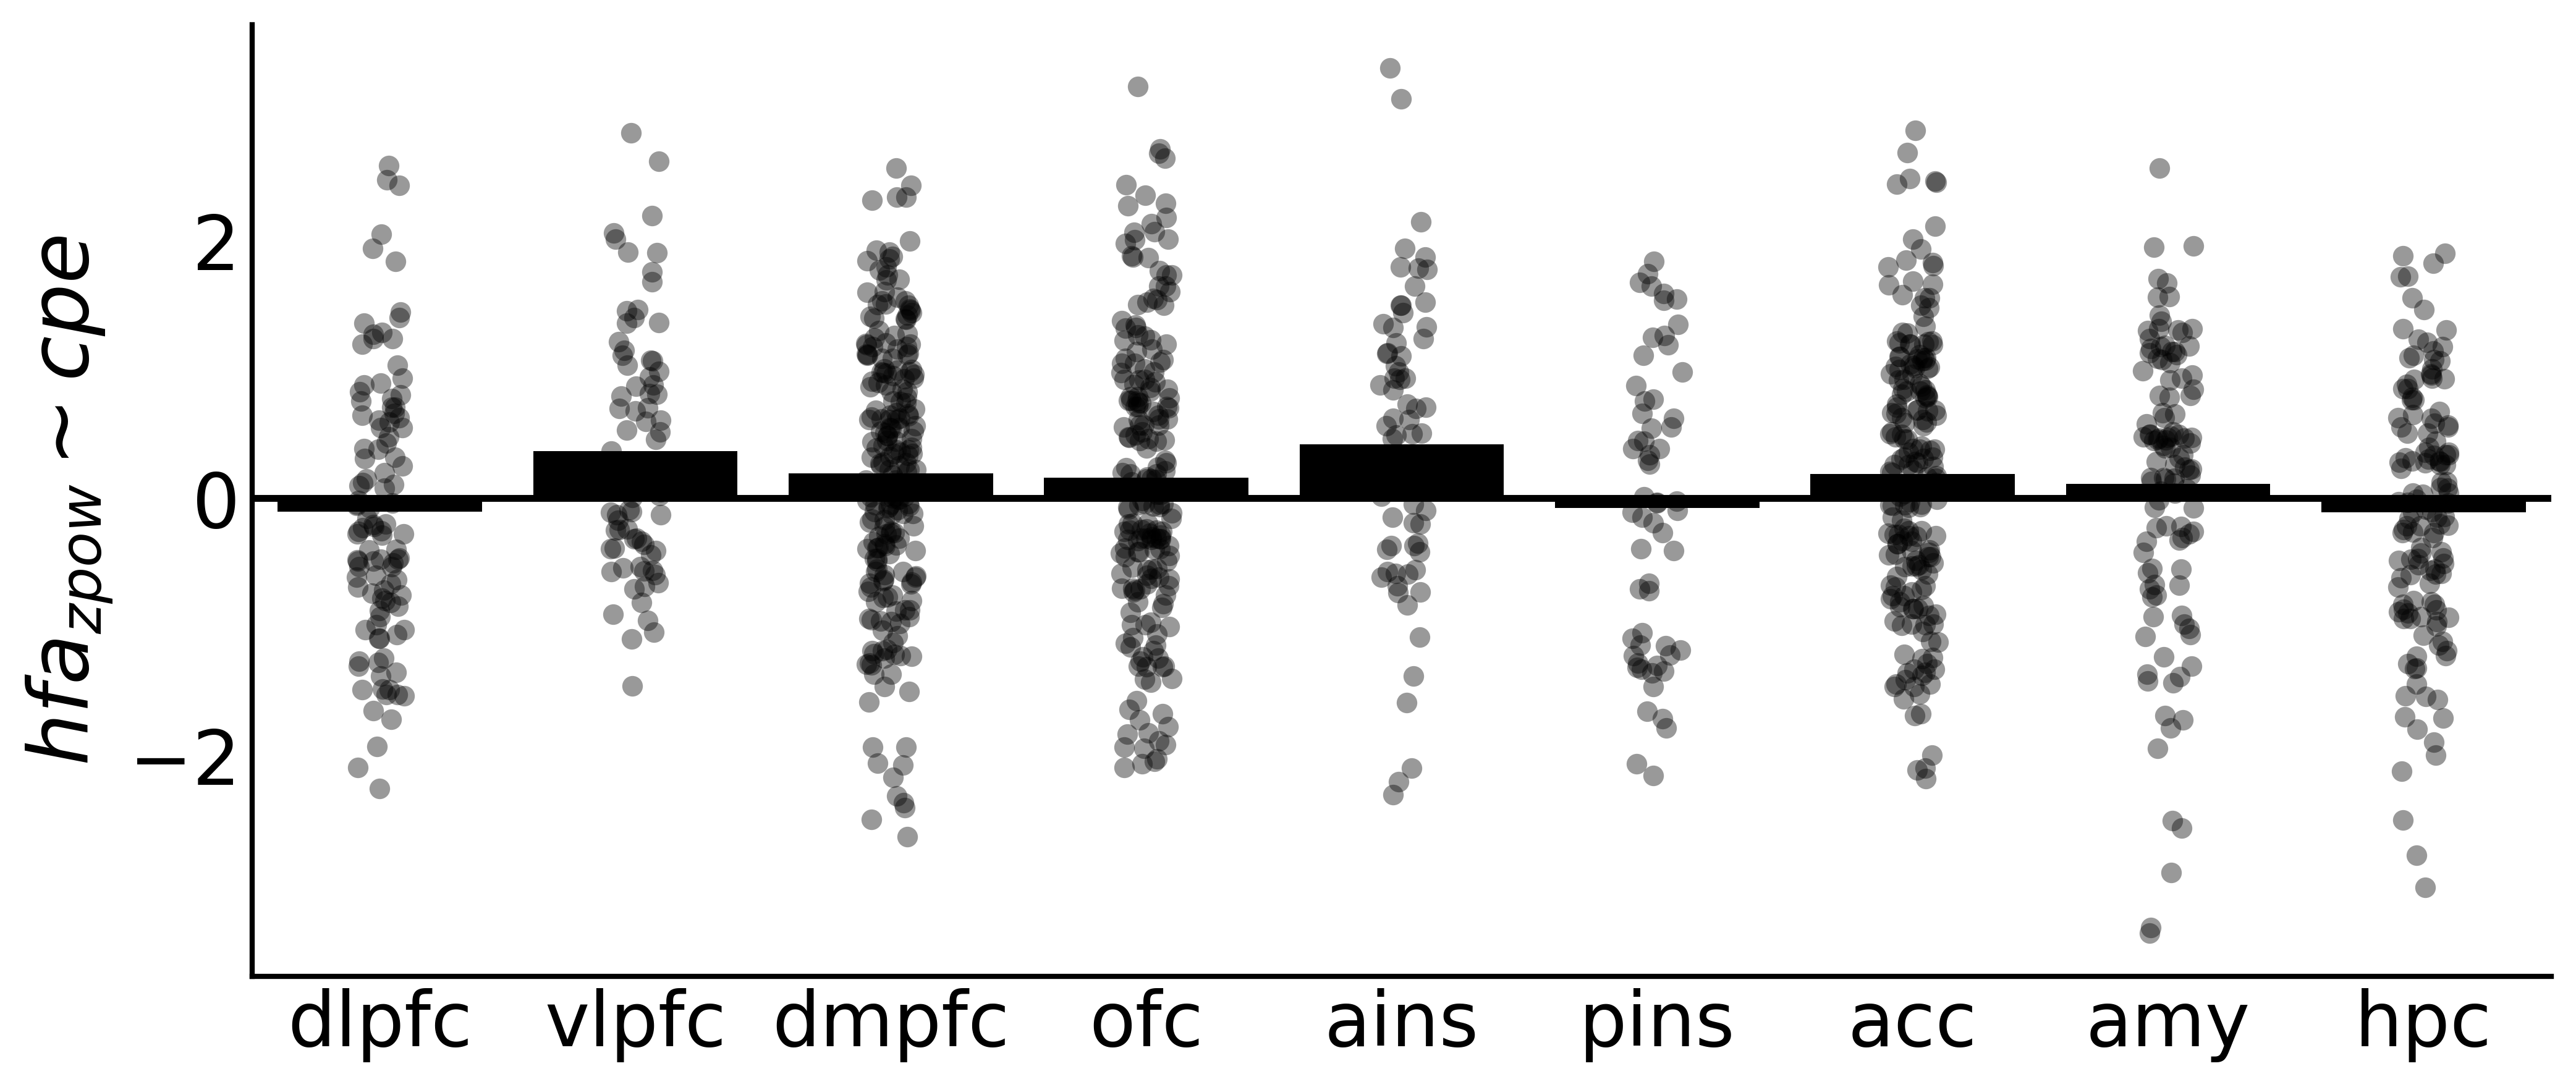

In [38]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

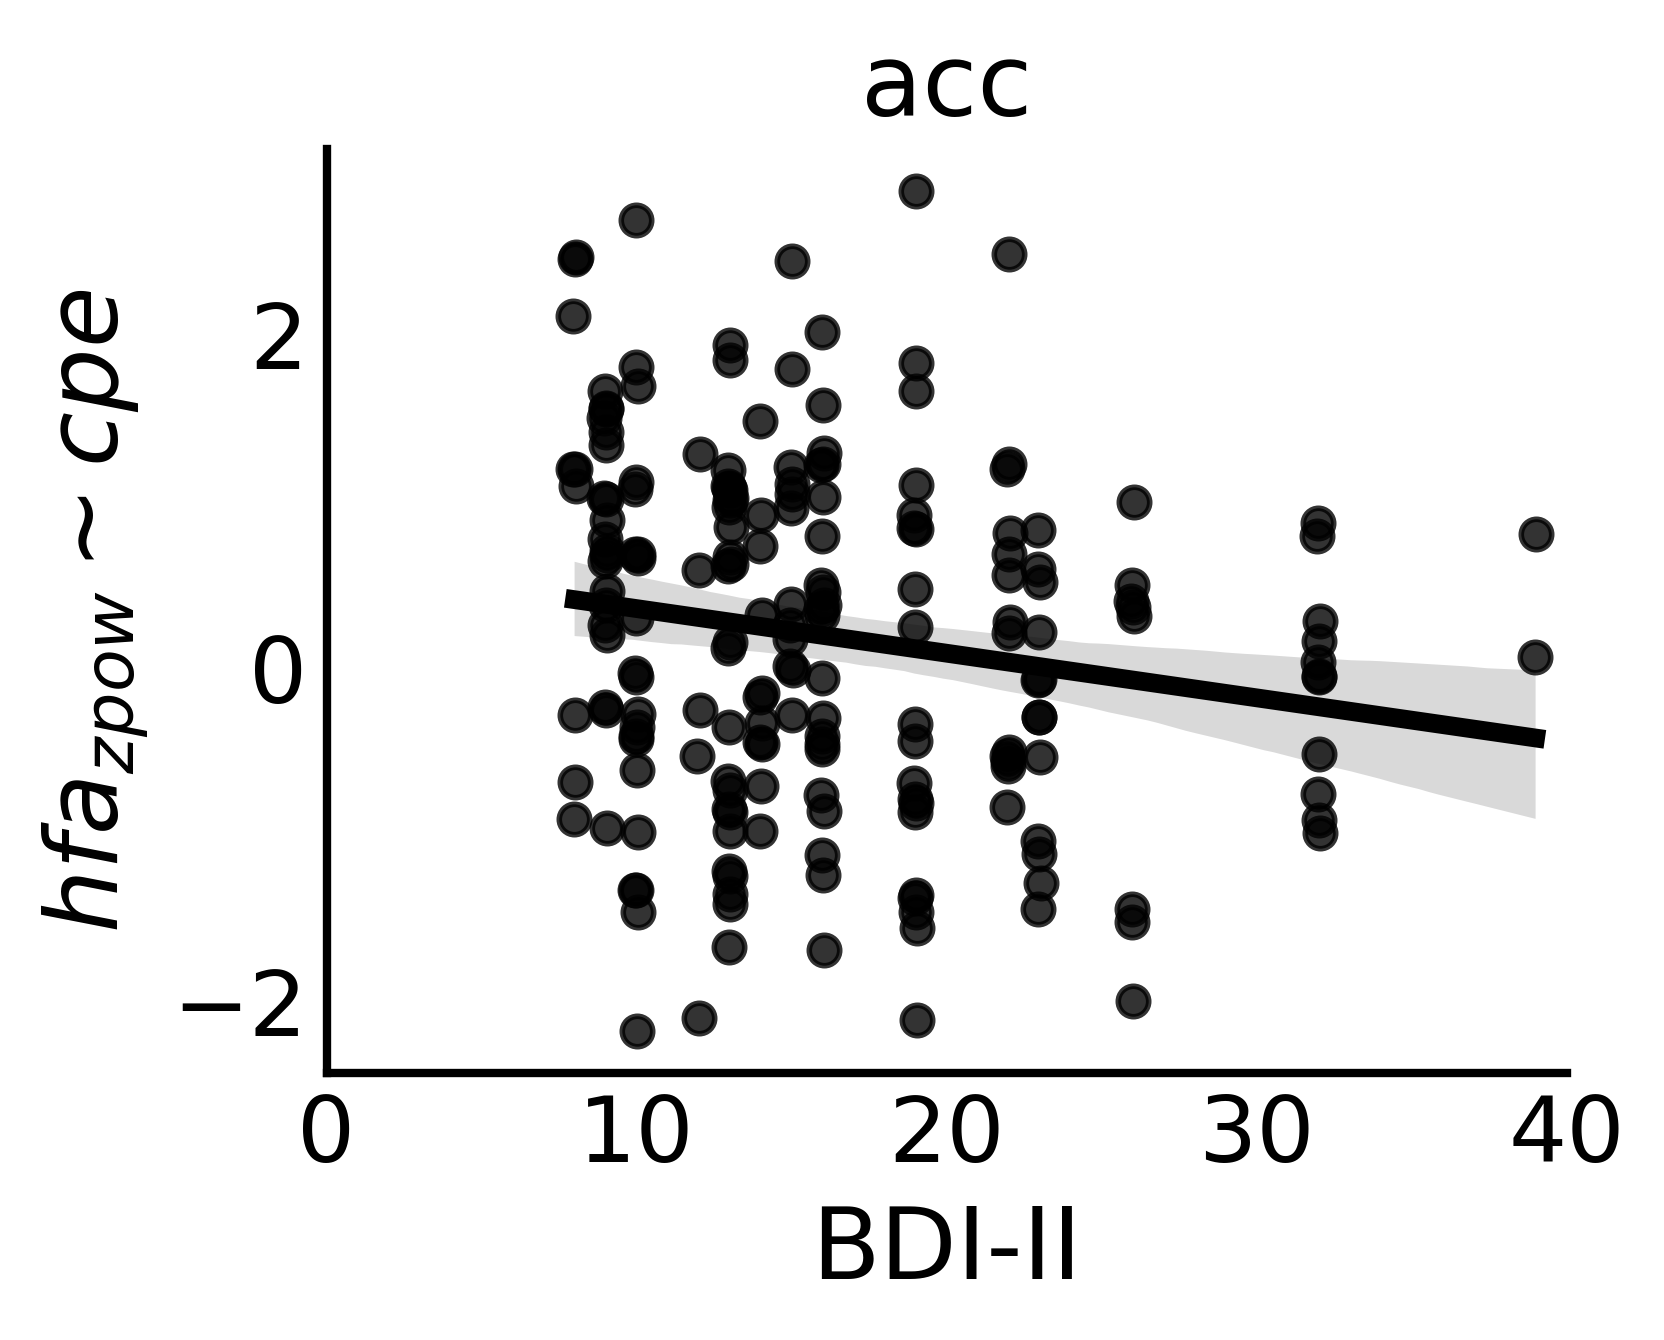

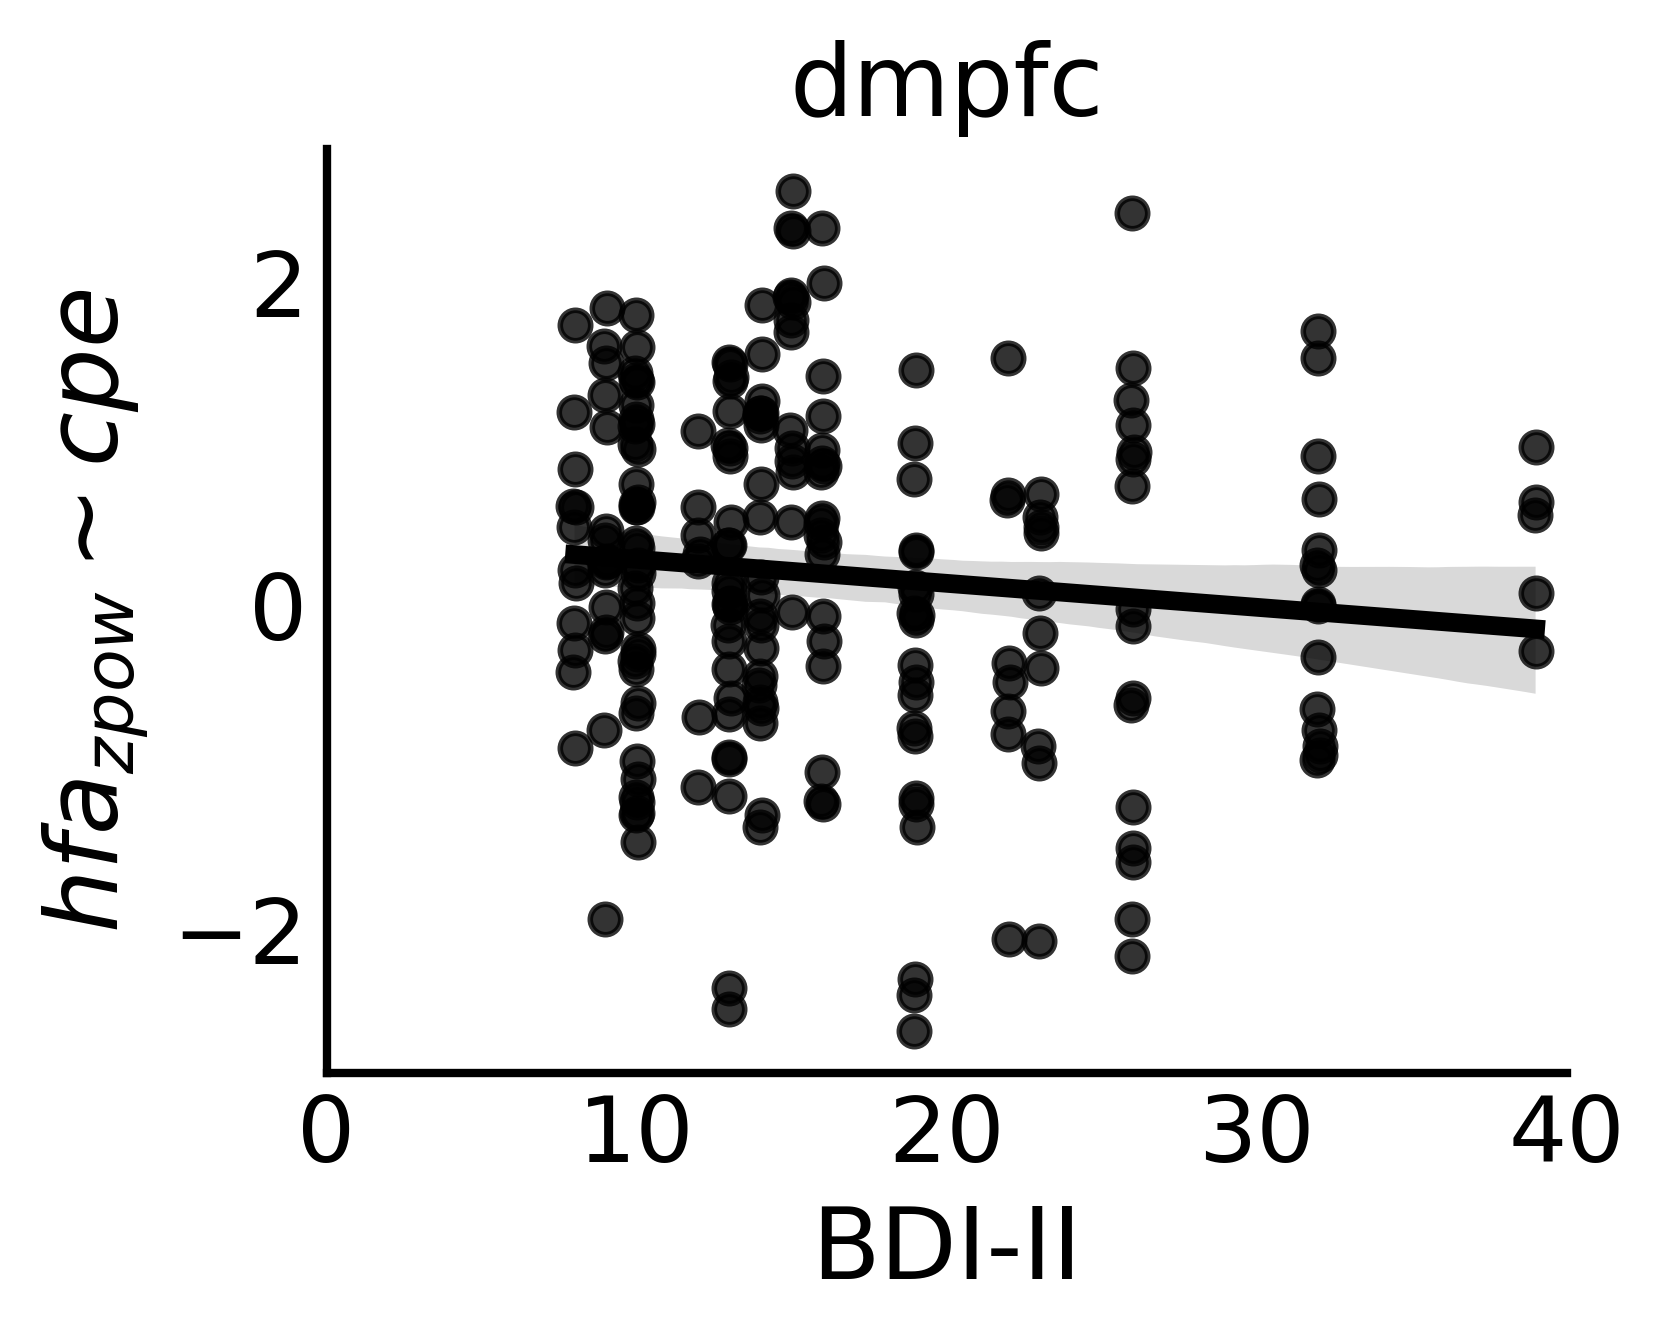

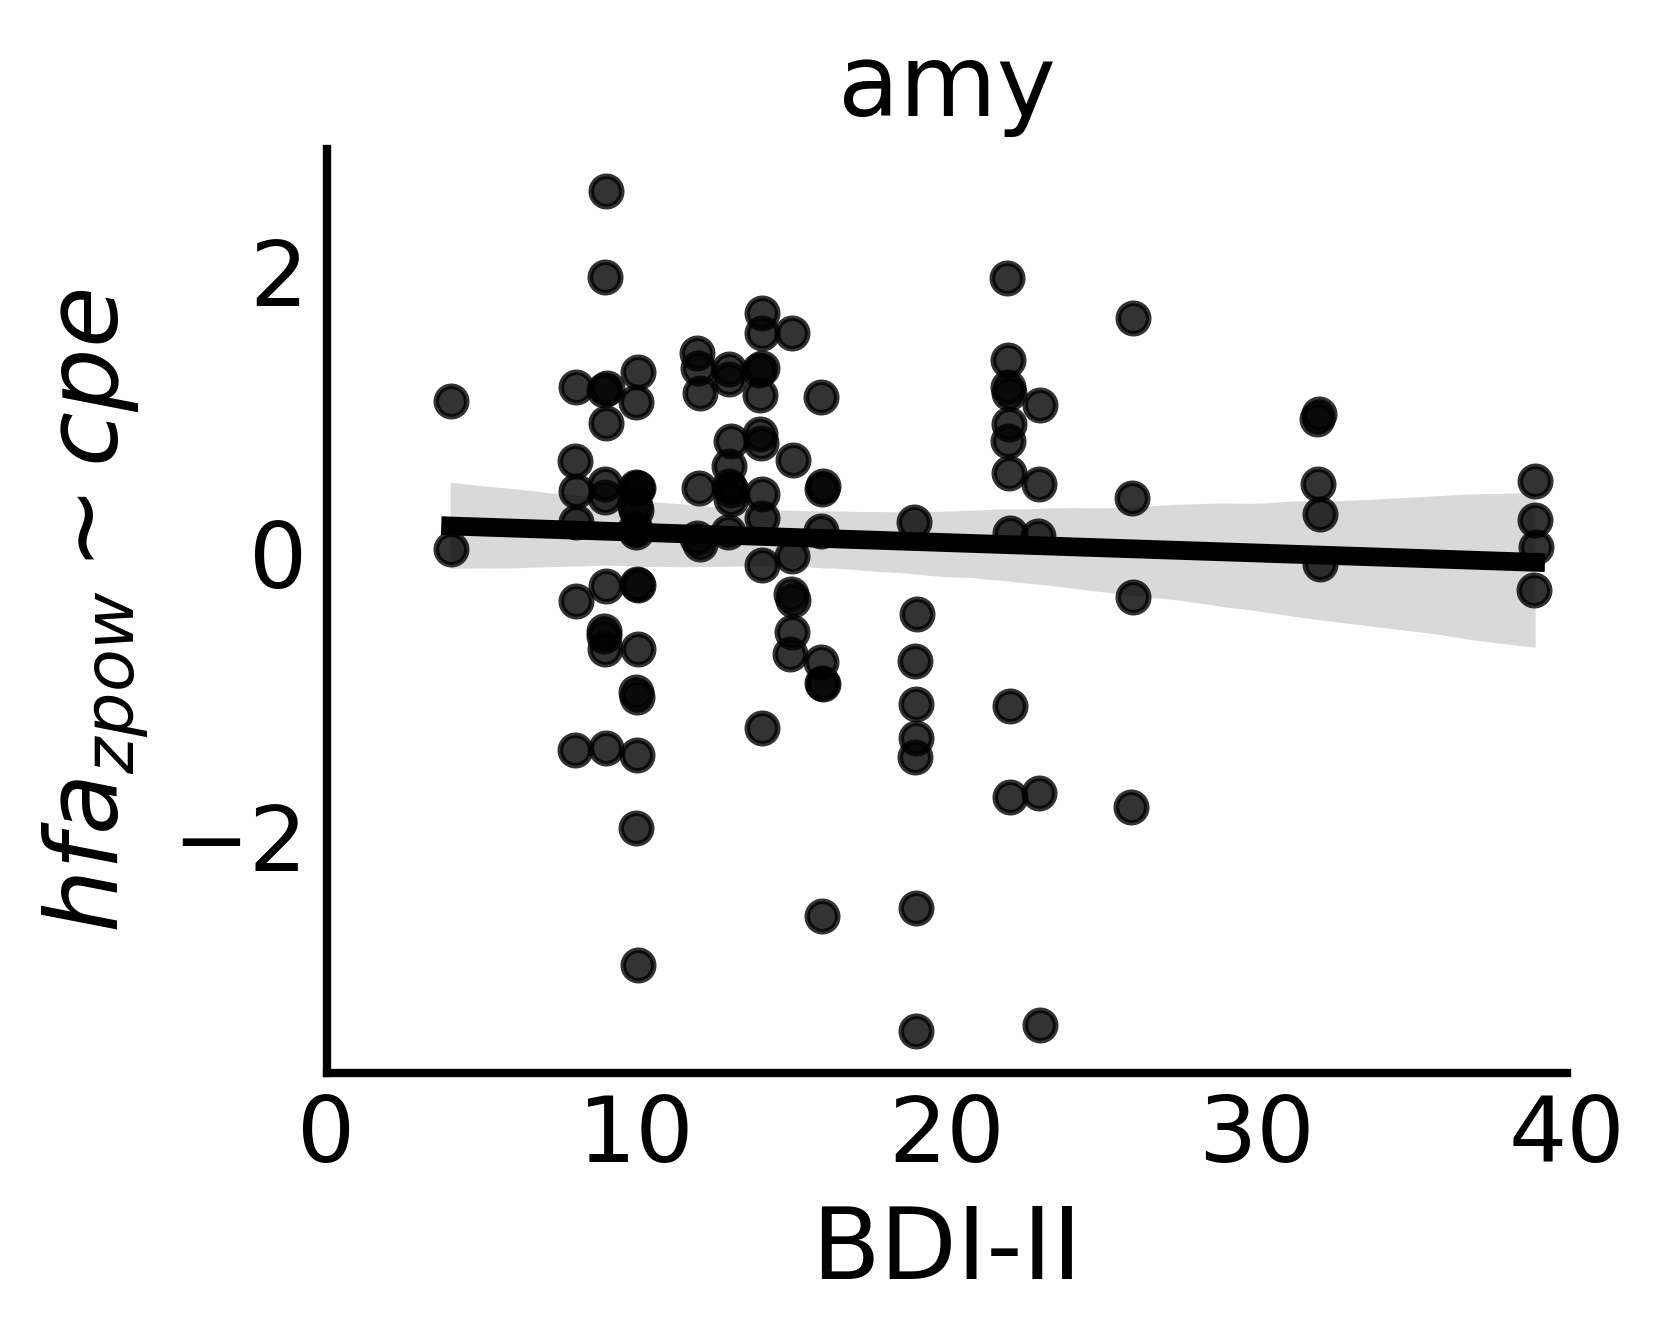

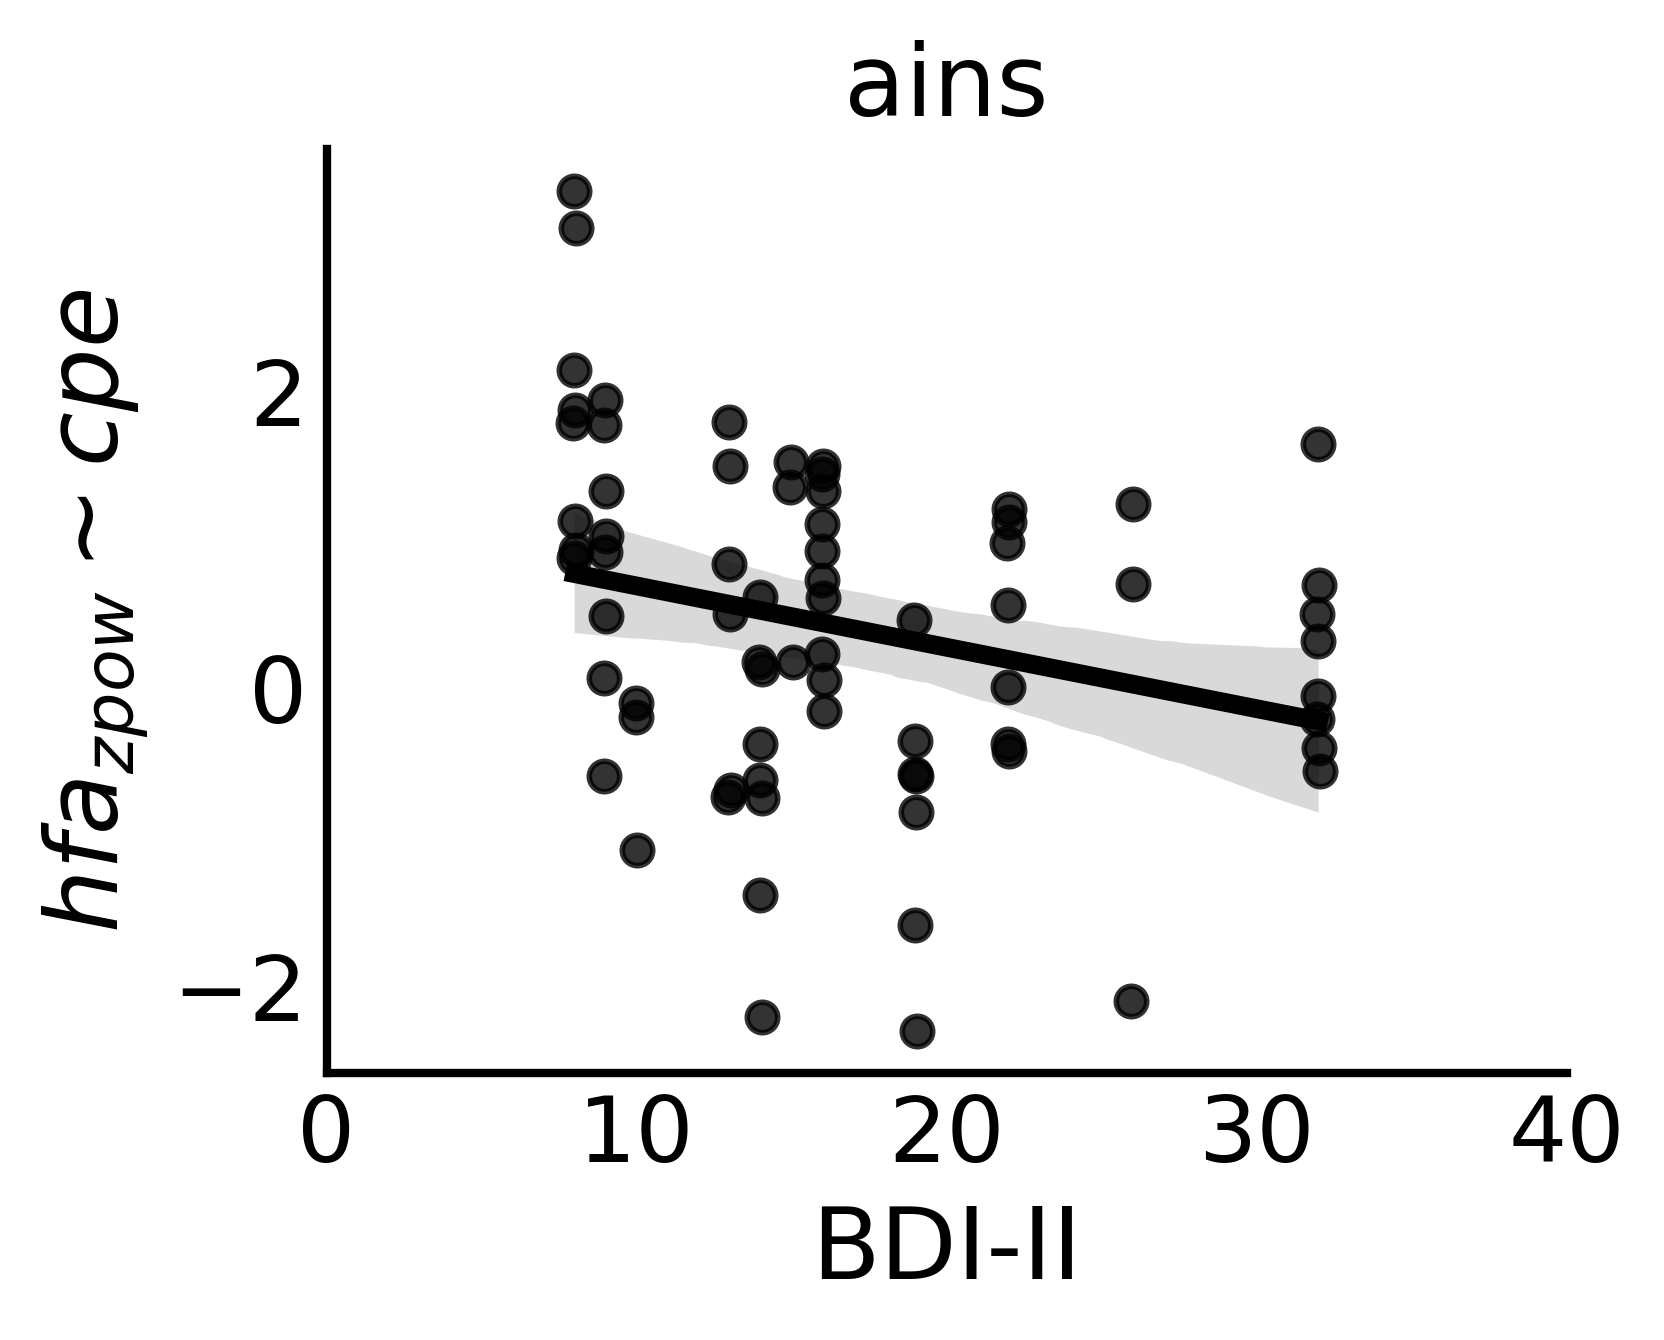

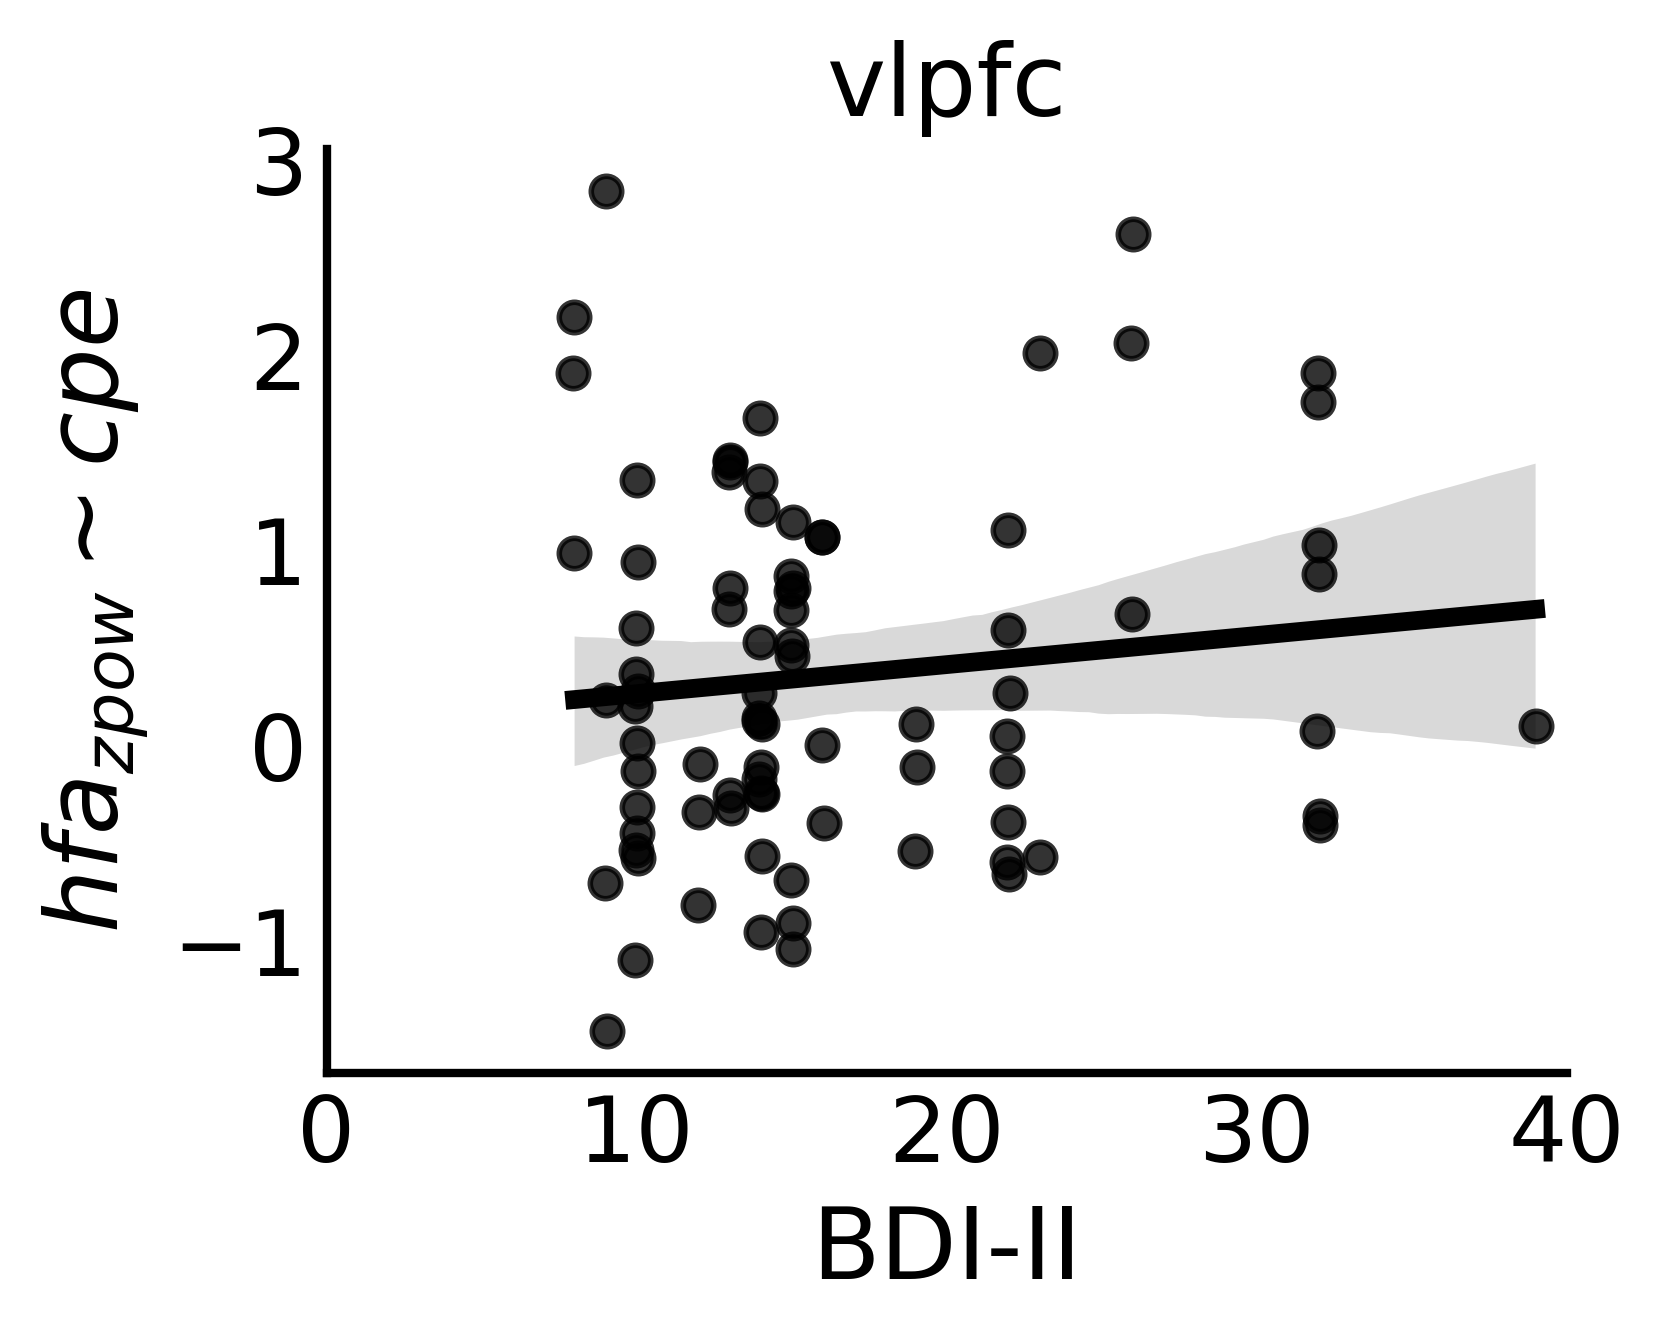

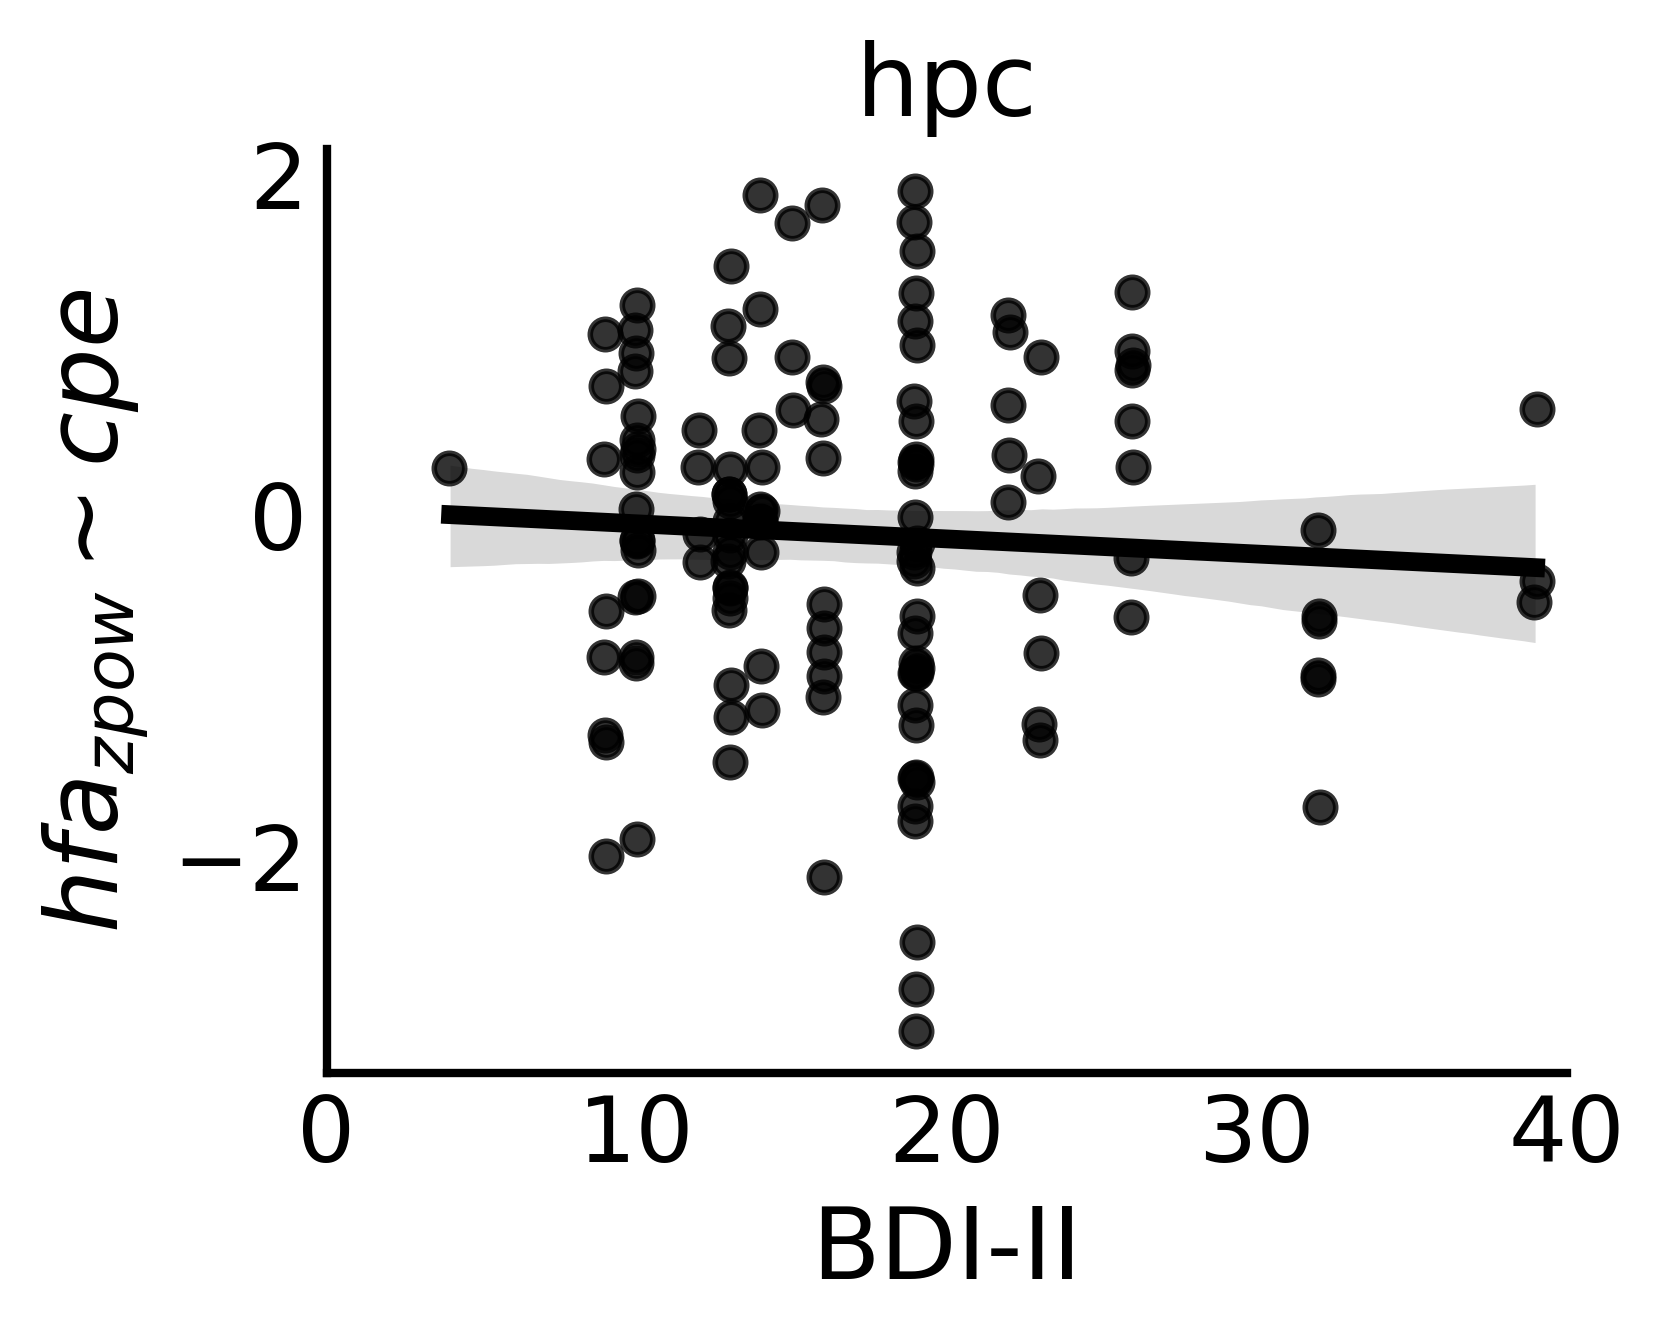

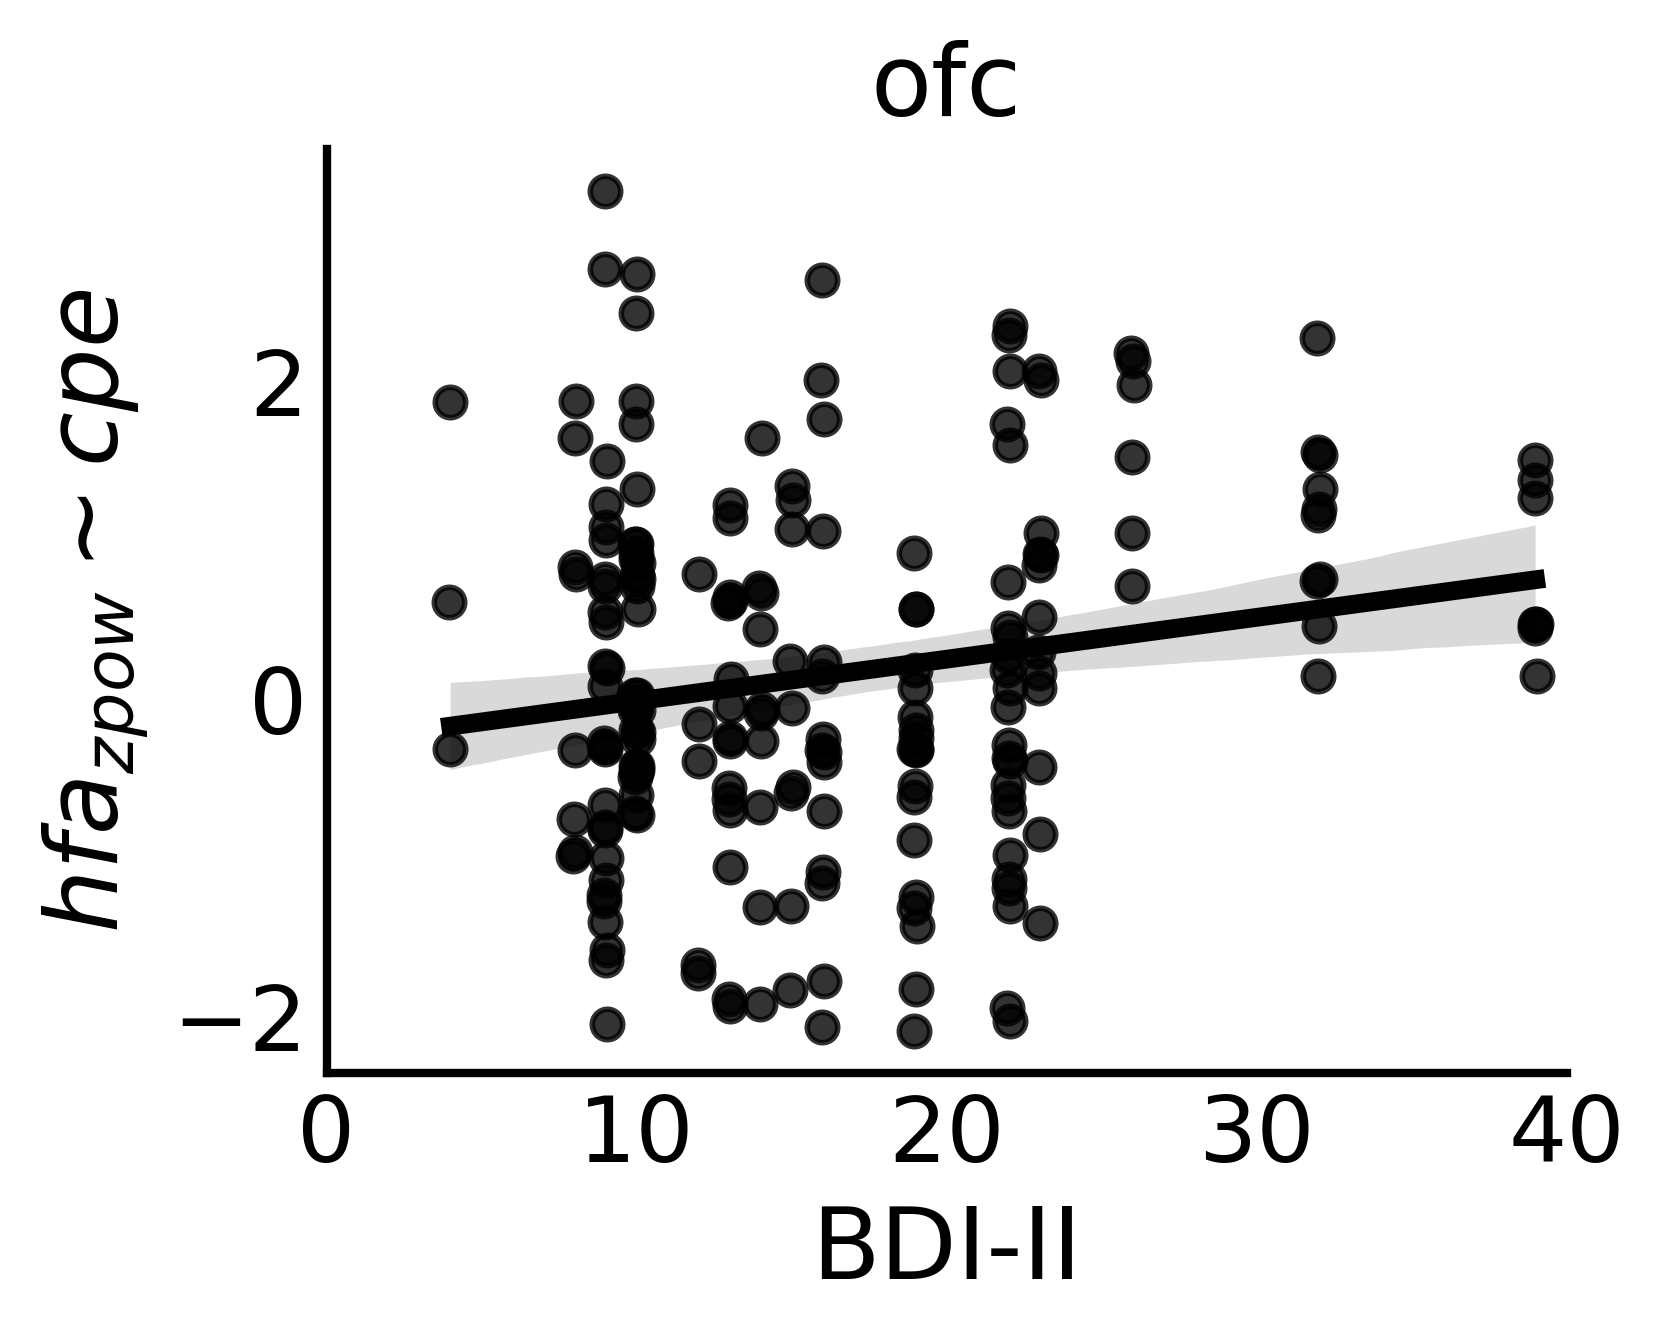

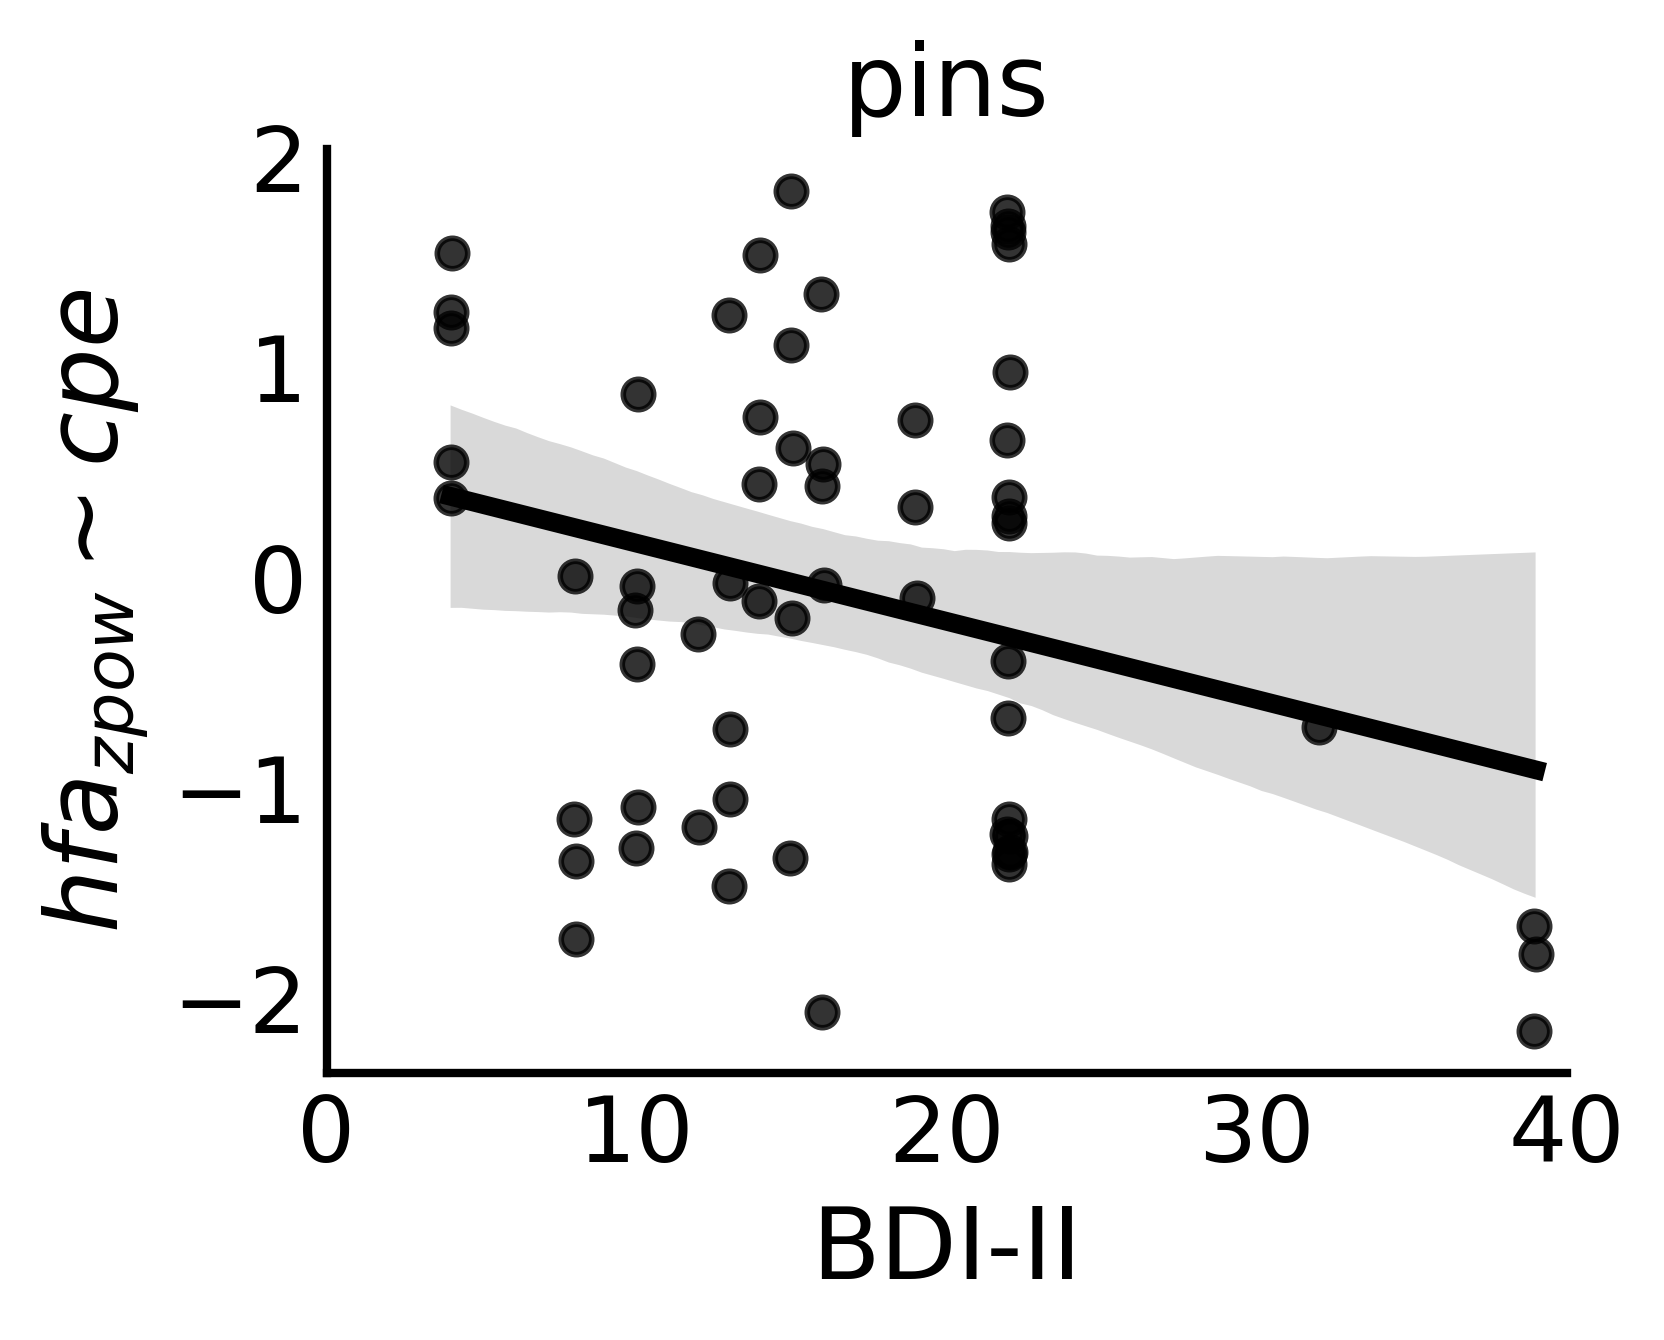

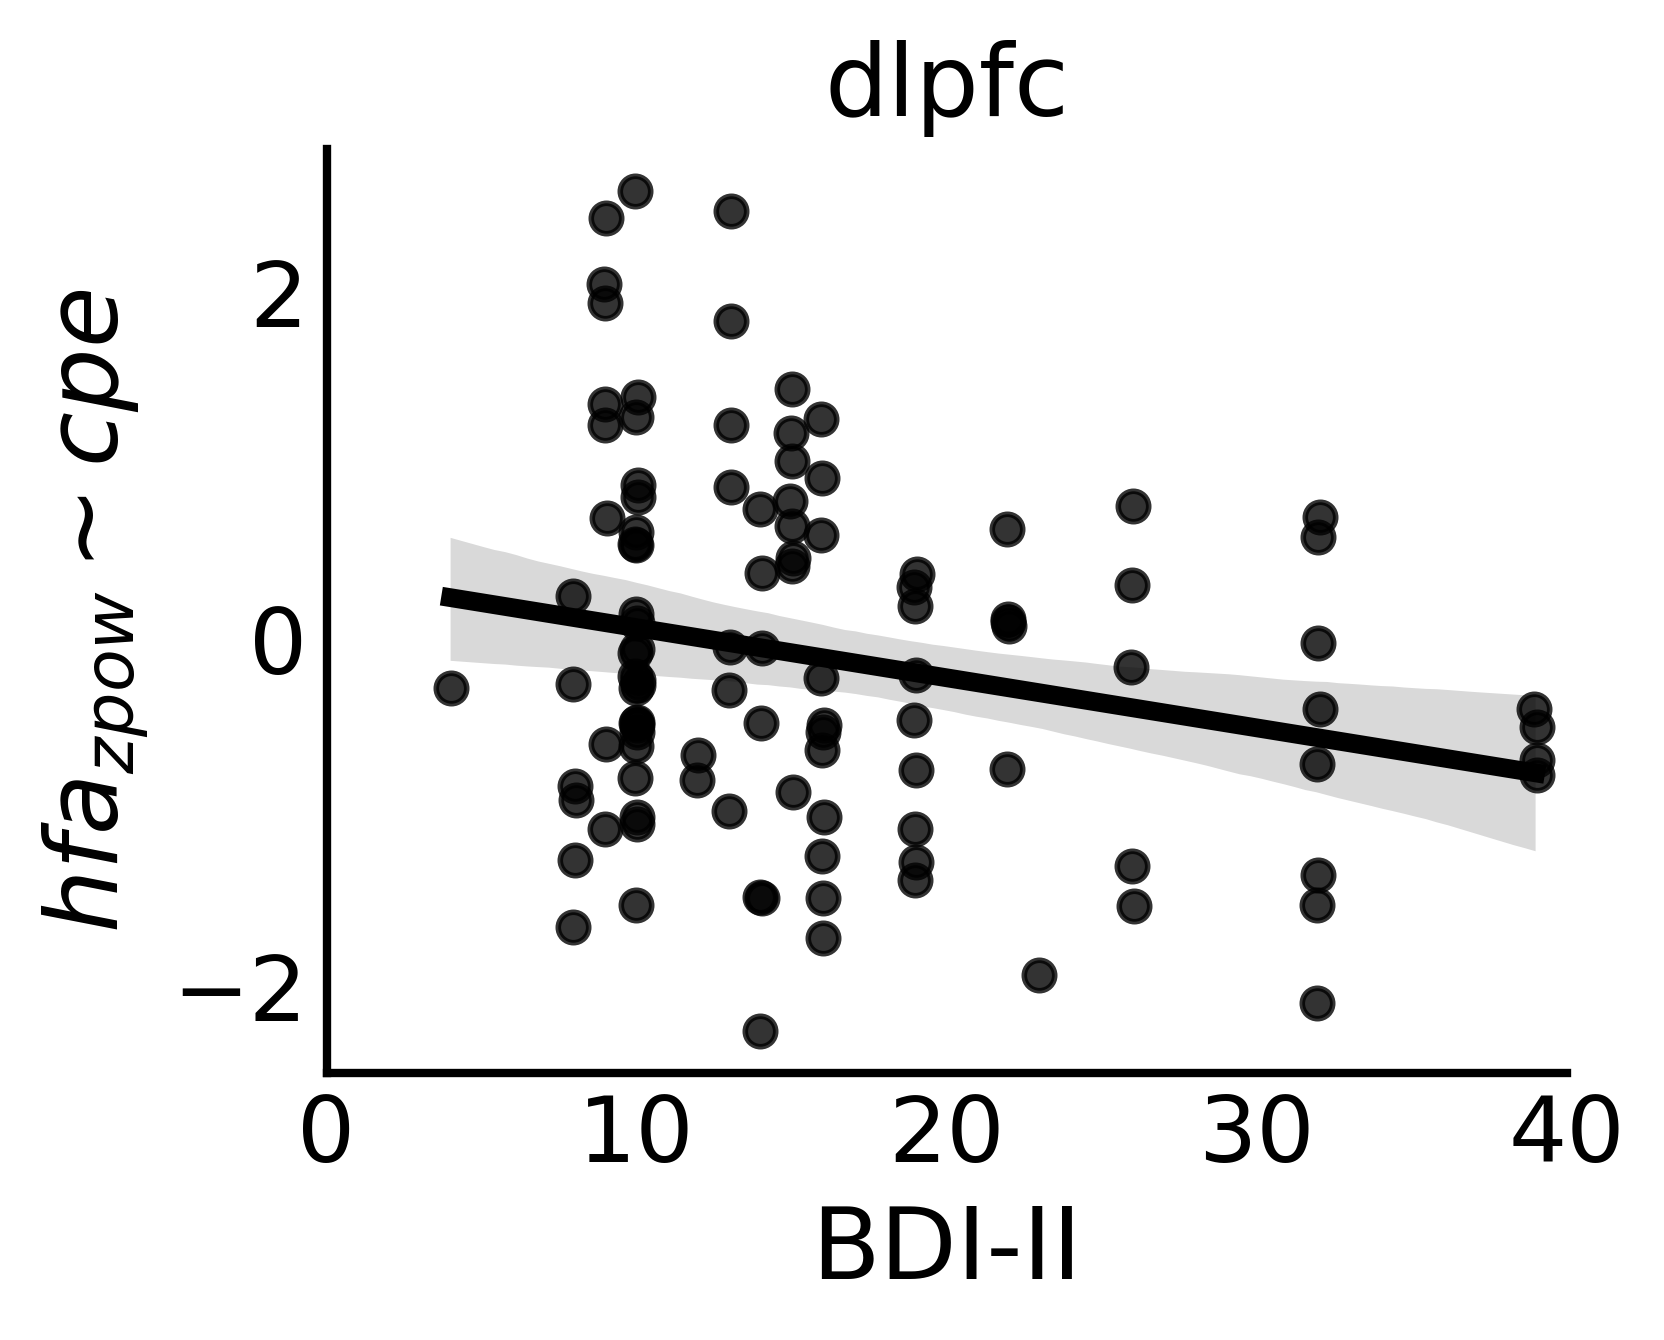

In [39]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [41]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:12:29                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9850      0.438     36.469     

In [43]:
# del cpe_var

# RPE Results

In [44]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
9     MS002_lagit1-lagit2   MS002    amy   14                    -0.000754   
58    MS002_raims1-raims2   MS002   ains   14                     0.018494   
59    MS002_raims2-raims3   MS002   ains   14                     0.110770   
91    MS003_lmcms8-lmcms9   MS003  dmpfc    8                     0.007339   
98    MS003_lsifo1-lsifo2   MS003   pins    8                     0.009099   
...                   ...     ...    ...  ...                          ...   
1121      DA023_lac8-lac9   DA023  dmpfc   14                     0.002373   
1129      DA023_lam2-lam3   DA023    amy   14                    -0.014833   
1157  DA039_rains1-rains2   DA039   ains   22                    -0.033287   
1164  DA039_rains8-rains9   DA039  vlpfc   22                     0.024175   
1174      DA039_rof3-rof4   DA039    ofc   22                     0.029442   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
9                                  -0.003463                   0.127304   
58                                 -0.015097                   0.052976   
59                                 -0.050075                   0.085882   
91                                 -0.047734                  -0.175234   
98                                 -0.028063                  -0.210195   
...                                      ...                        ...   
1121                               -0.005400                   0.223740   
1129                                0.006811                   0.138792   
1157                                0.046700                   0.181306   
1164                               -0.011528                   0.193799   
1174                               -0.051256                  -0.226127   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
9                    -0.124359               0.107064               0.027398   
58                   -0.112009               0.111832              -0.031980   
59                   -0.189454               0.188306              -0.021640   
91                    0.334754              -0.263693              -0.044684   
98                    0.381514              -0.245668              -0.049819   
...                        ...                    ...                    ...   
1121                 -0.337514               0.219803               0.056131   
1129                 -0.196986               0.150878               0.041695   
1157                 -0.289928               0.230475               0.000983   
1164                 -0.283627               0.225539               0.022473   
1174                  0.422122              -0.221840              -0.044994   

      ...  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
9     ...     2.038657     1.303718           0.875245   
58    ...     1.974944    -1.383332           0.450622   
59    ...     2.389228    -0.735181           0.034431   
91    ...    -2.218800    -0.877908           0.049046   
98    ...    -2.588768    -1.142938           0.182111   
...   ...          ...          ...                ...   
1121  ...     2.445381     1.860164           0.872978   
1129  ...     2.200053     1.705021           0.702786   
1157  ...     2.105164     0.014446           0.062259   
1164  ...     2.150341     0.594502           0.953474   
1174  ...    -2.105271    -1.303960           0.036058   

      P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  \
9                         0.872588         0.032268        0.117899   
58                        0.446205         0.402344        0.180710   
59                        0.034341         0.339114        0.107535   
91                        0.055856         0.075692        0.041488   
98                        0.202538         0.007798        0.004391   
...                            ...              ...             ...   
1121              

In [45]:
sig_data.roi.value_counts()



roi
acc      18
dmpfc    15
ofc      12
amy      11
hpc      10
dlpfc     8
ains      4
pins      3
vlpfc     2
Name: count, dtype: int64

In [46]:
sig_data.roi.unique()



array(['amy', 'ains', 'dmpfc', 'pins', 'acc', 'ofc', 'dlpfc', 'hpc',
       'vlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [47]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031034   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032092   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.005977   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.013302   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.032526   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035142                  -0.071897   
1                               -0.048650                   0.015760   
2                               -0.003449                   0.048940   
3                               -0.017968                   0.024874   
4                               -0.028049                  -0.001730   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.141211              -0.041192              -0.010996   
1                 -0.027349               0.046756               0.009386   
2                 -0.092906               0.062963              -0.004206   
3                 -0.061029               0.036638              -0.017527   
4                 -0.020265               0.066837              -0.026760   

   ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0  ...    -0.440898           0.103893                      0.101696   
1  ...     0.317152           0.024827                      0.024834   
2  ...    -0.173739           0.853894                      0.854619   
3  ...    -0.708218           0.421938                      0.420153   
4  ...    -0.979887           0.208895                      0.206623   

   P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
0         0.317084        0.140948     0.508718     0.659287        0   
1         0.836535        0.792697     0.500510     0.751128        0   
2         0.439638        0.271316     0.256224     0.862071        0   
3         0.759032        0.566146     0.601849     0.478810        0   
4         0.996195        0.819911     0.294077     0.327142        0   

   bdi_split  rpe_sig  
0          0        0  
1          0        0  
2          0        0  
3          0        0  
4          0        0  

[5 rows x 37 columns]

In [48]:
rpe_var = 'Z_Score_rpe'

In [49]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [50]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc   -0.043886
vlpfc    0.168984
dmpfc    0.056920
ofc      0.111024
ains     0.356334
pins    -0.087505
acc      0.271495
amy      0.170658
hpc      0.102522
Name: Z_Score_rpe, dtype: float64

In [51]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [52]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     18  0.093264              6    3.567347    0.000455   
1  dmpfc      225     15  0.066667              3    0.798276    0.425556   
2    amy      113     11  0.097345              0    1.504430    0.135286   
3   ains       71      4  0.056338              1    3.147194    0.002422   
4  vlpfc       82      2  0.024390              1    1.762072    0.081830   
5    hpc      135     10  0.074074              3    1.140339    0.256179   
6    ofc      202     12  0.059406              4    1.580717    0.115515   
7   pins       60      3  0.050000              0   -0.664616    0.508885   
8  dlpfc      107      8  0.074766              0   -0.431046    0.667310   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.061149            1.0    0.093264      0.0086  
1      0.041540            1.0    0.066667      0.1592  
2      0.055555            1.0    0.097345      0.0263  
3      0.019470            1.0    0.056338      0.4771  
4      0.004351            1.0    0.024390      0.9208  
5      0.040736            1.0    0.074074      0.1396  
6      0.034632            1.0    0.059406      0.3119  
7      0.013765            1.0    0.050000      0.5826  
8      0.037745            1.0    0.074766      0.1673

In [53]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0  acc      193     18  0.093264              6    3.567347    0.000455   
2  amy      113     11  0.097345              0    1.504430    0.135286   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.061149            1.0    0.093264      0.0086  
2      0.055555            1.0    0.097345      0.0263

# Plot Results

In [54]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-rpe_coeff_barplot_{epoch_len}.pdf'


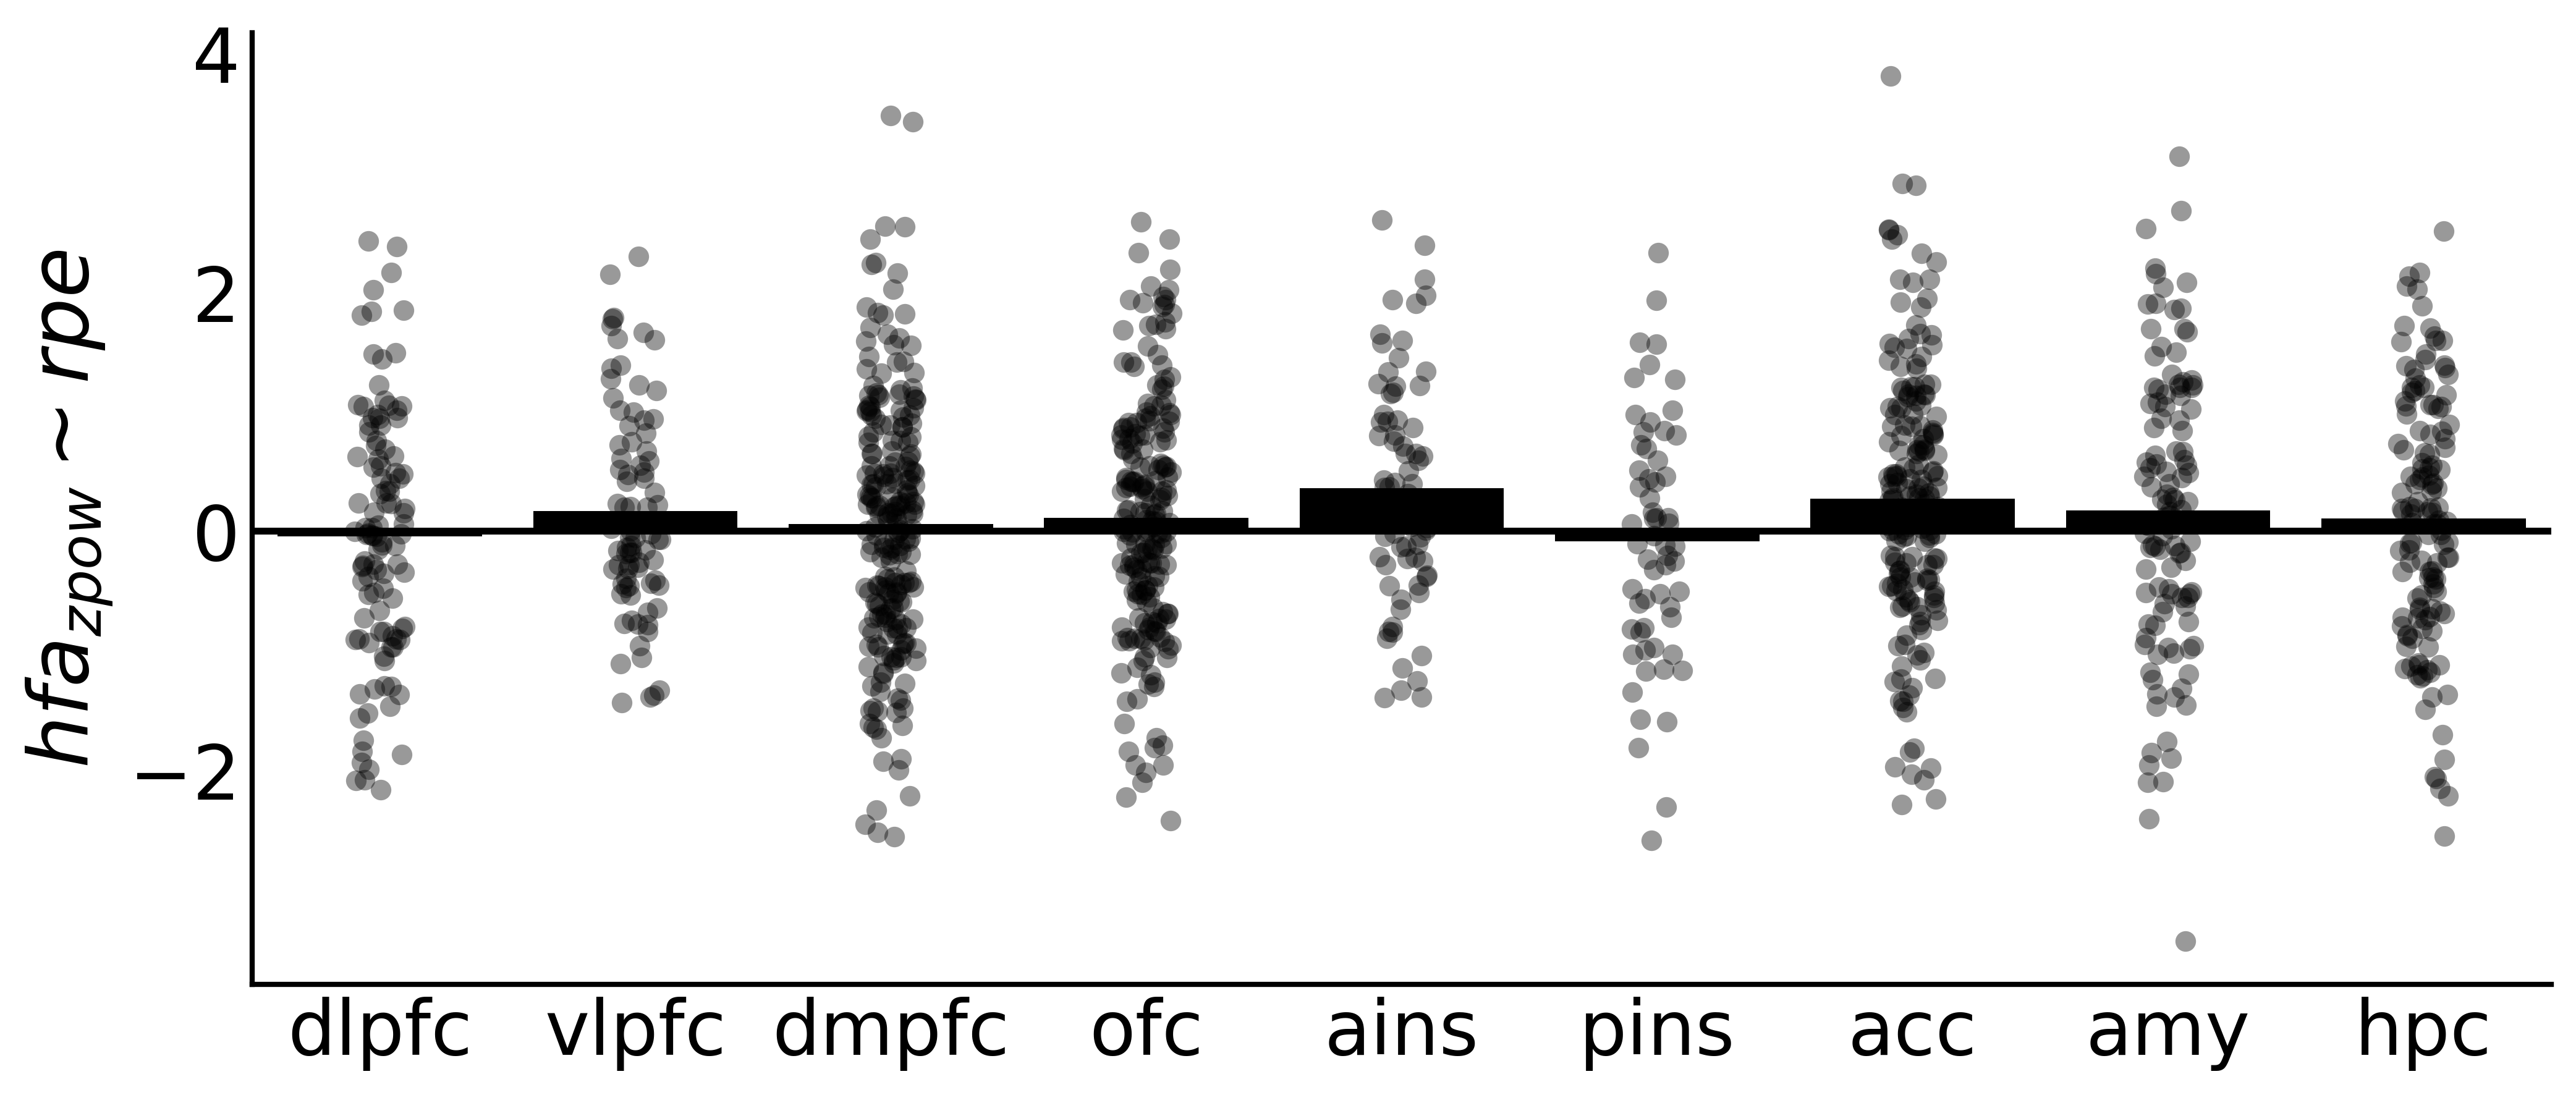

In [55]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

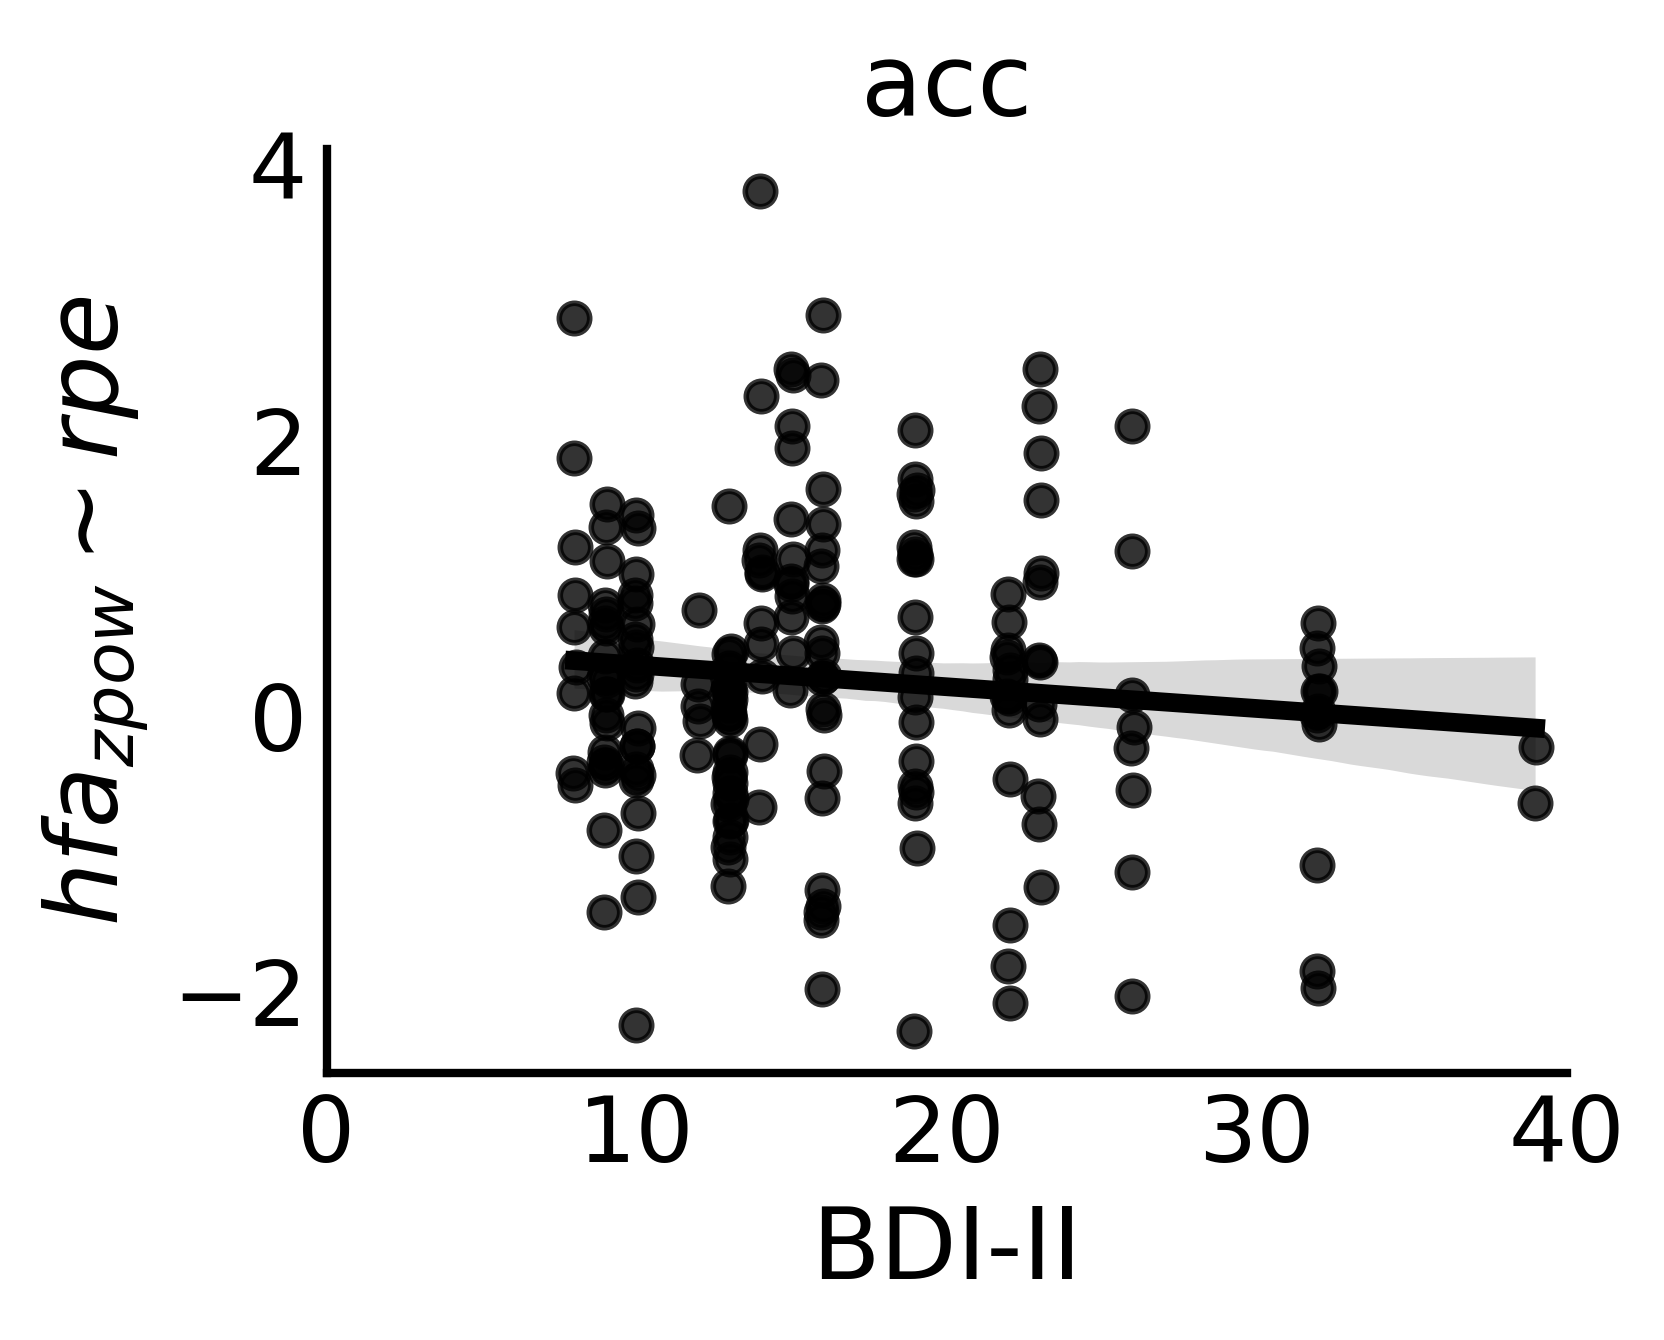

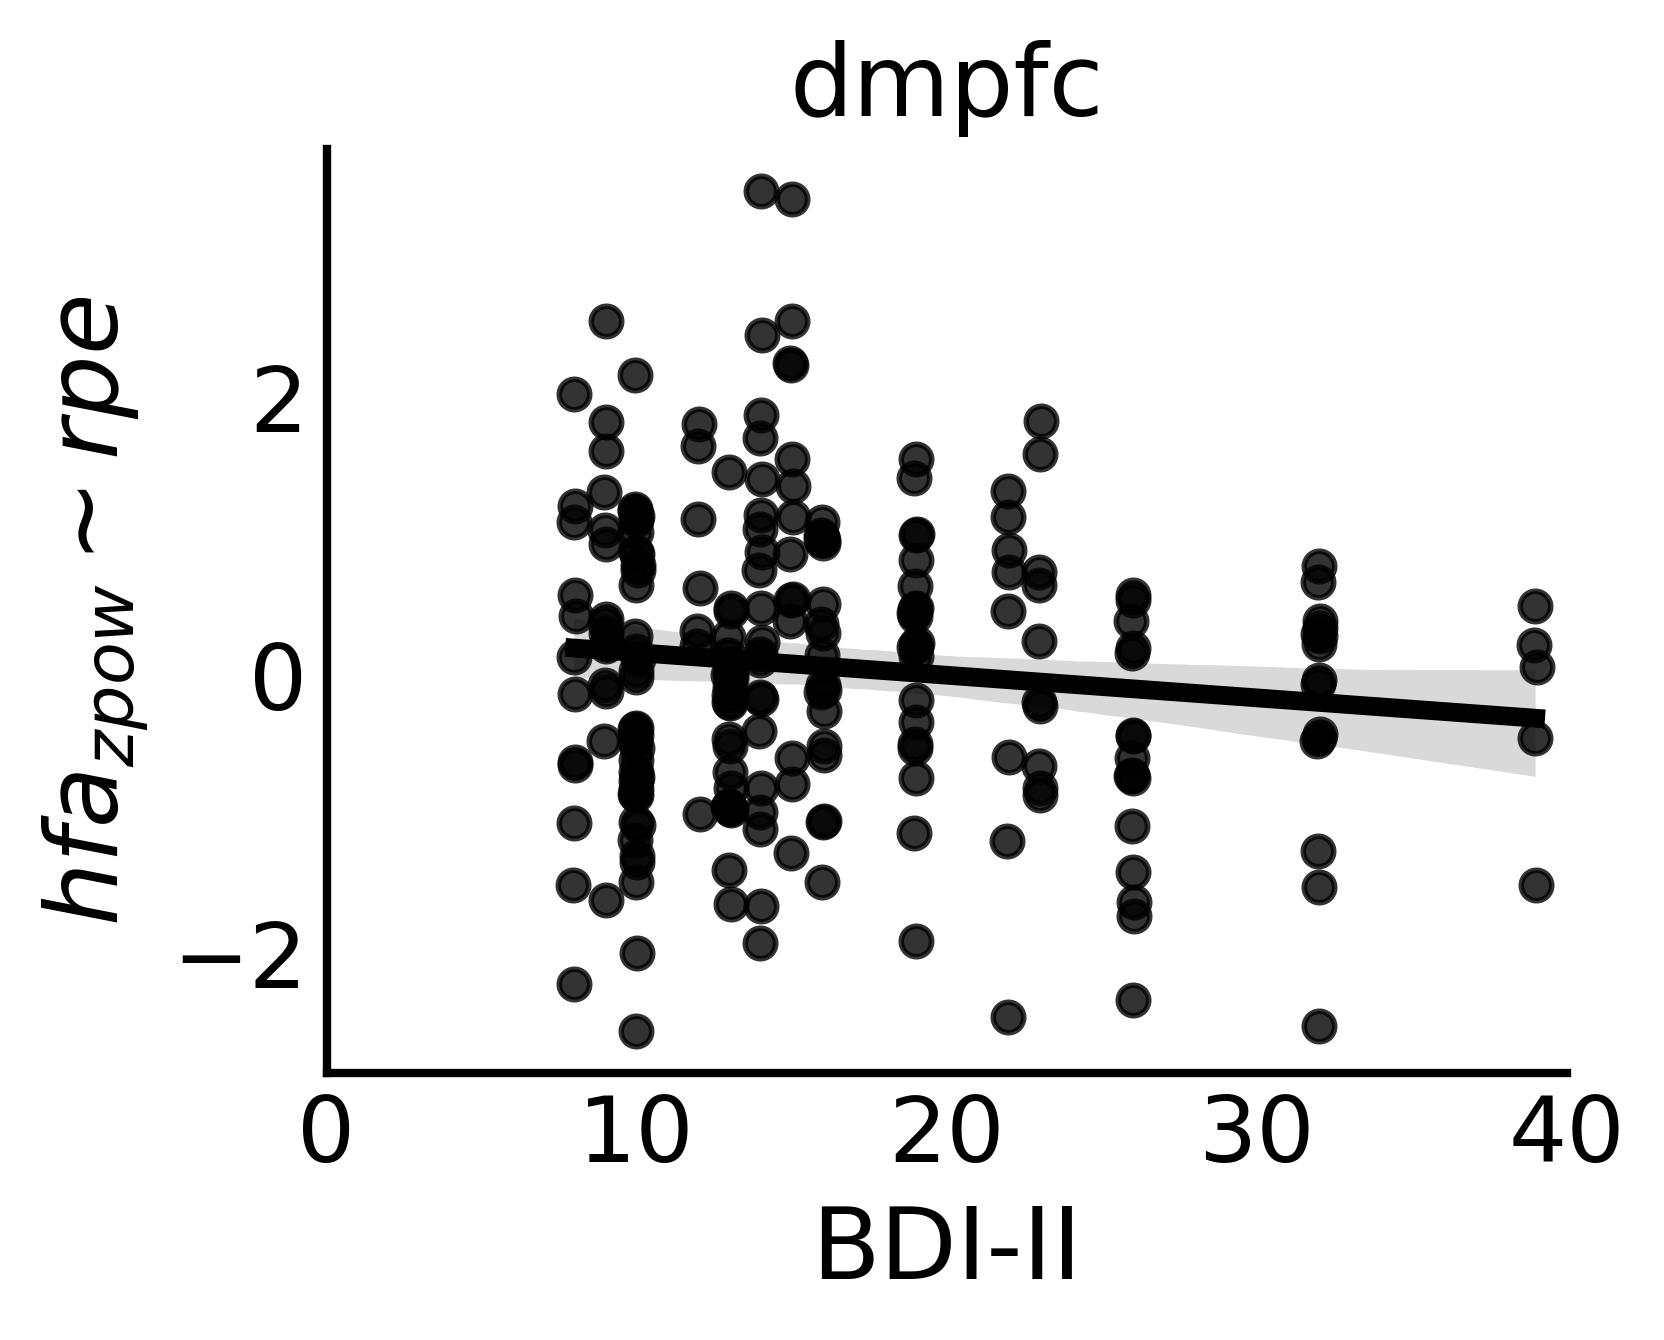

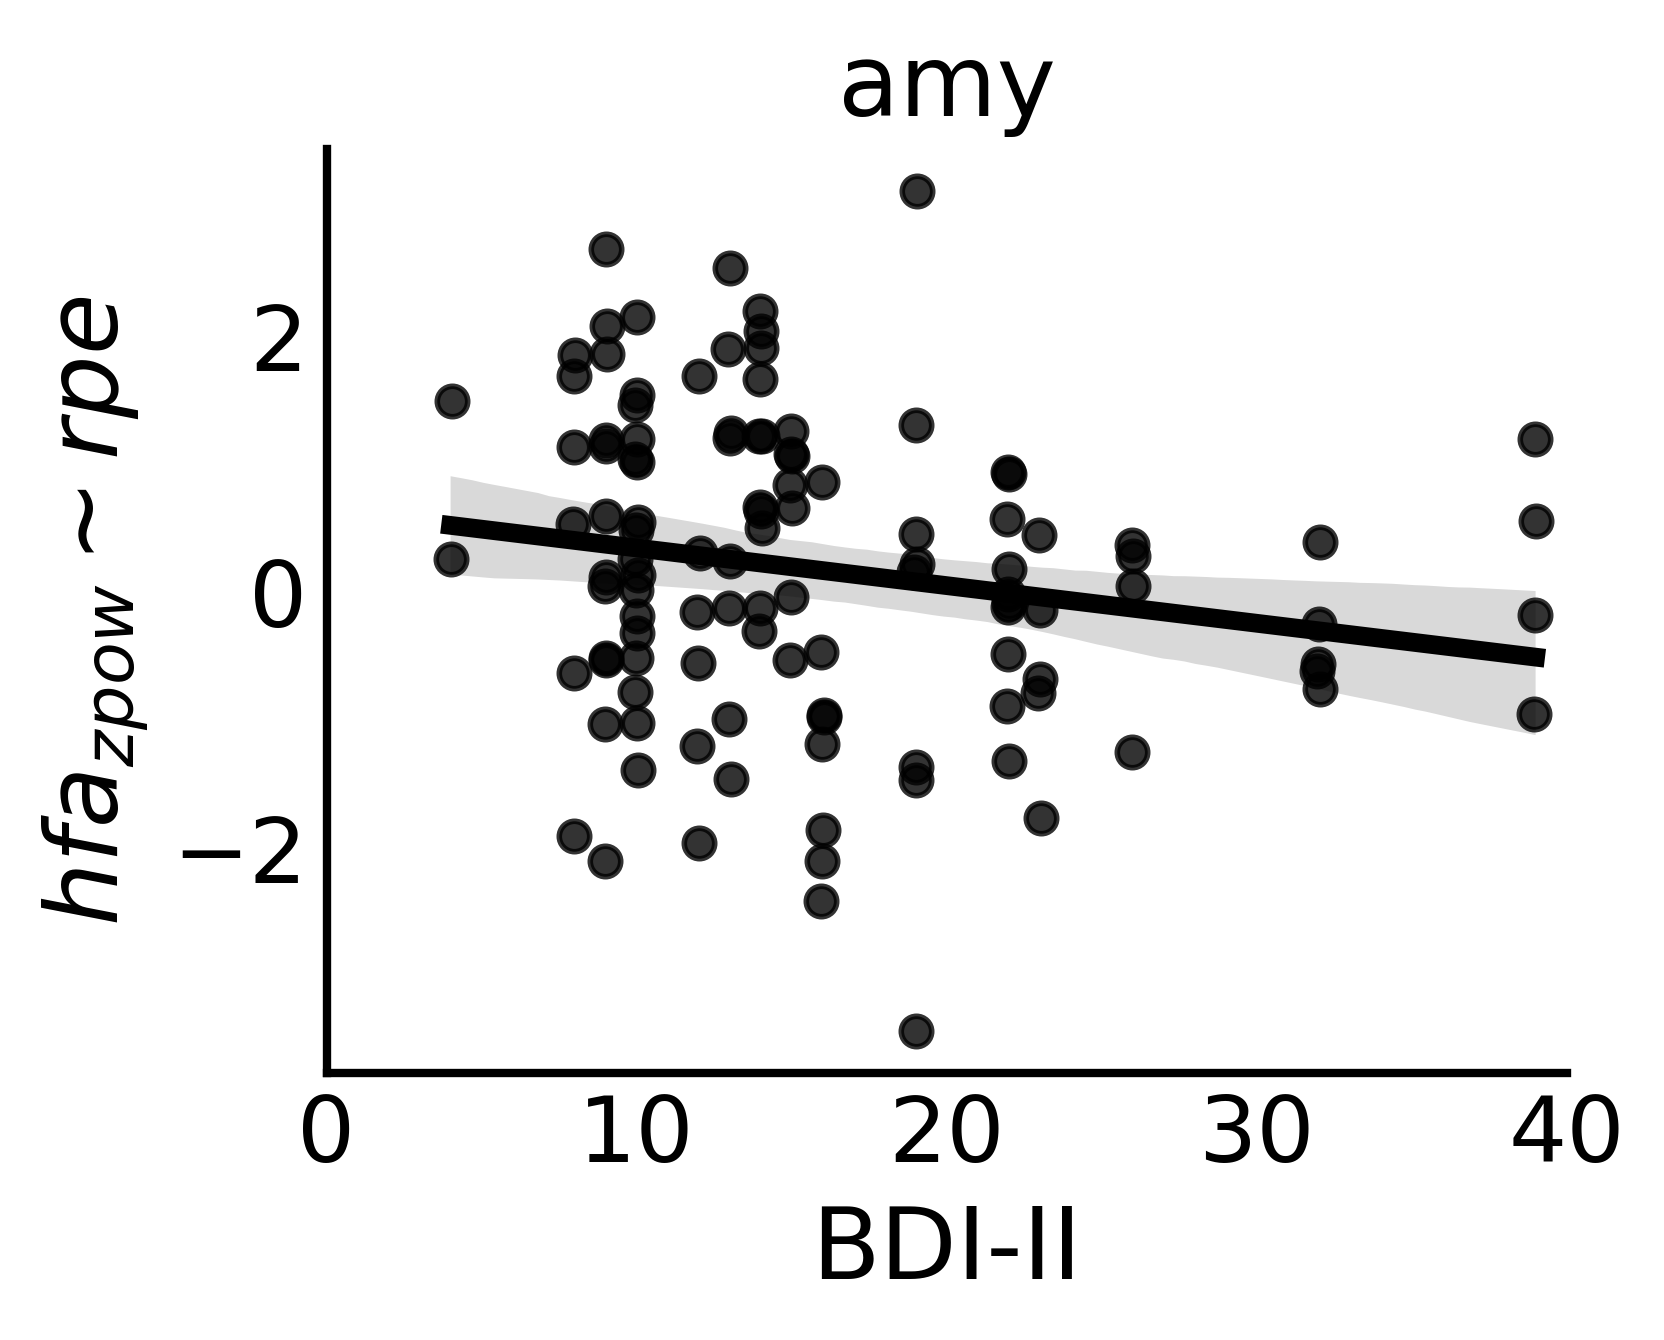

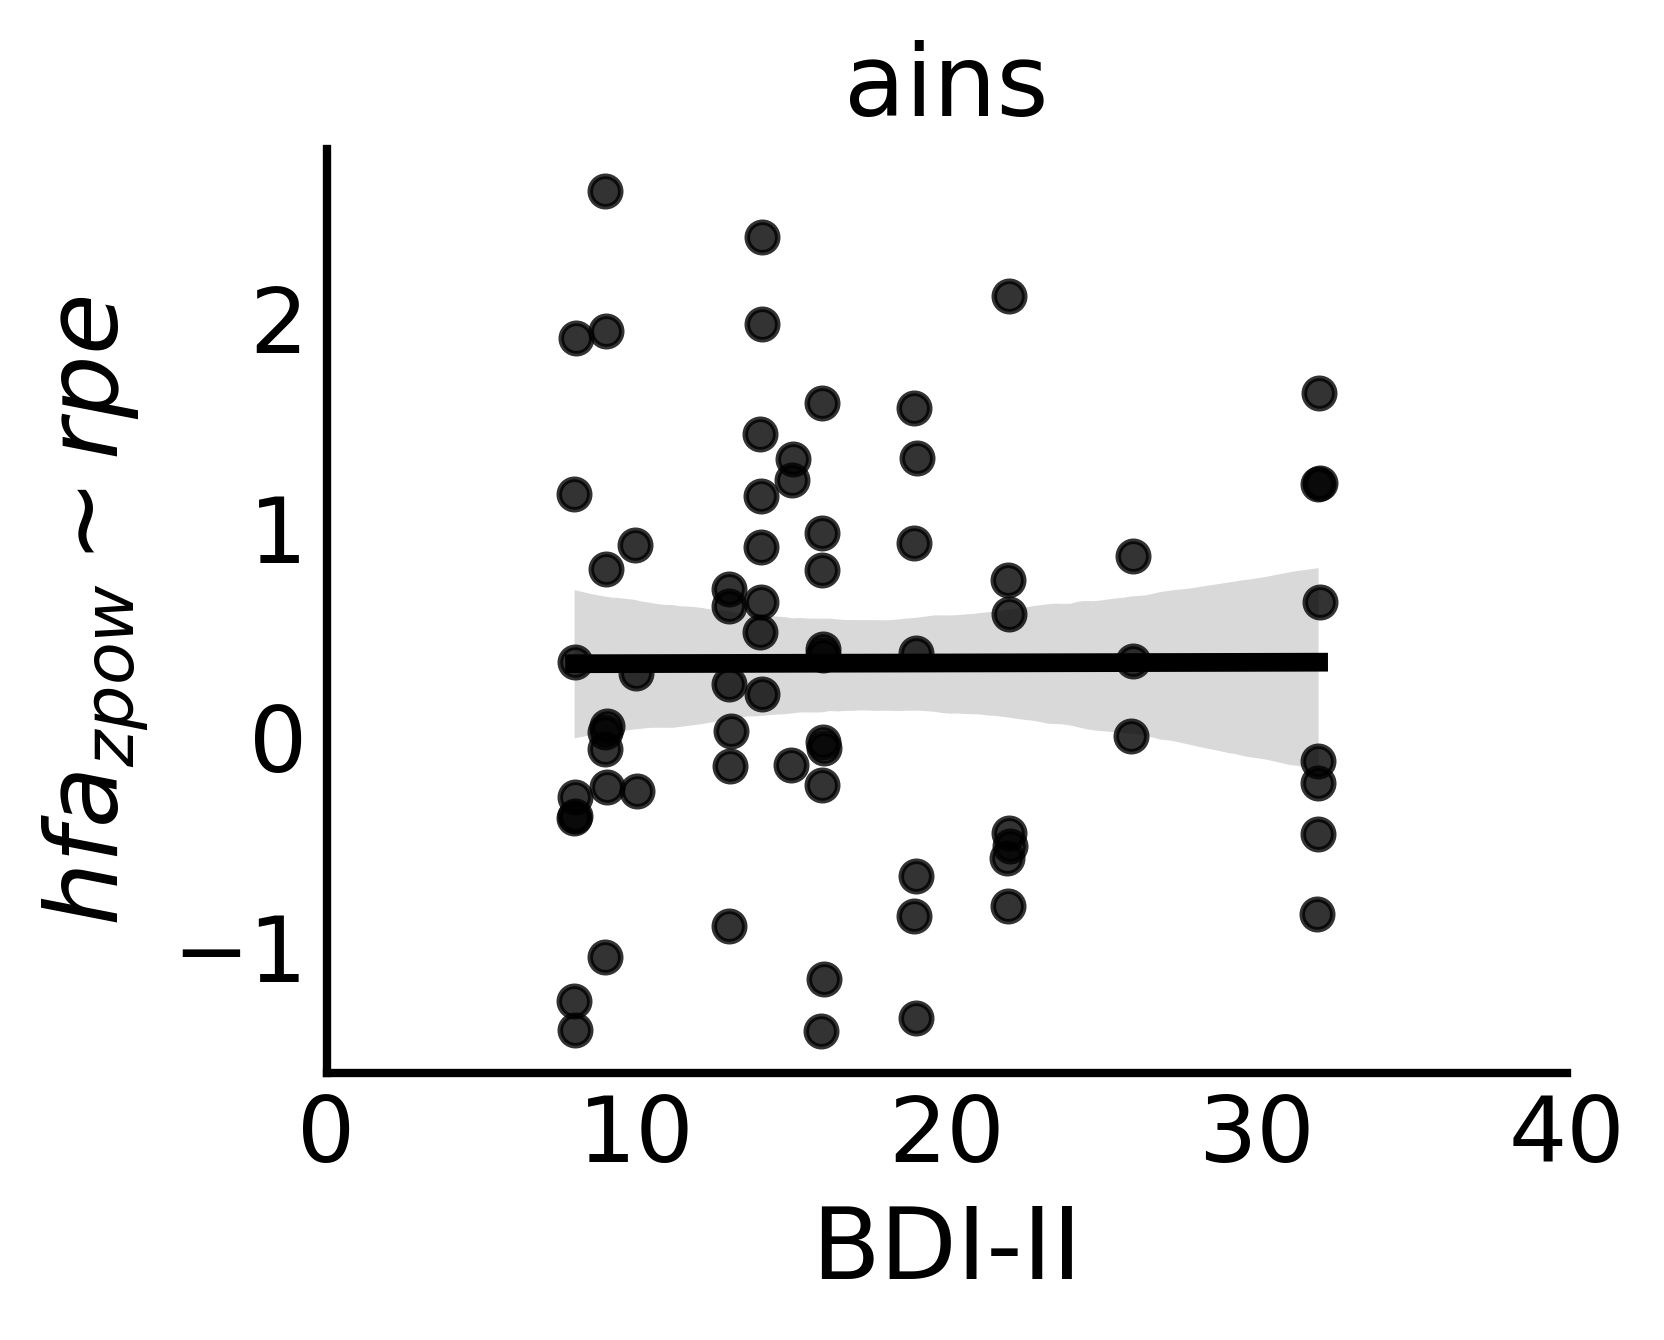

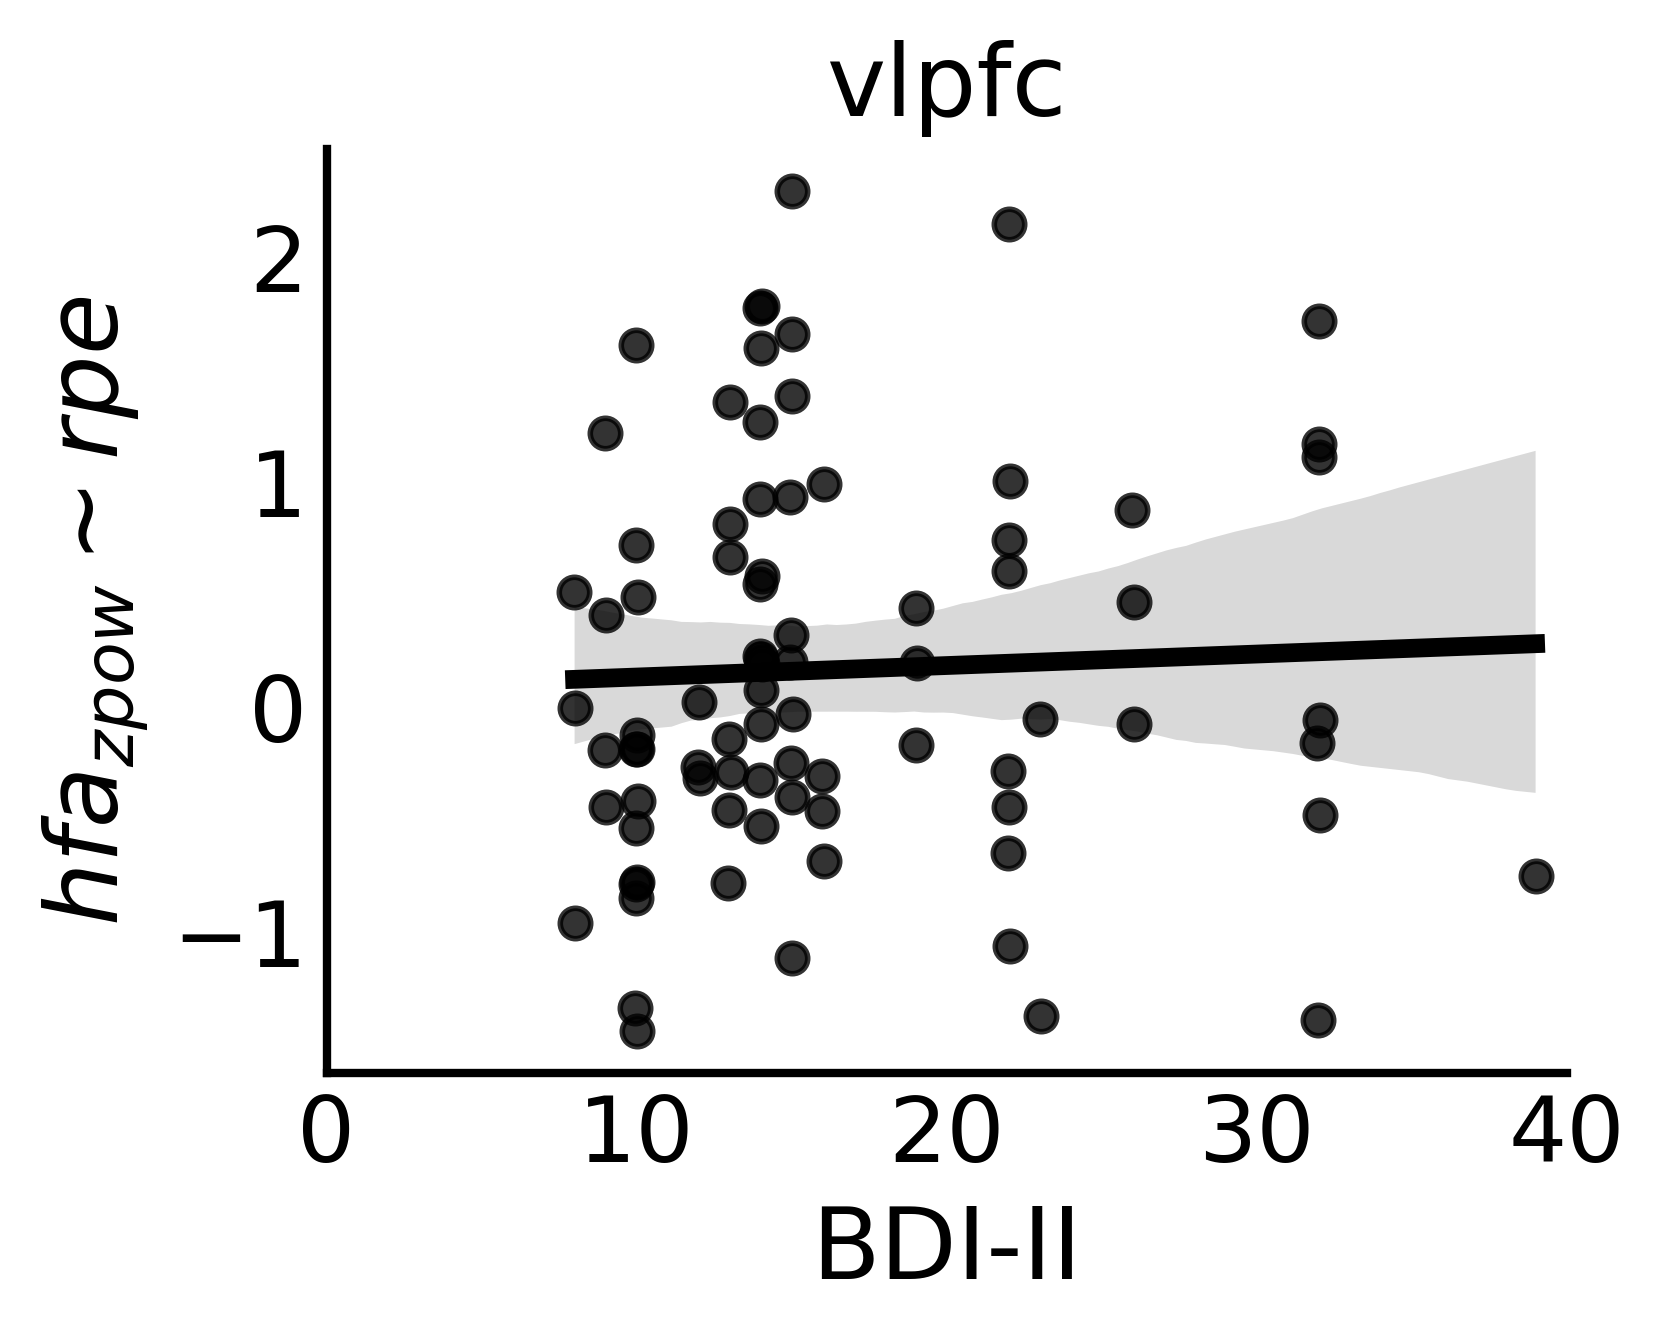

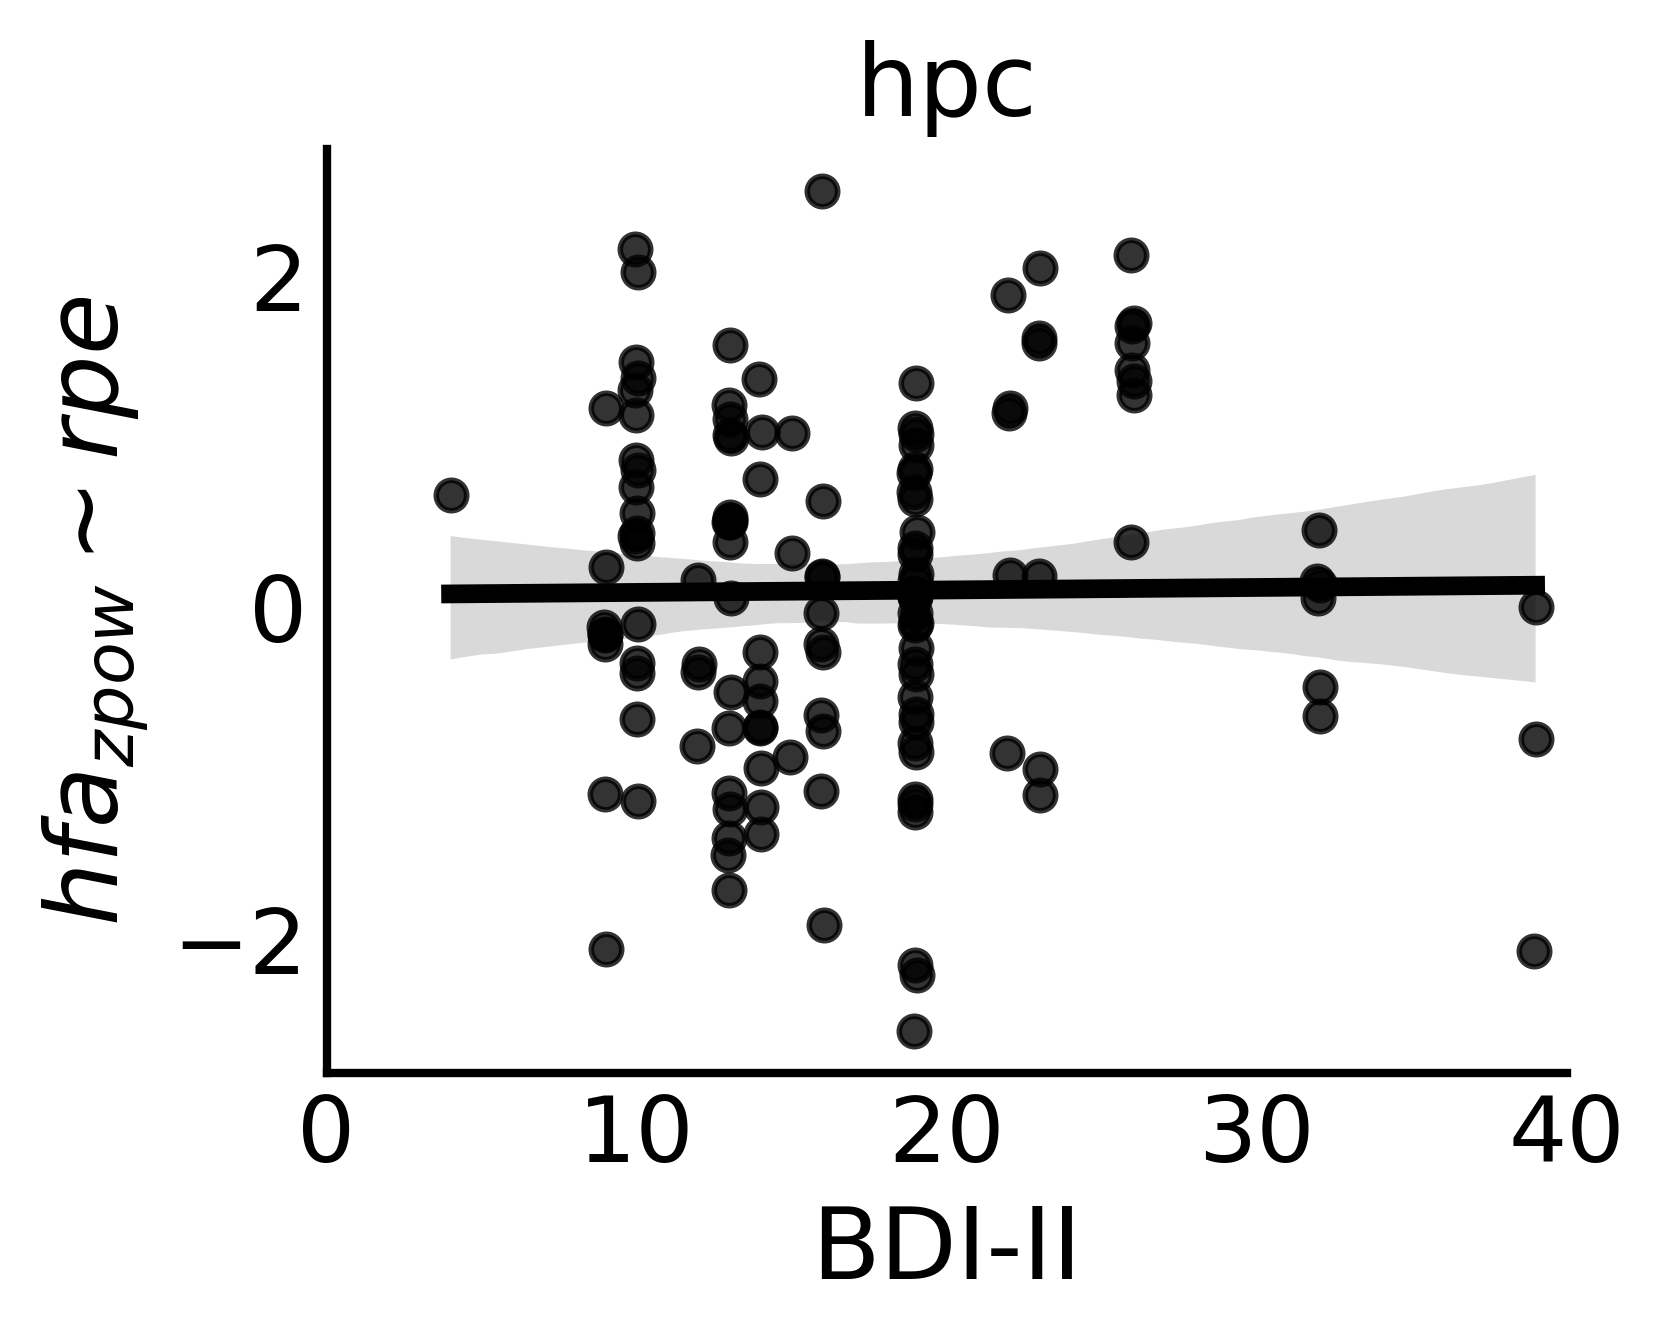

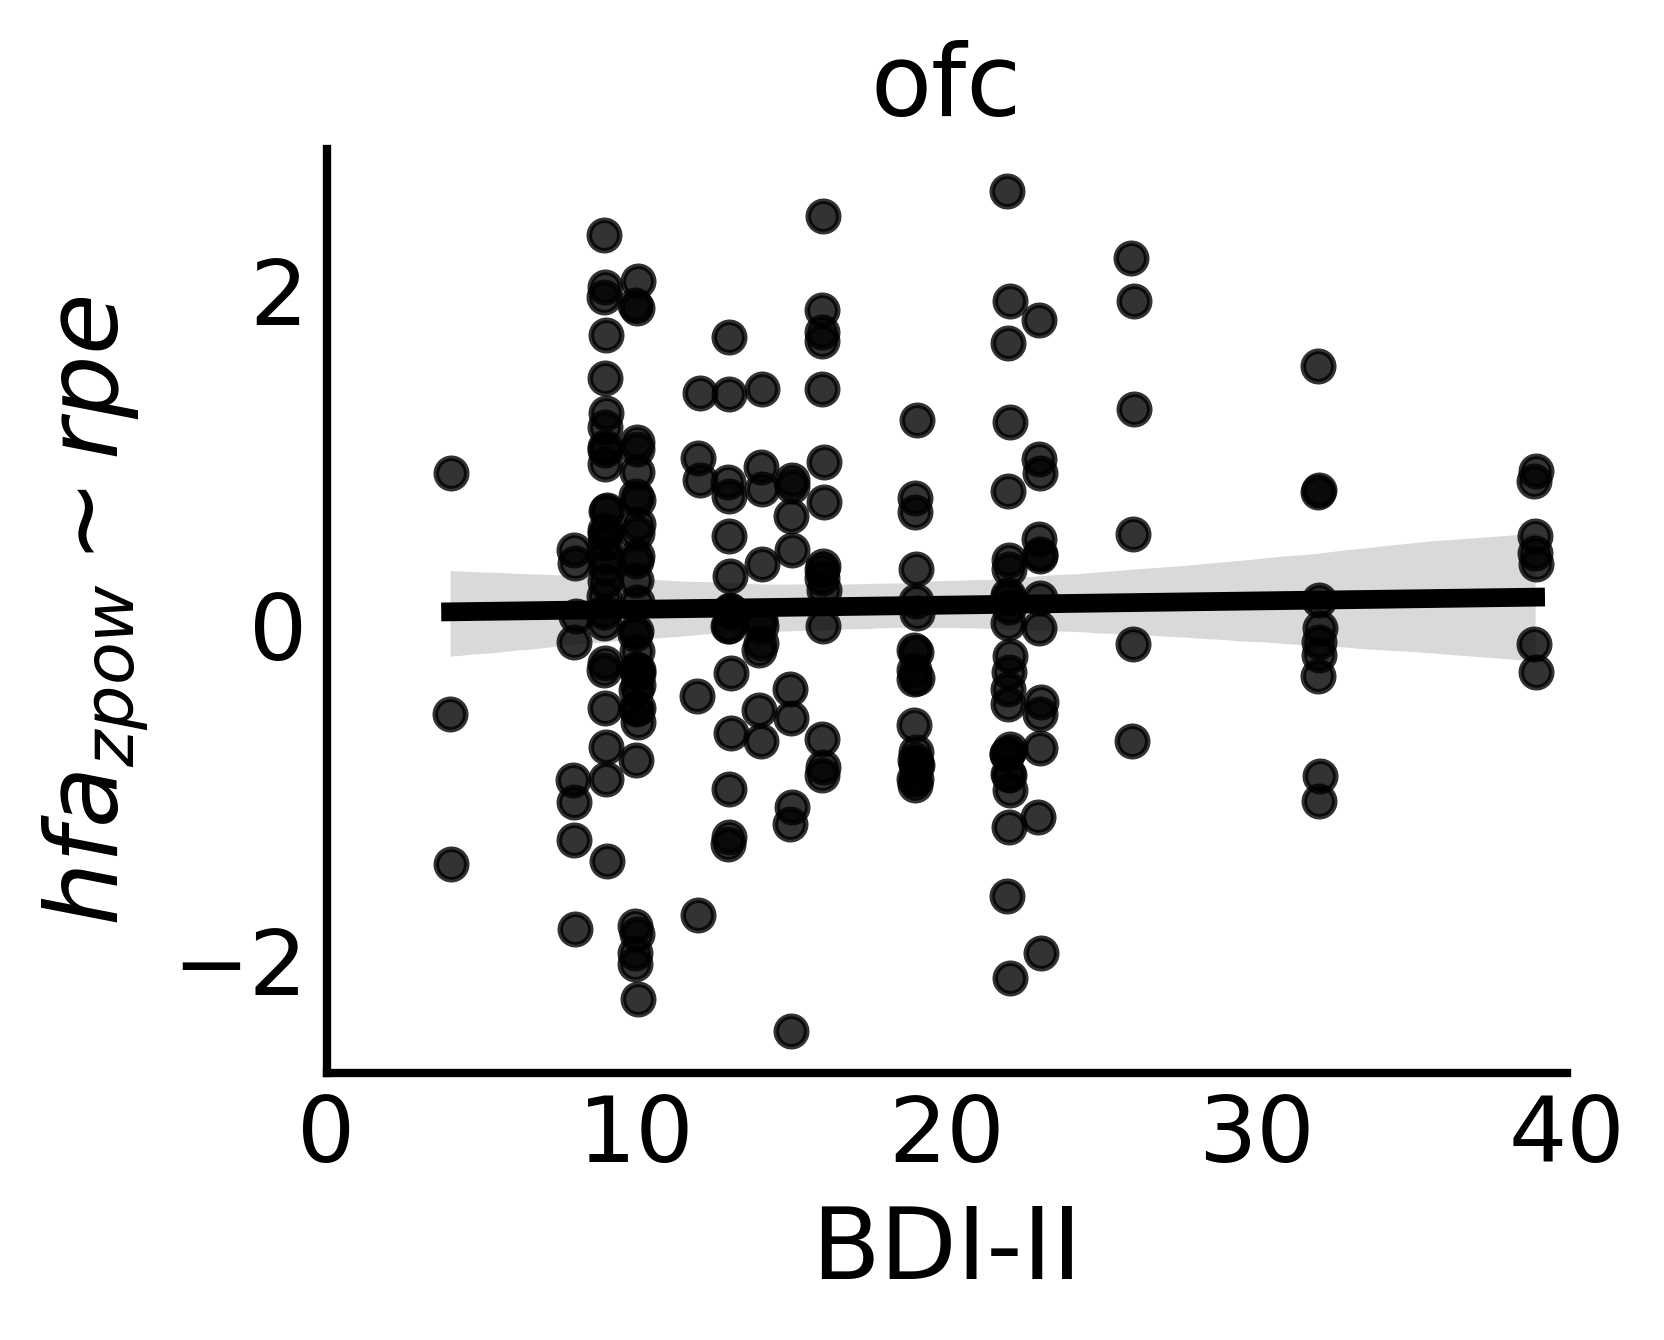

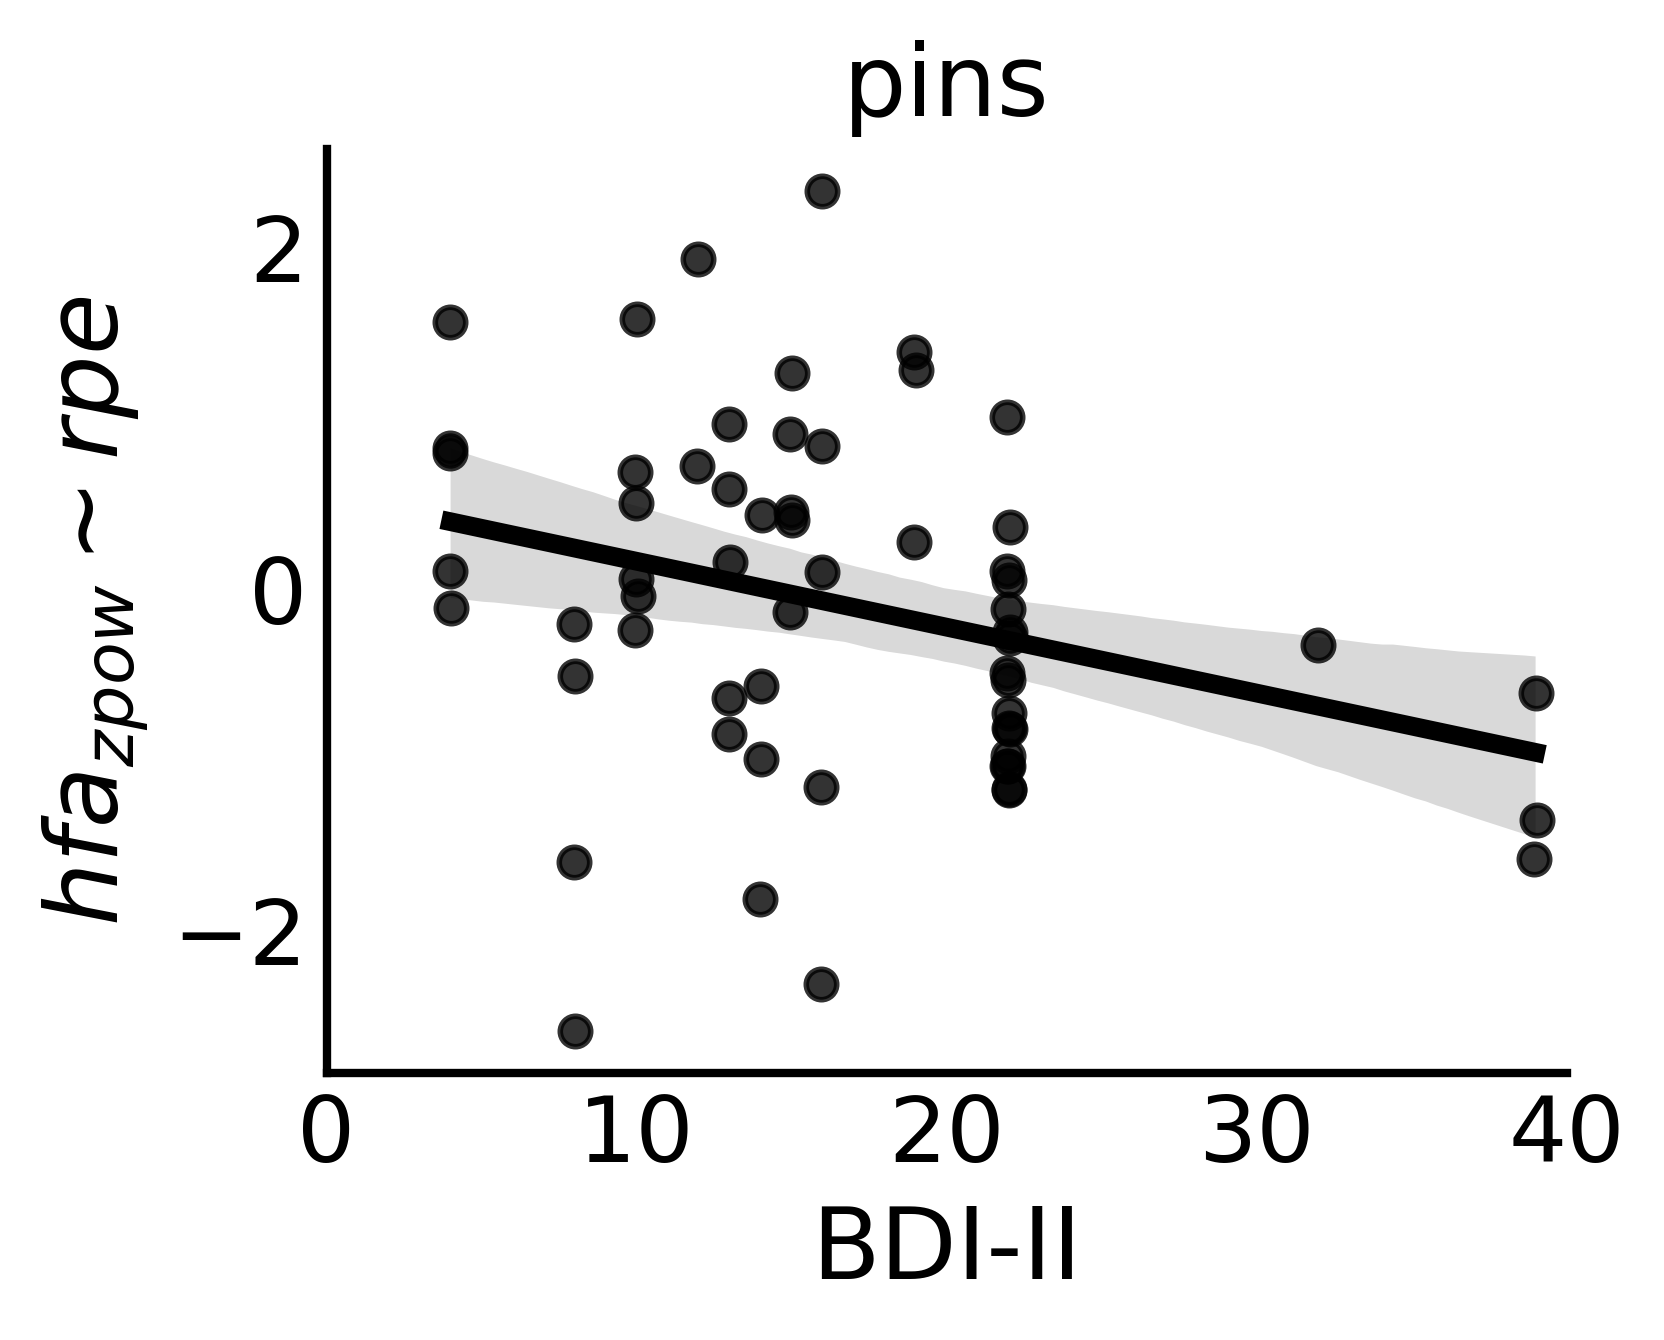

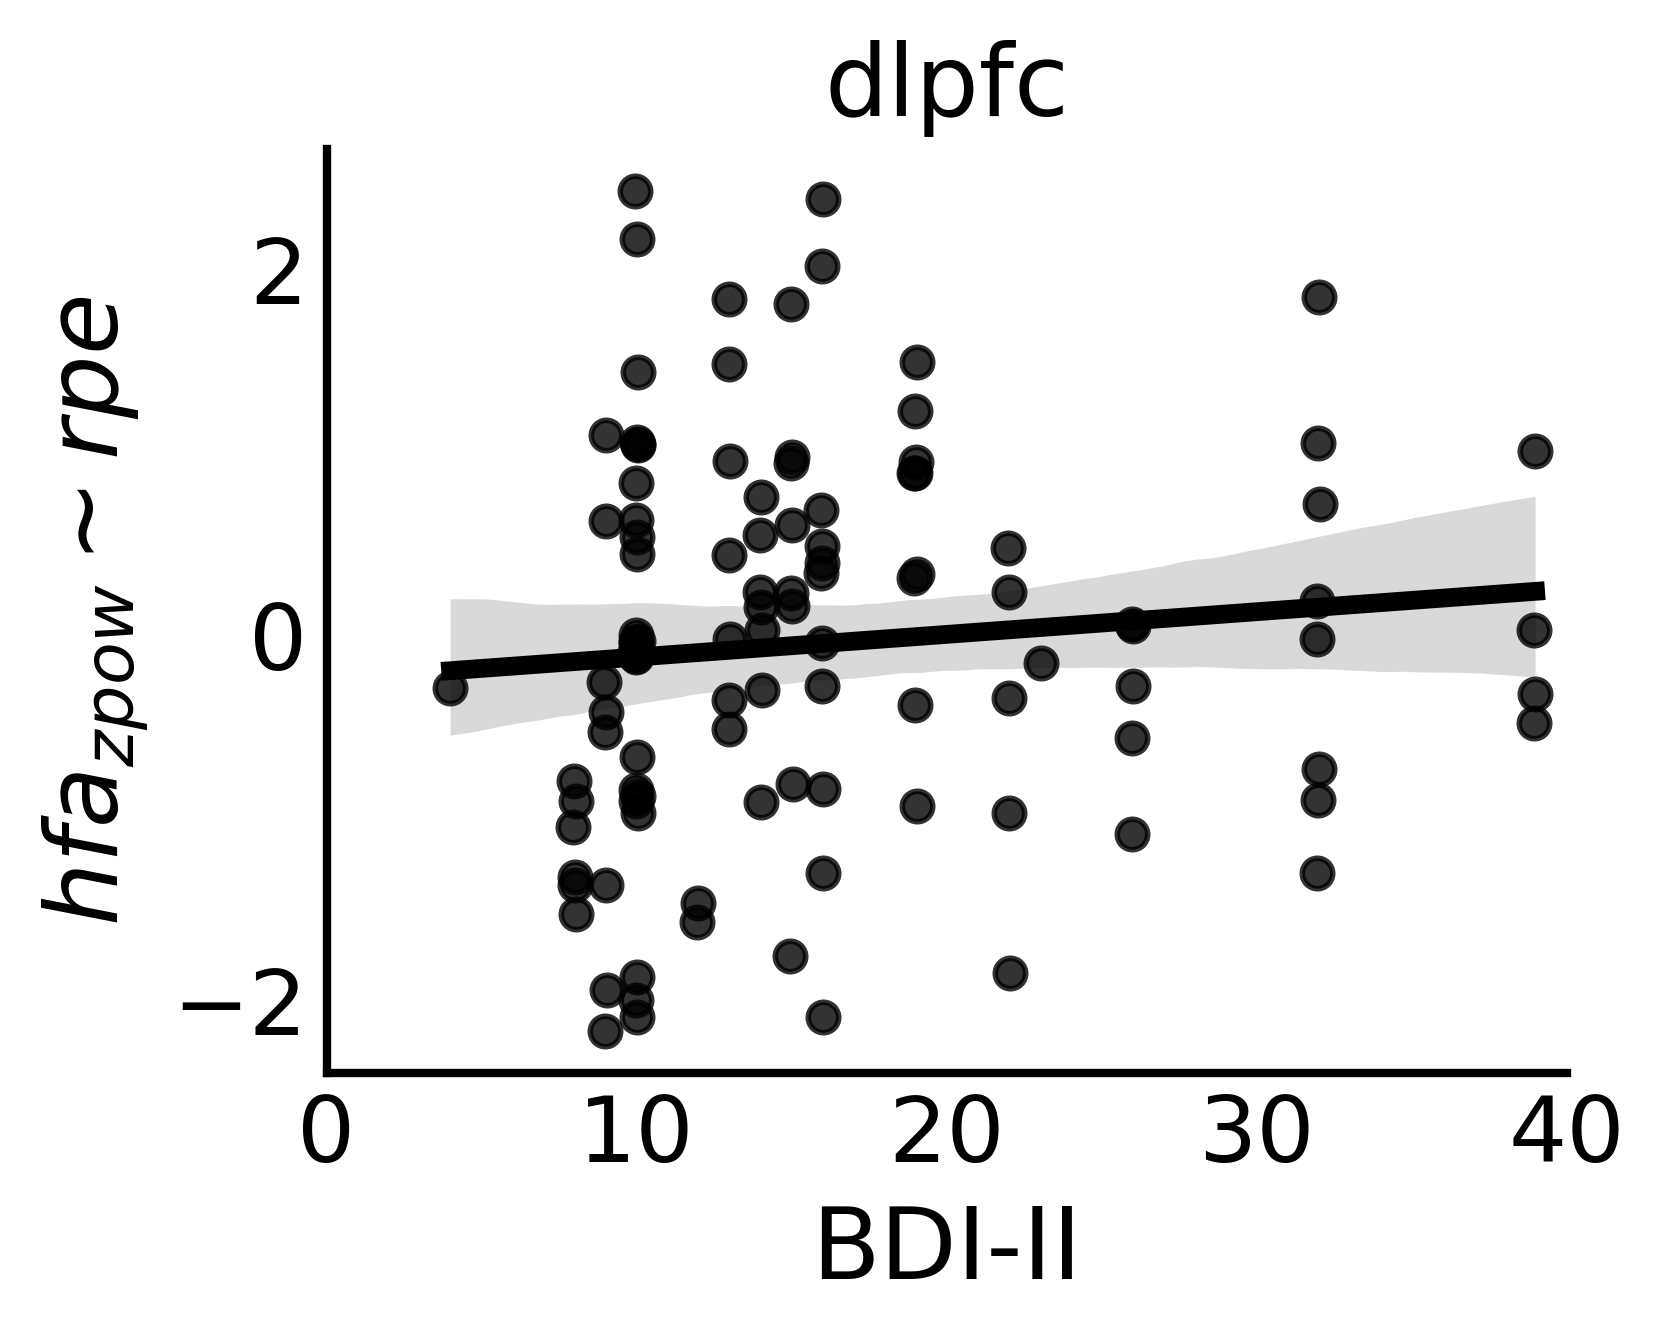

In [56]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_rpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [57]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:13:37                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9737      0.456     35.014     

In [59]:
# del rpe_var

# Profit Results

In [60]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
57    MS002_ragit3-ragit4   MS002    amy   14                     0.009820   
75    MS002_rmoif8-rmoif9   MS002  vlpfc   14                     0.067647   
91    MS003_lmcms8-lmcms9   MS003  dmpfc    8                     0.007339   
98    MS003_lsifo1-lsifo2   MS003   pins    8                     0.009099   
101   MS003_racas3-racas4   MS003    acc    8                     0.003888   
...                   ...     ...    ...  ...                          ...   
1128      DA023_lam1-lam2   DA023    amy   14                     0.006429   
1129      DA023_lam2-lam3   DA023    amy   14                    -0.014833   
1130      DA023_lam3-lam4   DA023    amy   14                    -0.019765   
1174      DA039_rof3-rof4   DA039    ofc   22                     0.029442   
1175      DA039_rof4-rof5   DA039    ofc   22                     0.021559   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
57                                  0.004157                   0.118375   
75                                 -0.022188                   0.200264   
91                                 -0.047734                  -0.175234   
98                                 -0.028063                  -0.210195   
101                                 0.029952                   0.230465   
...                                      ...                        ...   
1128                               -0.041579                   0.184230   
1129                                0.006811                   0.138792   
1130                                0.001005                   0.139086   
1174                               -0.051256                  -0.226127   
1175                               -0.038314                  -0.119603   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
57                   -0.186568               0.092260               0.017155   
75                   -0.341737               0.182714               0.057014   
91                    0.334754              -0.263693              -0.044684   
98                    0.381514              -0.245668              -0.049819   
101                  -0.365759               0.291497               0.107664   
...                        ...                    ...                    ...   
1128                 -0.255251               0.162871               0.047488   
1129                 -0.196986               0.150878               0.041695   
1130                 -0.209493               0.086641               0.027272   
1174                  0.422122              -0.221840              -0.044994   
1175                  0.265580              -0.112518              -0.031092   

      ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
57    ...     0.781876           0.823969                      0.818428   
75    ...     1.357620           0.482858                      0.491652   
91    ...    -0.877908           0.049046                      0.055856   
98    ...    -1.142938           0.182111                      0.202538   
101   ...     2.461600           0.131684                      0.163448   
...   ...          ...                ...                           ...   
1128  ...     1.561774           0.093386                      0.082076   
1129  ...     1.705021           0.702786                      0.728888   
1130  ...     1.127324           0.858647                      0.923516   
1174  ...    -1.303960           0.036058                      0.050668   
1175  ...    -0.981842           0.095885                      0.089384   

      P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
57           0.054114        0.024215     0.095787     0.434287        0   
75           0.090383        0.026689     0.075676     0.174584        0   
91           0.075692        0.041488     0.026500     0.379994        0   
98     

In [61]:
sig_data.roi.value_counts()



roi
dmpfc    17
ofc      13
amy      12
dlpfc     9
acc       8
hpc       6
pins      3
ains      3
vlpfc     2
Name: count, dtype: int64

In [62]:
sig_data.roi.unique()



array(['amy', 'vlpfc', 'dmpfc', 'pins', 'acc', 'dlpfc', 'ofc', 'hpc',
       'ains'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [63]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031034   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032092   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.005977   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.013302   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.032526   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035142                  -0.071897   
1                               -0.048650                   0.015760   
2                               -0.003449                   0.048940   
3                               -0.017968                   0.024874   
4                               -0.028049                  -0.001730   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                  0.141211              -0.041192              -0.010996   
1                 -0.027349               0.046756               0.009386   
2                 -0.092906               0.062963              -0.004206   
3                 -0.061029               0.036638              -0.017527   
4                 -0.020265               0.066837              -0.026760   

   ...  P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0  ...           0.103893                      0.101696         0.317084   
1  ...           0.024827                      0.024834         0.836535   
2  ...           0.853894                      0.854619         0.439638   
3  ...           0.421938                      0.420153         0.759032   
4  ...           0.208895                      0.206623         0.996195   

   P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  \
0        0.140948     0.508718     0.659287        0          0        0   
1        0.792697     0.500510     0.751128        0          0        0   
2        0.271316     0.256224     0.862071        0          0        0   
3        0.566146     0.601849     0.478810        0          0        0   
4        0.819911     0.294077     0.327142        0          0        0   

   Profit_sig  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 38 columns]

In [64]:
Profit_var = 'Z_Score_Profit'

In [65]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [66]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.151230
vlpfc   -0.240806
dmpfc   -0.095495
ofc      0.057121
ains    -0.309218
pins     0.125102
acc     -0.125851
amy     -0.118898
hpc     -0.038181
Name: Z_Score_Profit, dtype: float64

In [67]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [68]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      8  0.041451              3   -1.764647    0.079213   
1  dmpfc      225     17  0.075556              5   -1.283340    0.200699   
2    amy      113     12  0.106195              0   -1.058716    0.292007   
3   ains       71      3  0.042254              1   -2.848302    0.005766   
4  vlpfc       82      2  0.024390              1   -2.391532    0.019096   
5    hpc      135      6  0.044444              0   -0.426643    0.670324   
6    ofc      202     13  0.064356              6    0.755654    0.450741   
7   pins       60      3  0.050000              1    0.977483    0.332321   
8  dlpfc      107      9  0.084112              1    1.458932    0.147541   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.020790            1.0    0.041451      0.7534  
1      0.048712            1.0    0.075556      0.0607  
2      0.062428            1.0    0.106195      0.0111  
3      0.011614            1.0    0.042254      0.6955  
4      0.004351            1.0    0.024390      0.9208  
5      0.019530            1.0    0.044444      0.6724  
6      0.038484            1.0    0.064356      0.2132  
7      0.013765            1.0    0.050000      0.5826  
8      0.044581            1.0    0.084112      0.0880

In [69]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
2  amy      113     12  0.106195              0   -1.058716    0.292007   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
2      0.062428            1.0    0.106195      0.0111

# Plot Results

In [70]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-Profit_coeff_barplot_{epoch_len}.pdf'


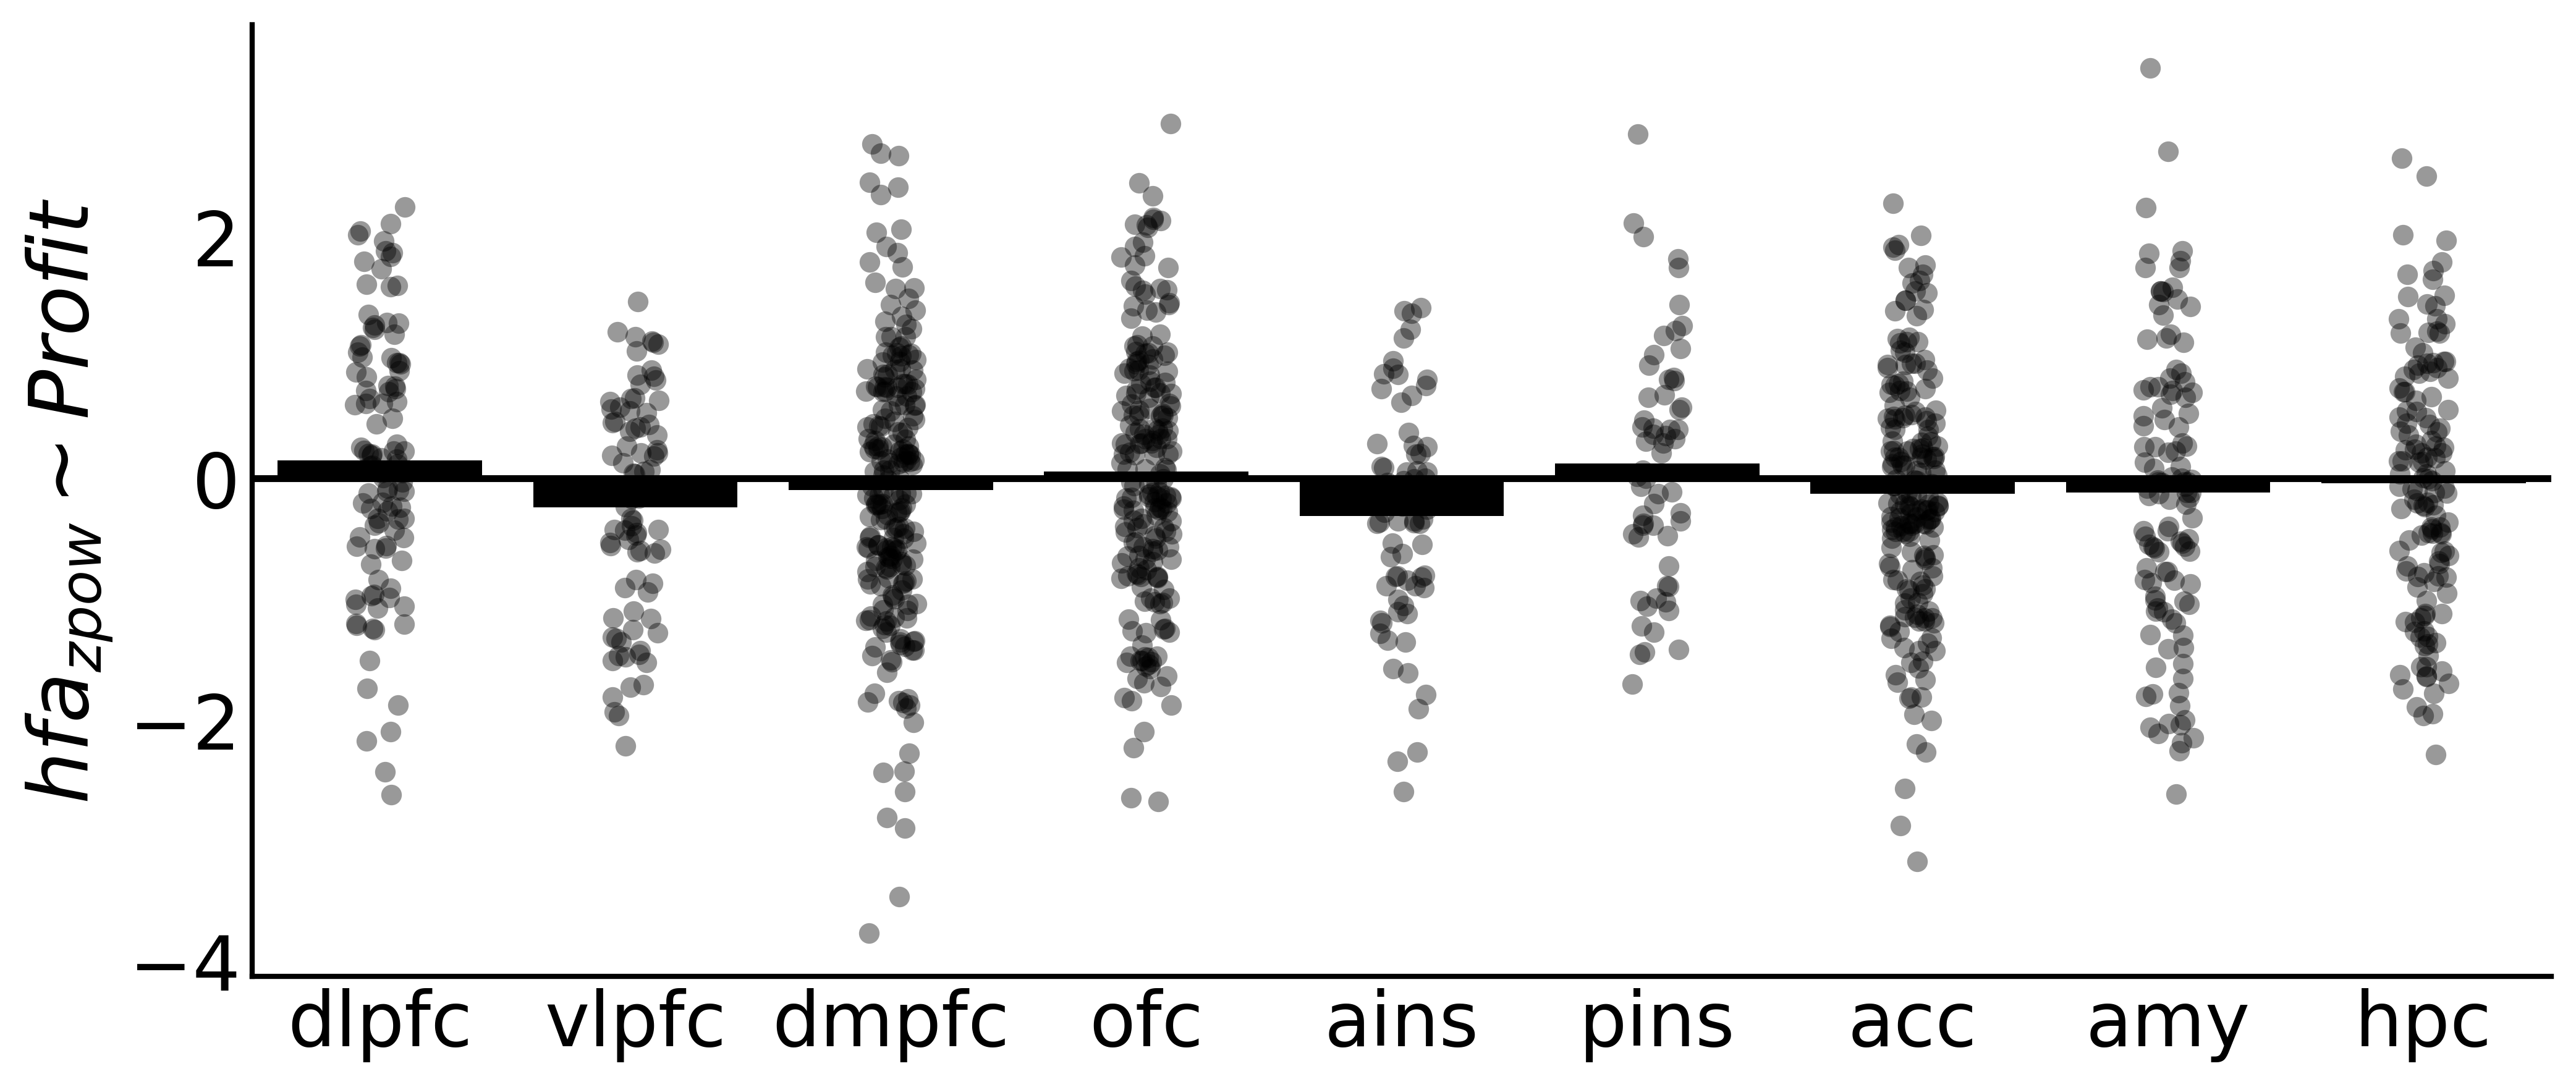

In [71]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim Profit$'


plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

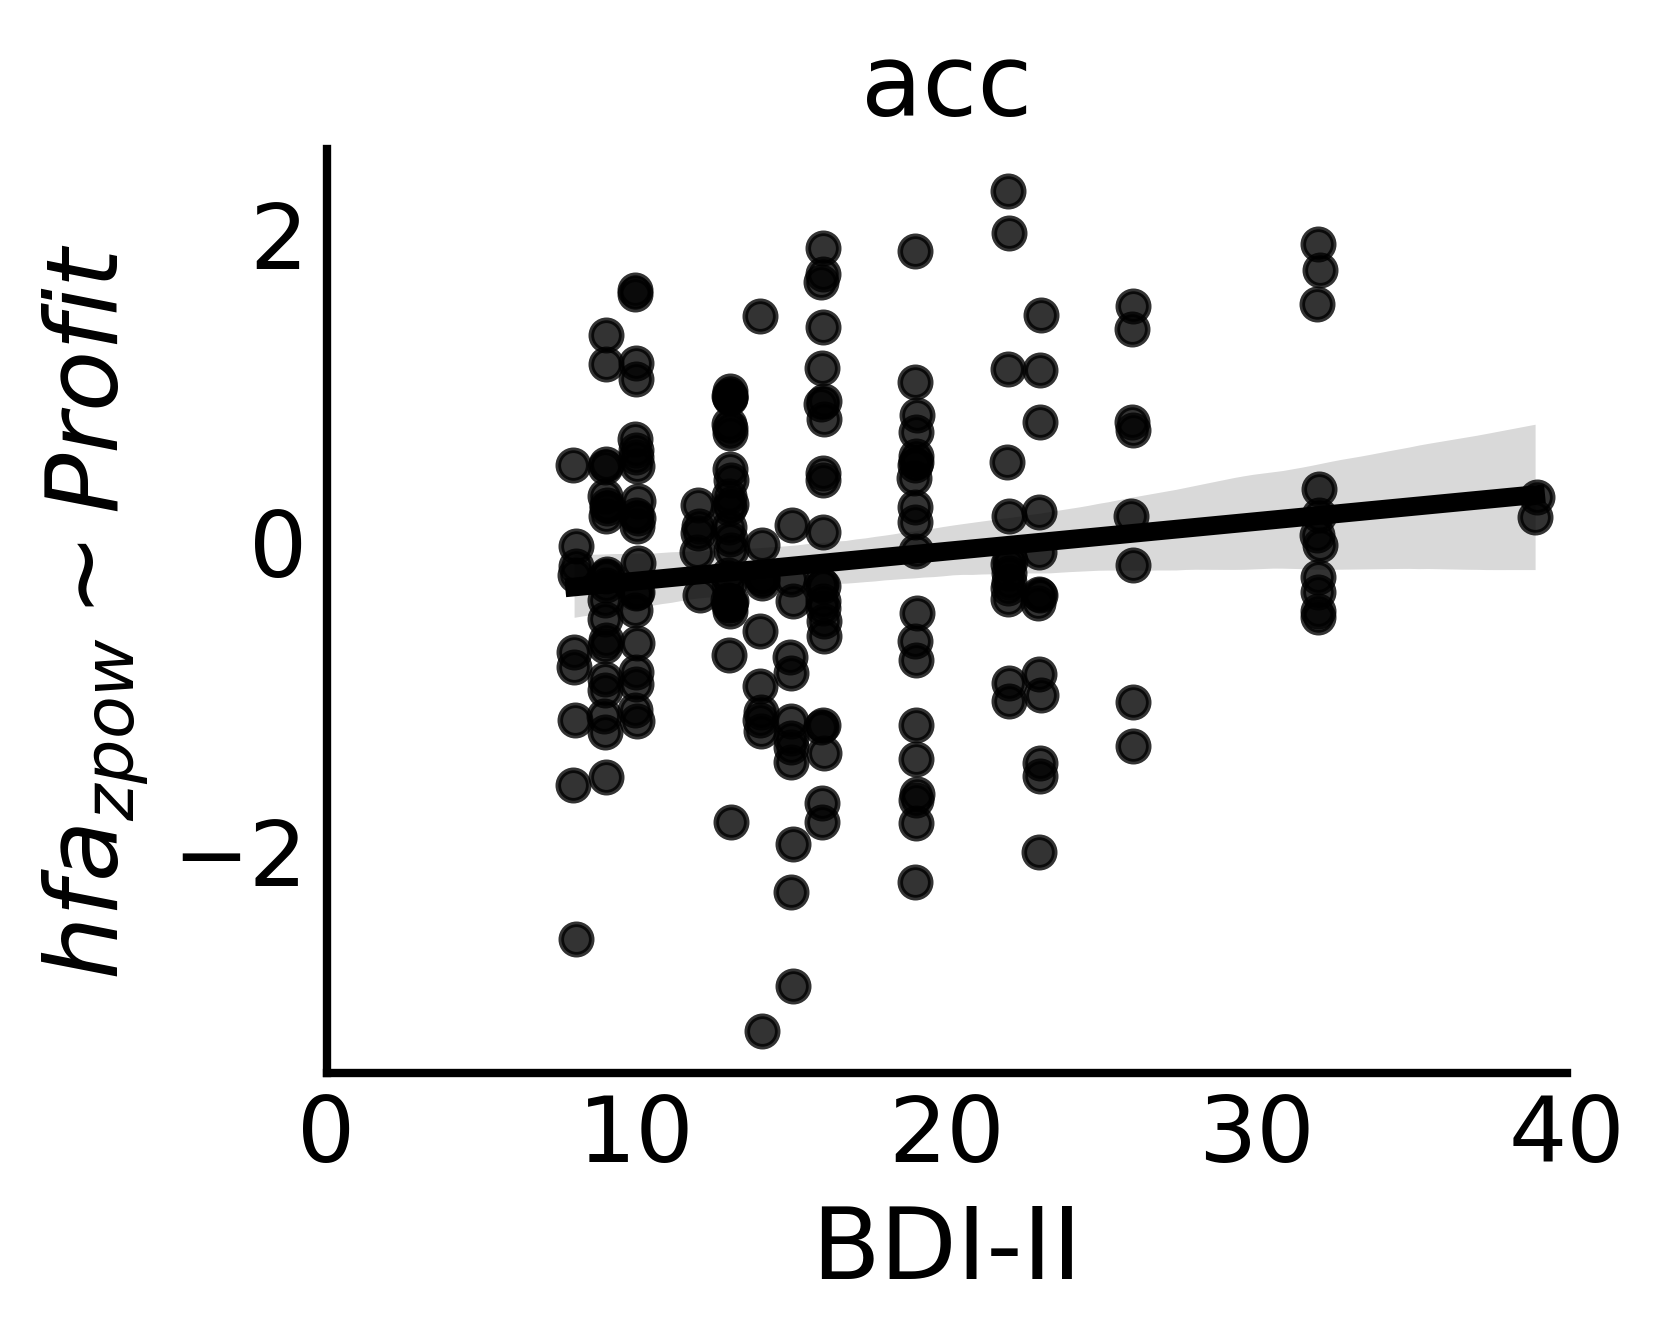

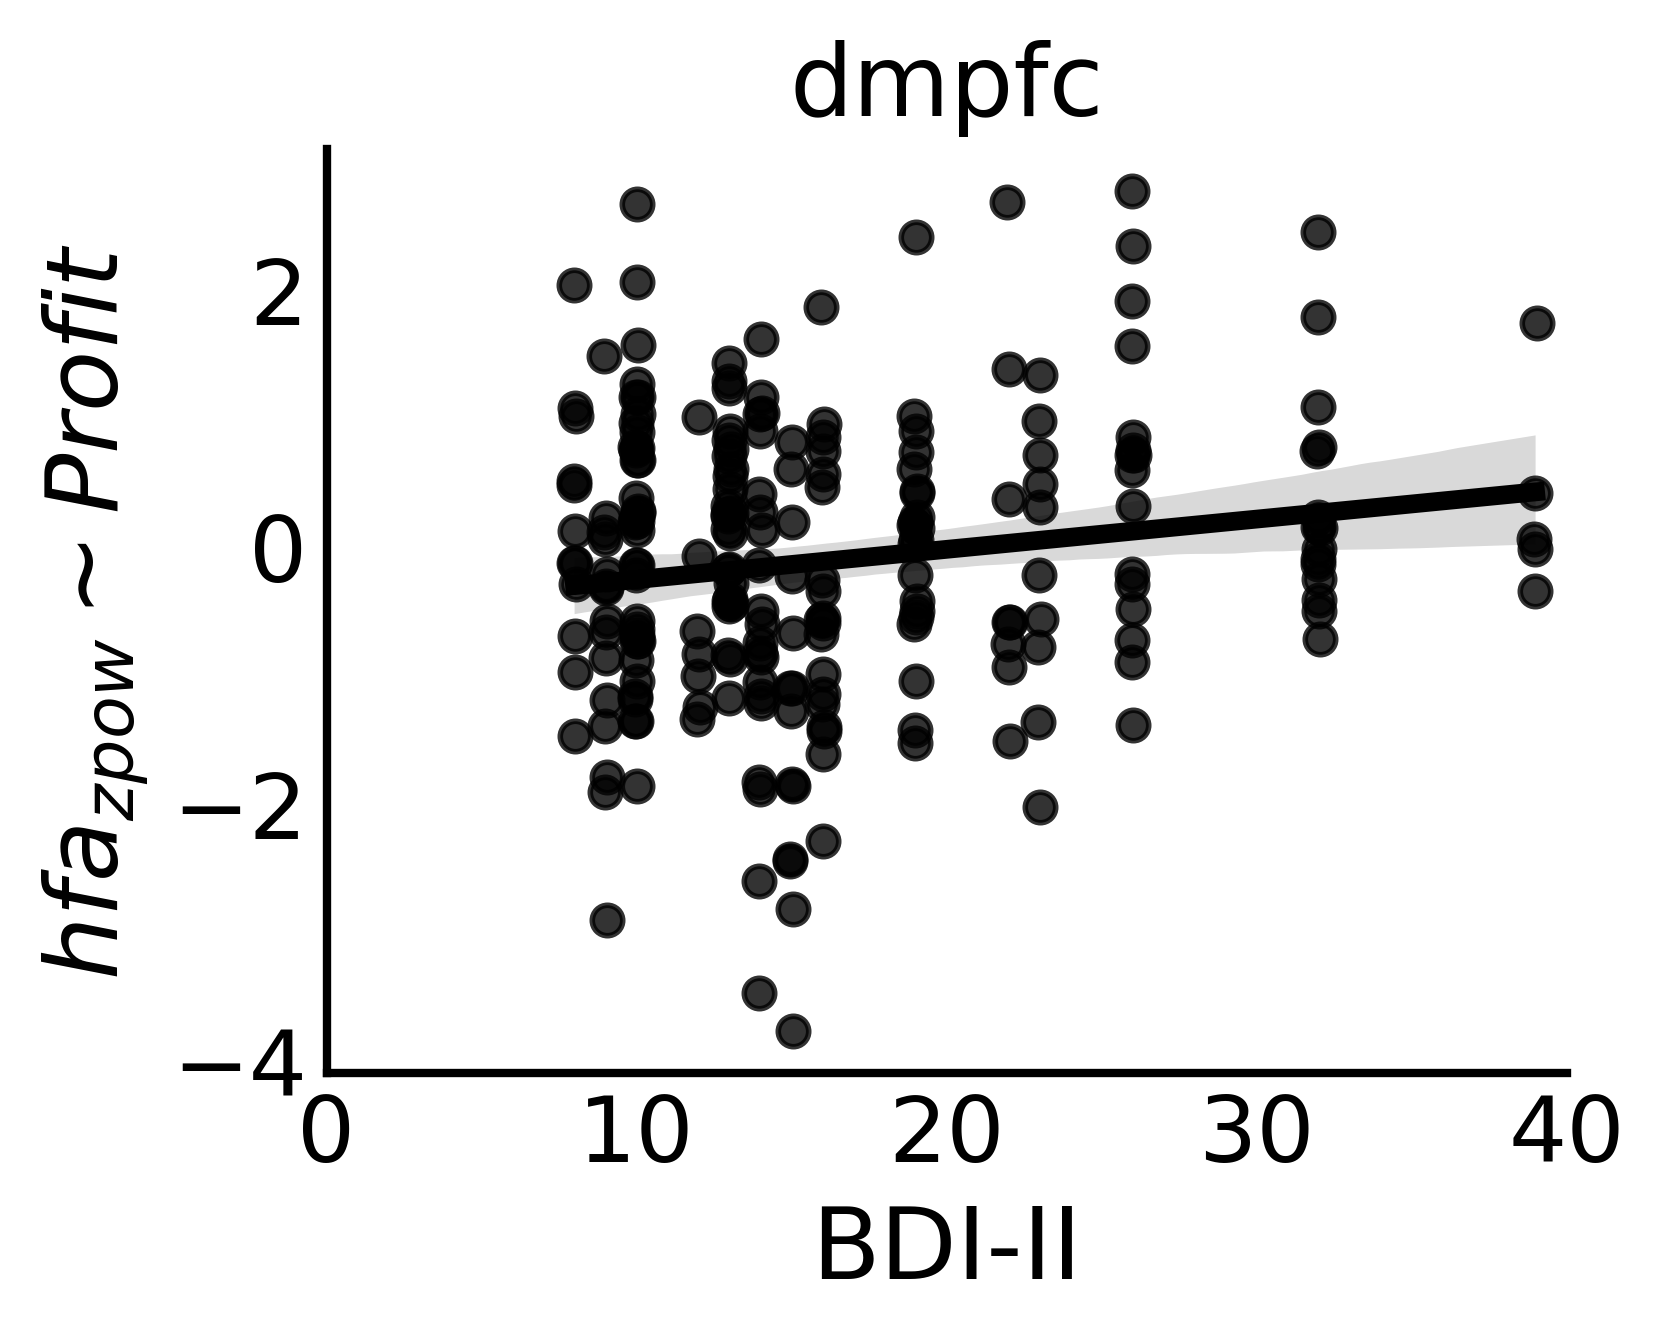

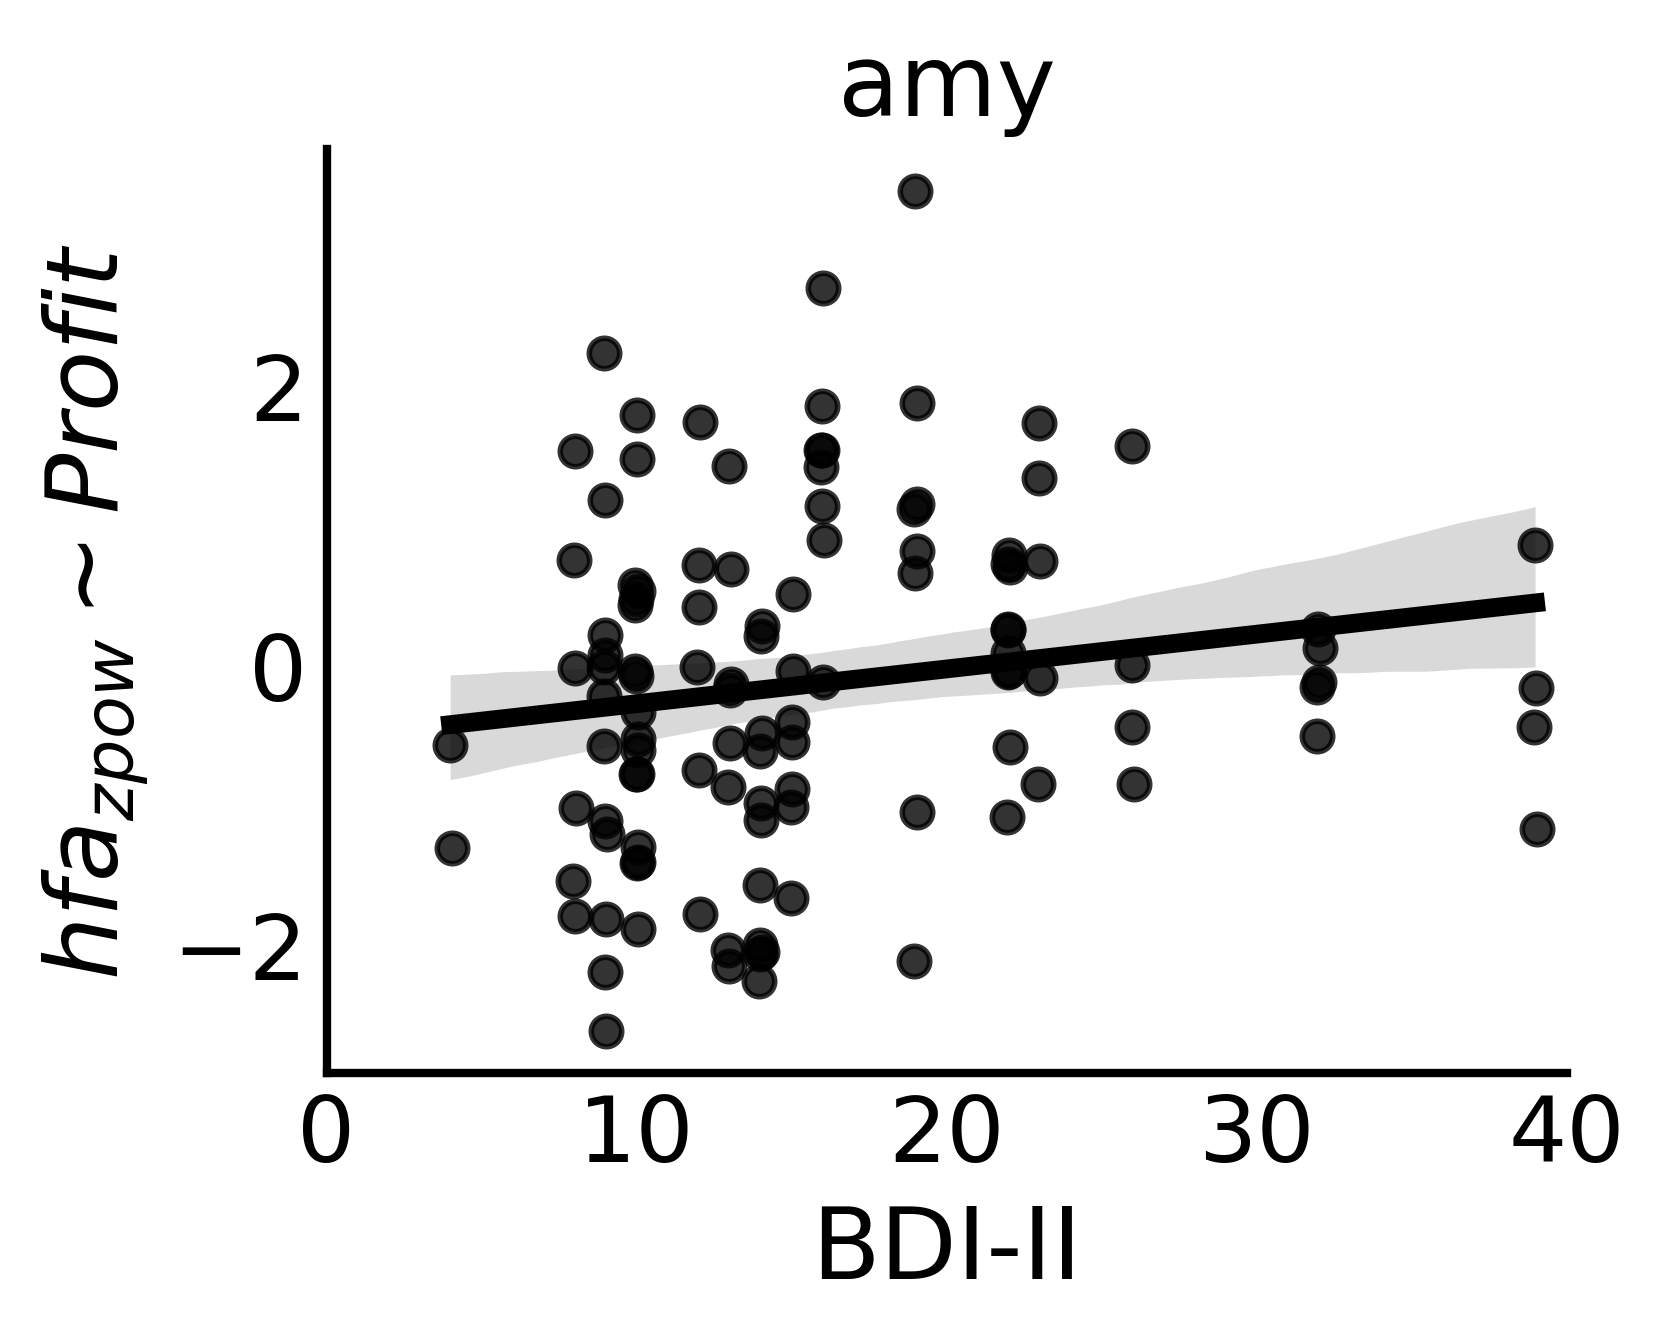

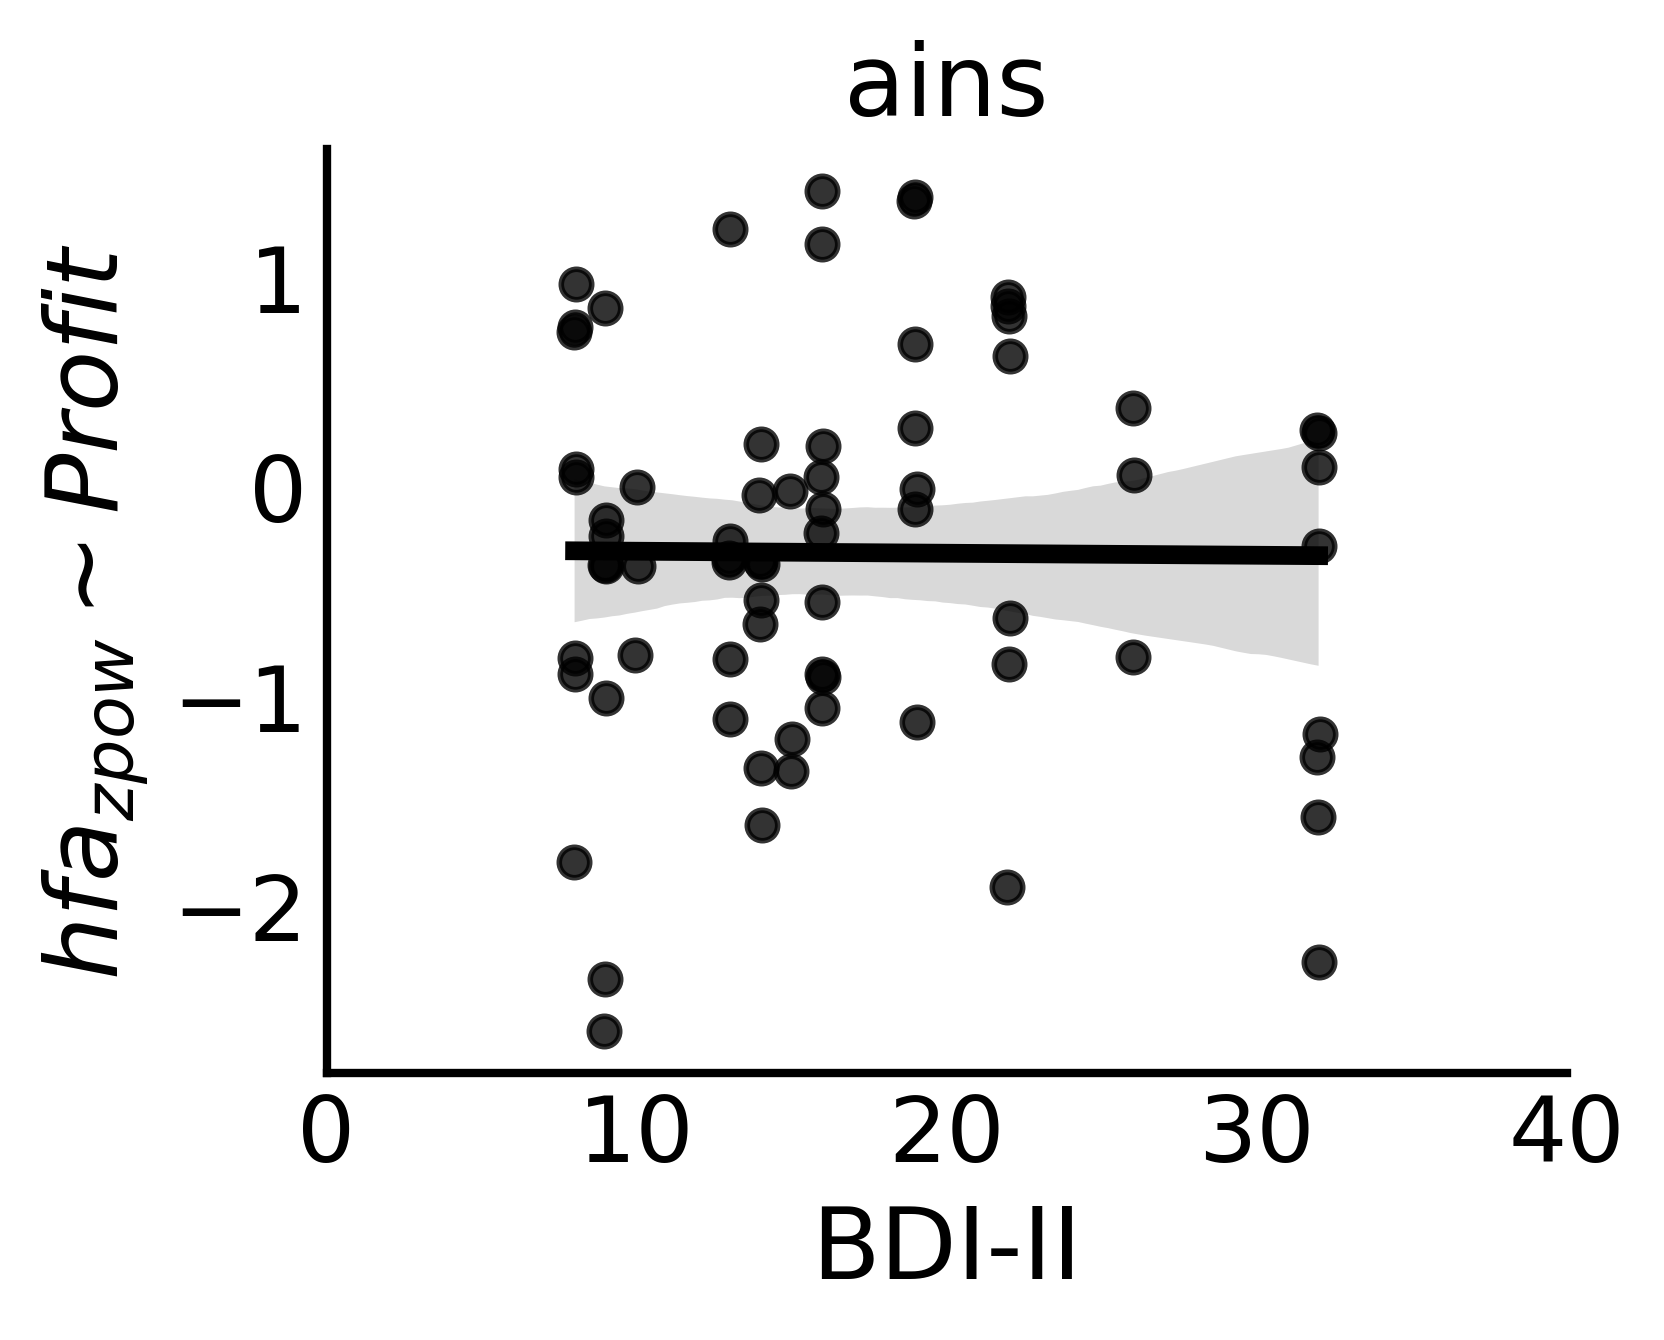

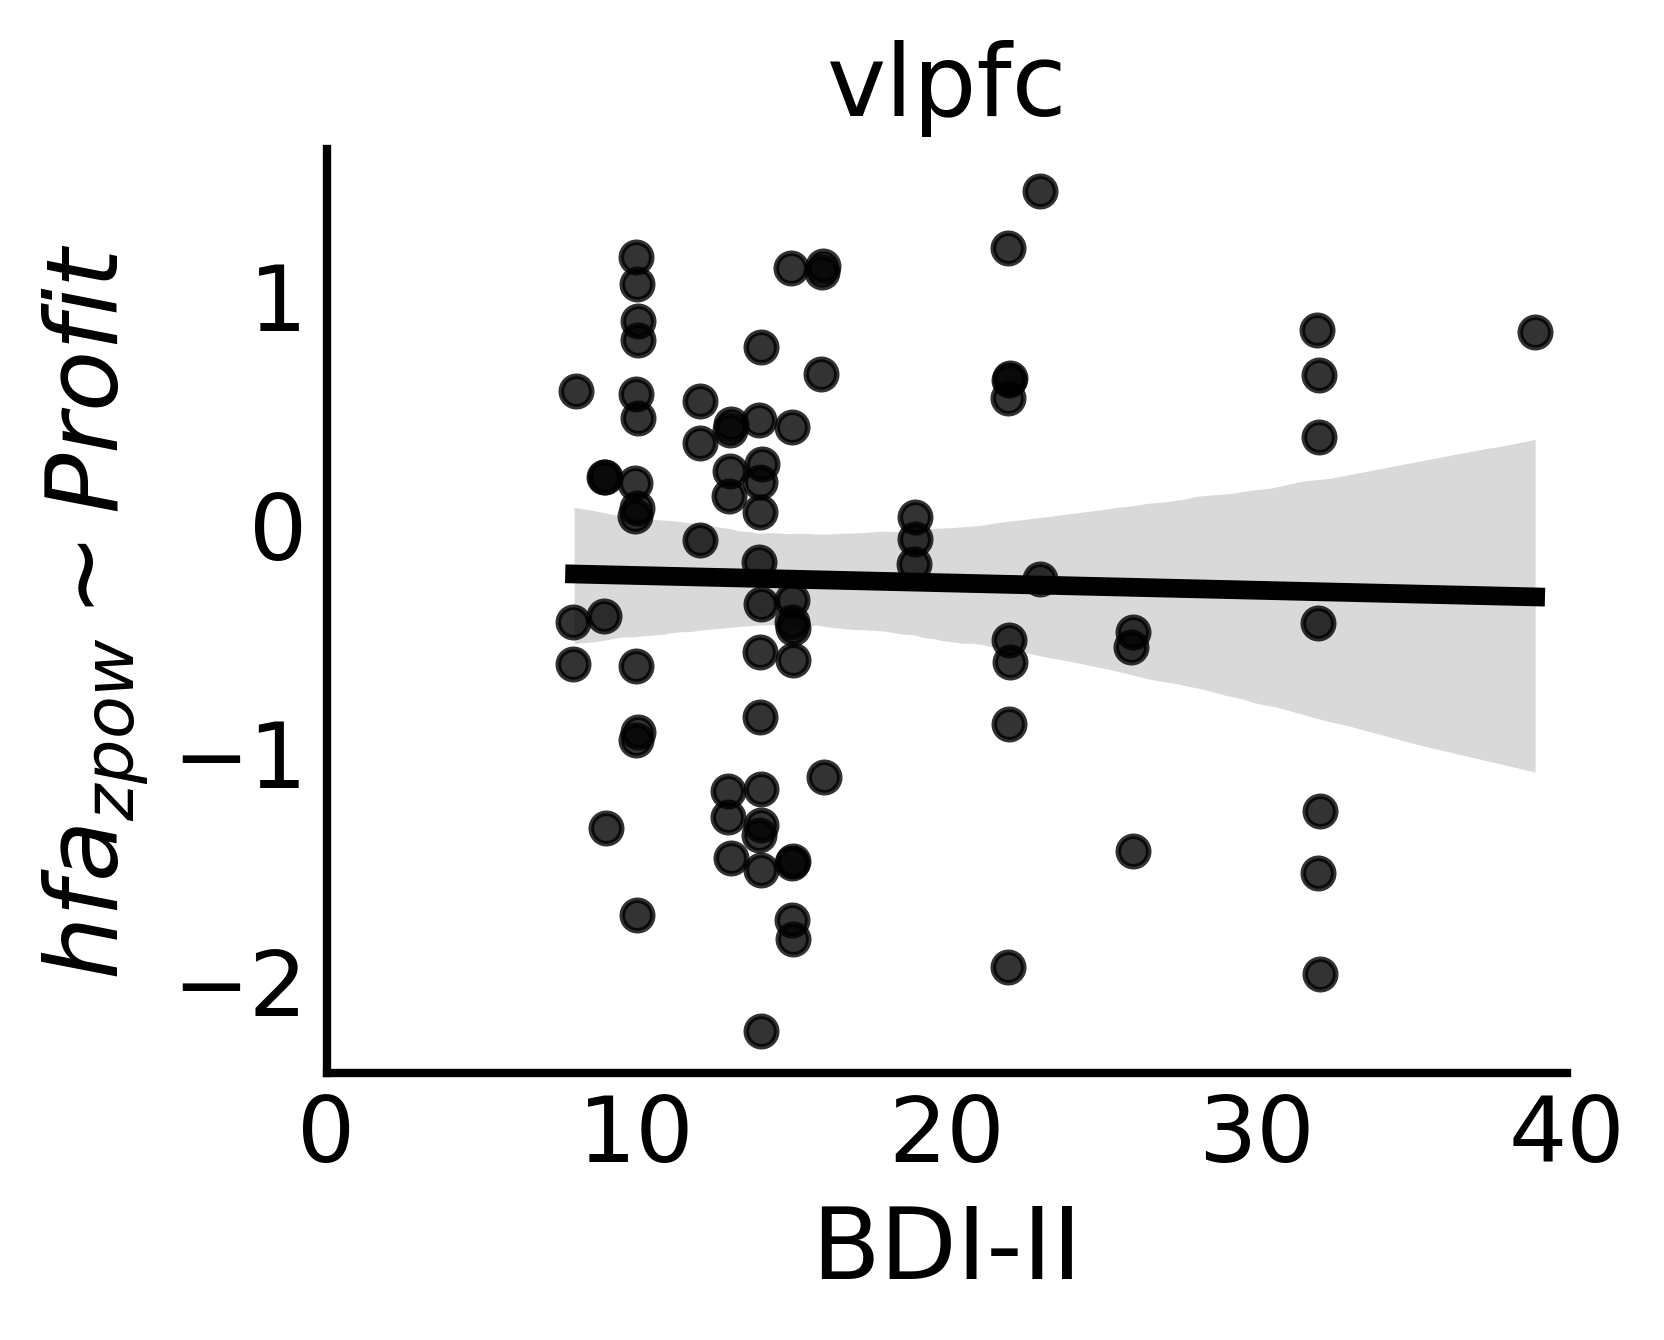

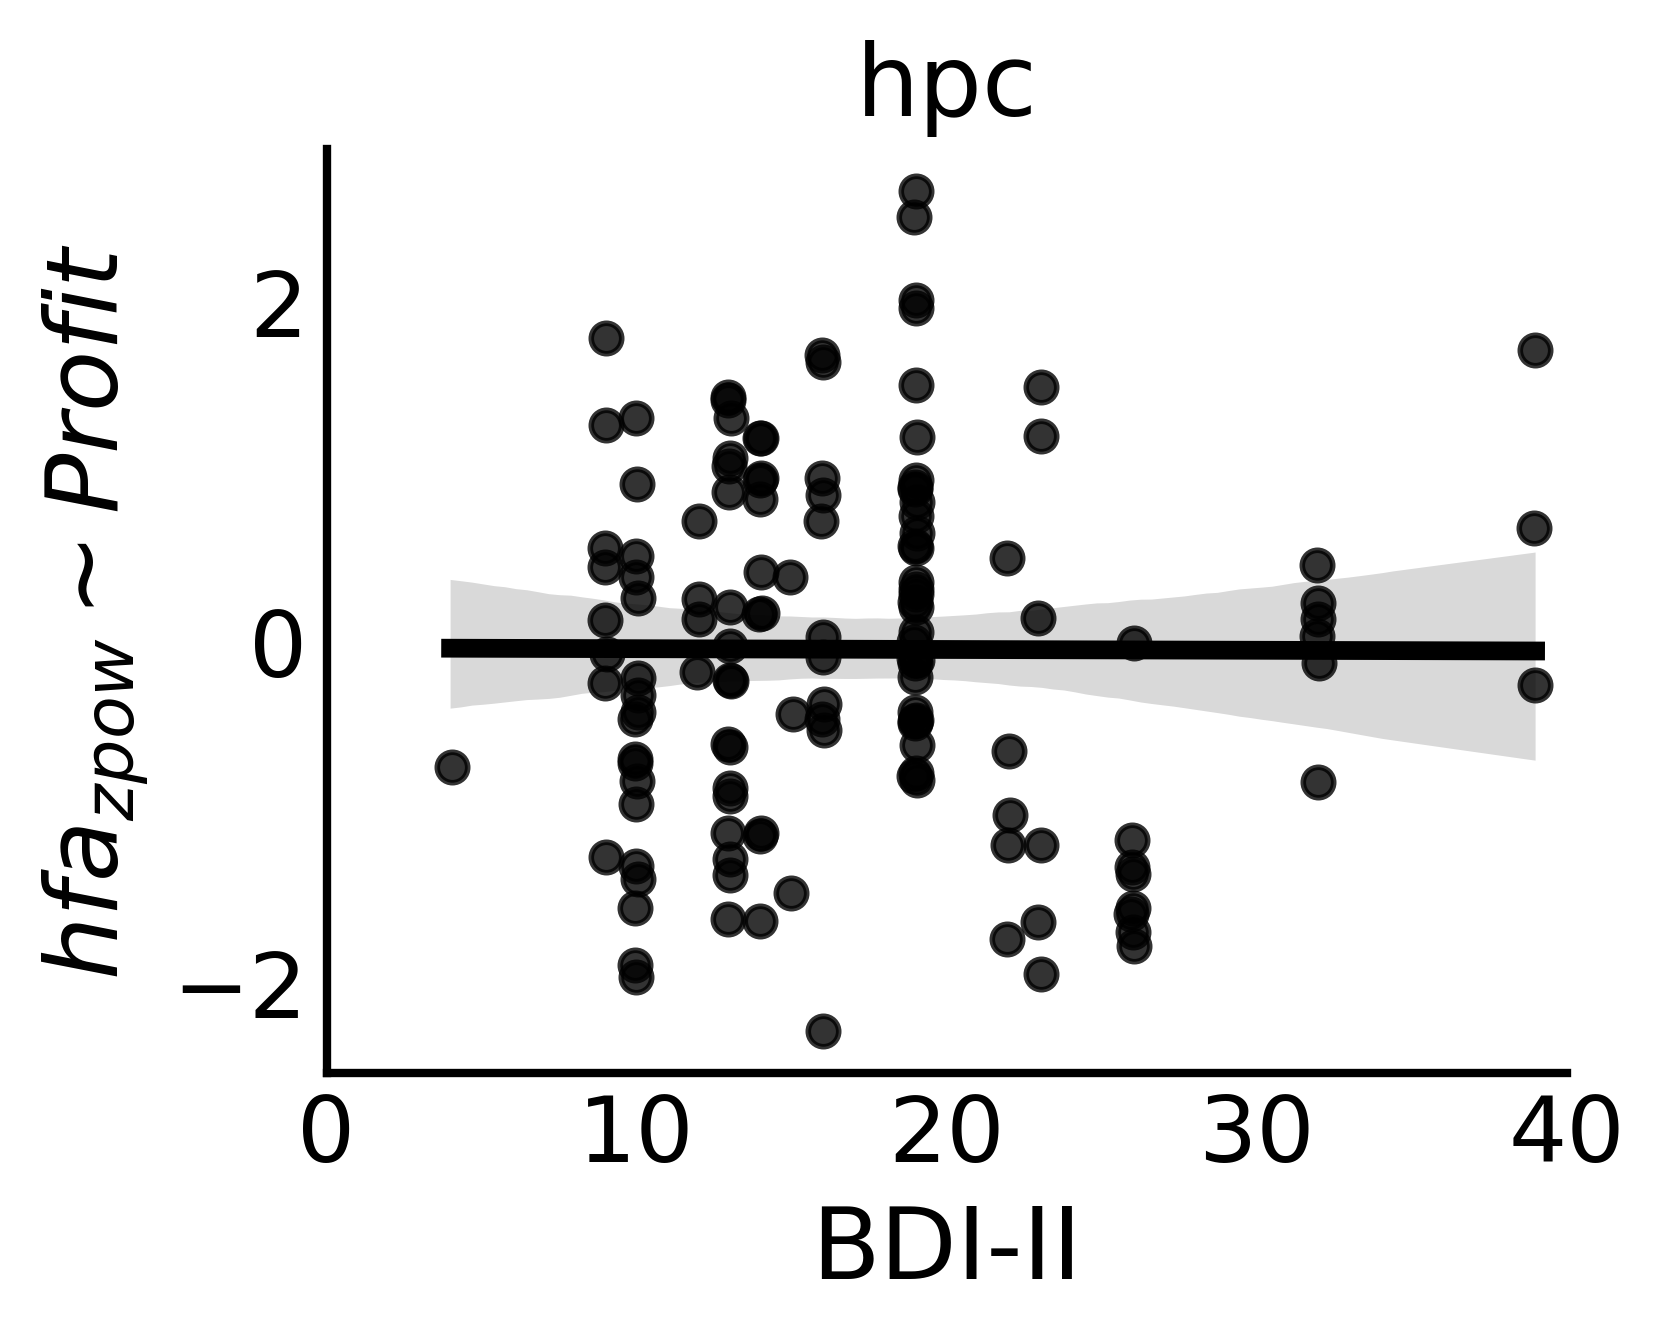

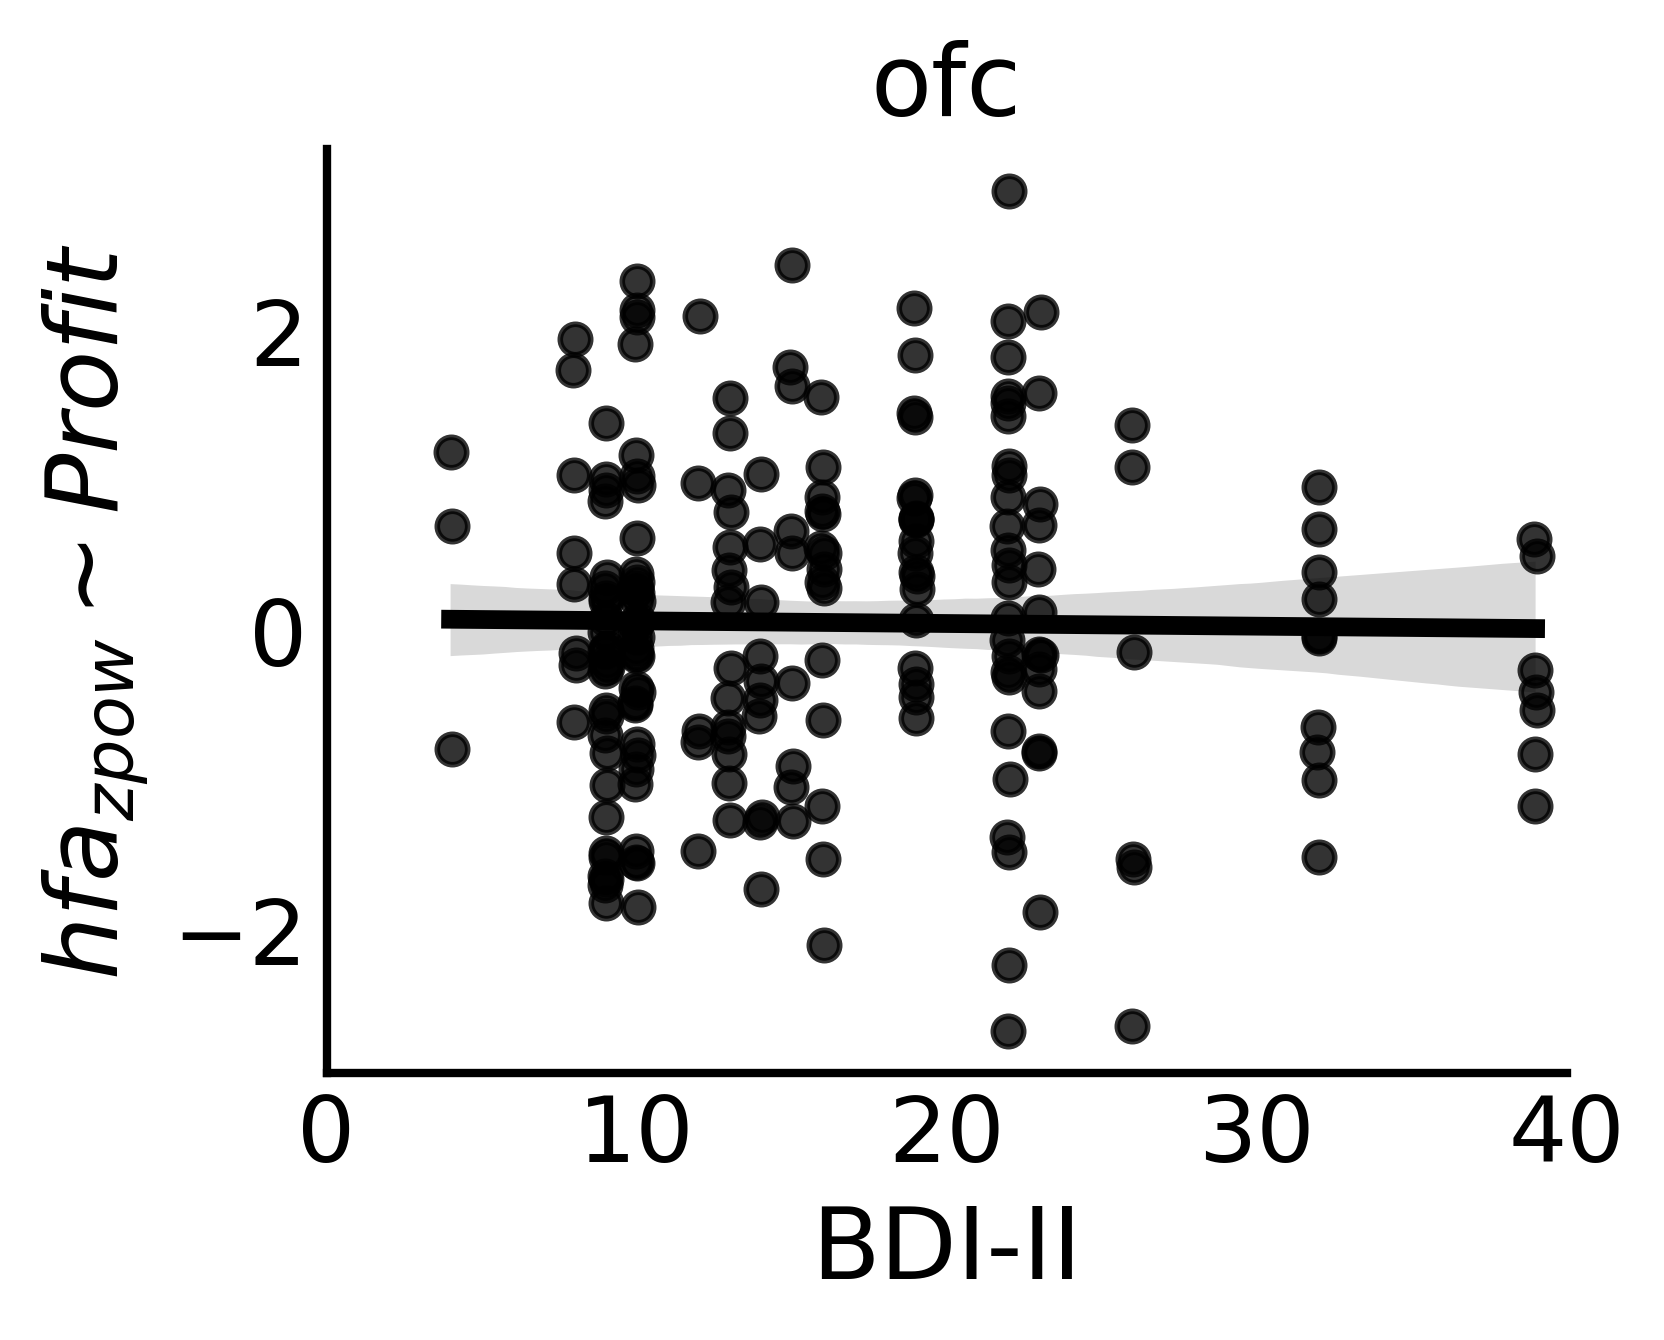

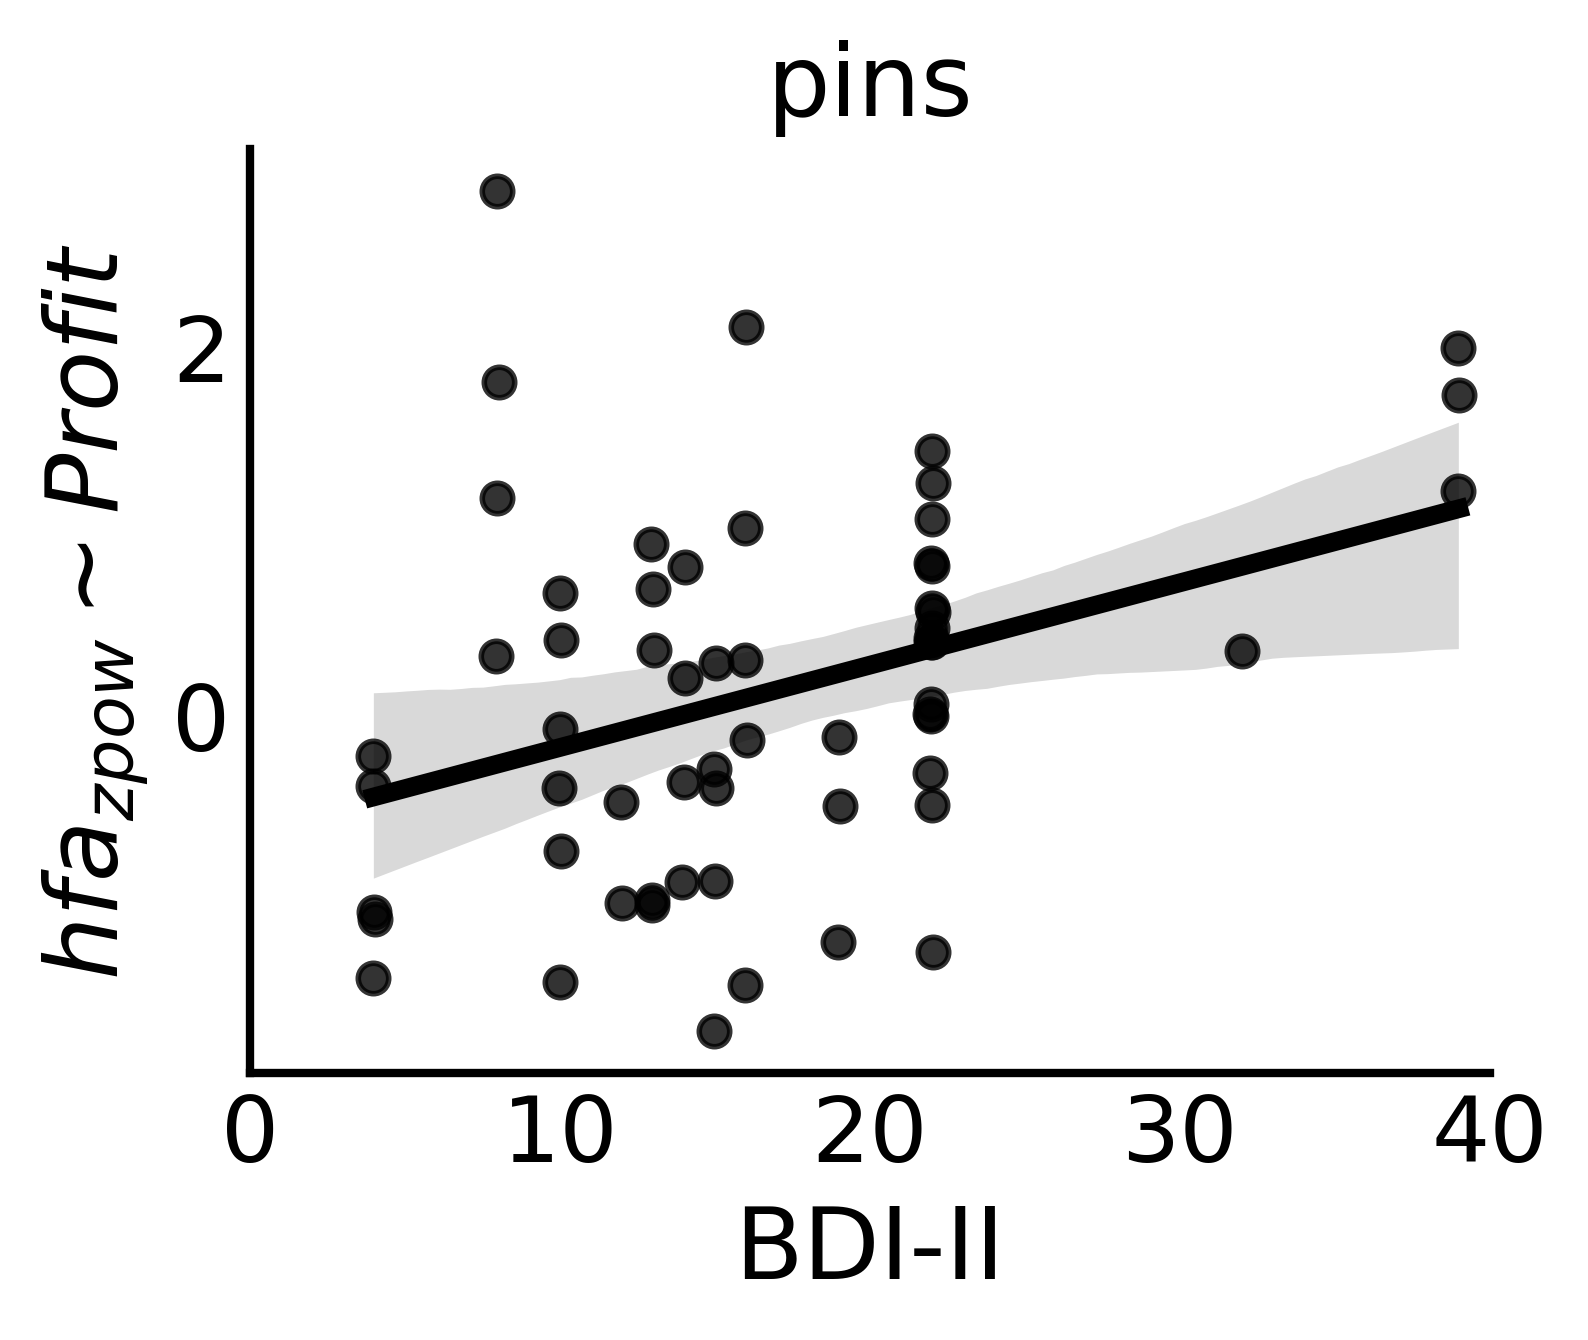

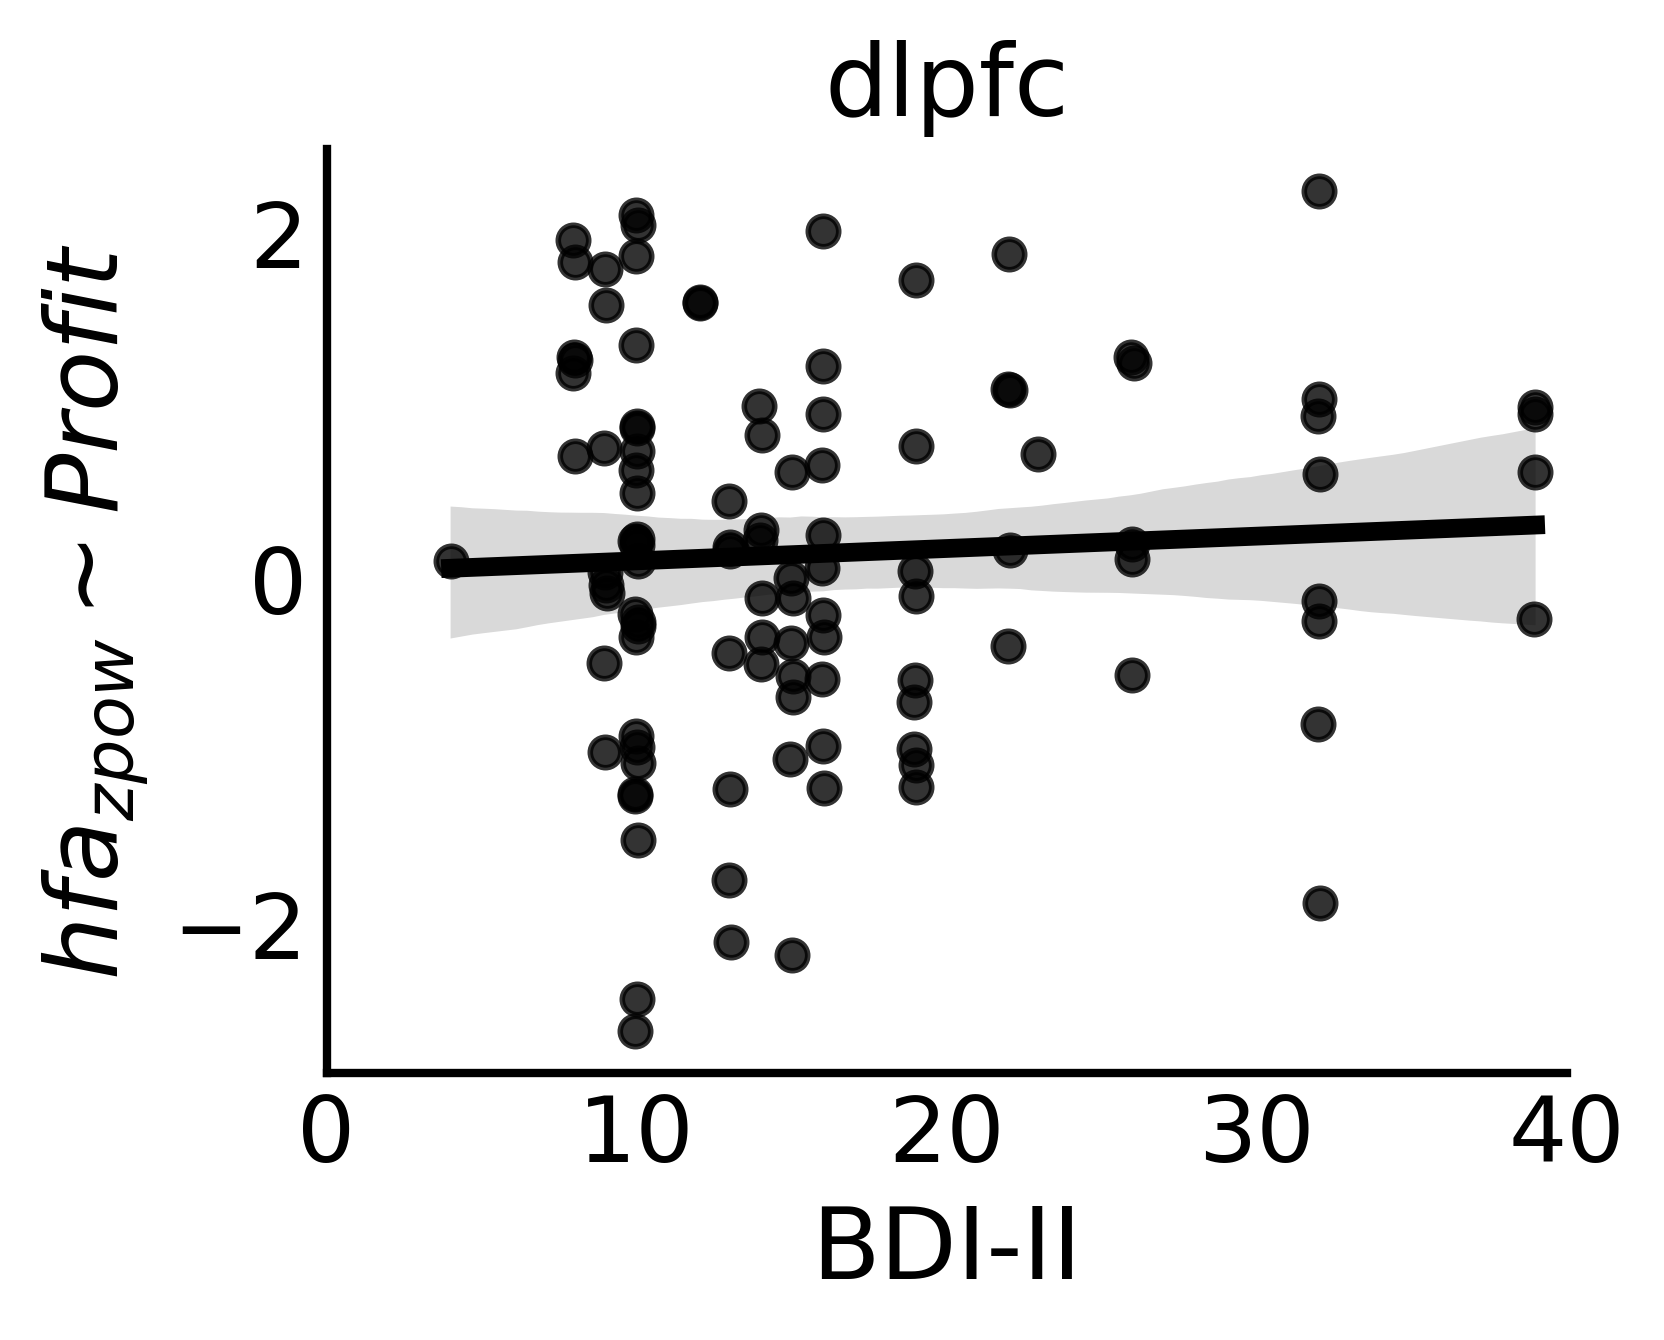

In [74]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_Profit_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [75]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:15:19                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8472      0.440     36.025     